In [ ]:
# colab drive 연동
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### import libraries

In [ ]:
! pip install folium
! pip install shapely
! pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 시각화 한글폰트 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import folium
from folium import plugins

import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
# 스케일러 
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()

In [ ]:
# 맵초기화
import folium
from folium.plugins import MarkerCluster
# 중심지 설정해서 맵로딩하기 (중심지 용인시)
m = folium.Map(location= (37.2410864,127.1775537),tiles = 'OpenStreetMap' , zoom_start = 11)

### 대회 제공데이터 load

In [ ]:
# 빅콘테스트 데이터 load 

df1 = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/backup/빅콘1_type.csv')
df2 = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/backup/빅콘2_type.csv')
df3 = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/backup/빅콘3_type.csv')

In [ ]:
df1 # 용인시 거주민이 용인시에서 앱을 실행한 데이터 = 용인시 거주자의 용인시 충전소 수요 

base_dt  dow  ccw_cd ccw_nm   adng_cd adng_nm   cell_id   cell_xcrd  \
0       20220605    7    4146    용인시  41463572    동백1동  86135034  127.152250   
1       20220625    6    4146    용인시  41465580    상현2동  84375196  127.090080   
2       20220614    2    4146    용인시  41461250     포곡읍  87958893  127.216600   
3       20220619    7    4146    용인시  41465530     신봉동  84119243  127.080970   
4       20220624    5    4146    용인시  41465580    상현2동  84423187  127.091780   
...          ...  ...     ...    ...       ...     ...       ...         ...   
292038  20220605    7    4146    용인시  41465570    상현1동  84071205  127.079384   
292039  20220607    2    4146    용인시  41461510     중앙동  87286847  127.193080   
292040  20220611    6    4146    용인시  41461259     남사읍  86630714  127.170300   
292041  20220618    6    4146    용인시  41461360     양지면  89926672  127.286095   
292042  20220618    6    4146    용인시  41465510   풍덕천1동  84343235  127.088860   

        cell_ycrd  gender  age app_web  time_zone  count_cust   type  
0       37.286300    MALE    6   EV라운지          5       3.522  충전플랫폼  
1       37.309536    MALE    8  파워큐브차저          2       4.231     완속  
2       37.274303  FEMALE   14   EV라운지          1      18.440  충전플랫폼  
3       37.323480    MALE   13   EV라운지          2       4.335  충전플랫폼  
4       37.306840    MALE    8   EV라운지          4       4.231  충전플랫폼  
...           ...     ...  ...     ...        ...         ...    ...  
292038  37.304993    MALE    2   EV라운지          3       5.082  충전플랫폼  
292039  37.234580    MALE    3   EV라운지          6       4.585  충전플랫폼  
292040  37.156097    MALE   13   EV라운지          2       6.452  충전플랫폼  
292041  37.230280    MALE    9   EV라운지          6       3.071  충전플랫폼  
292042  37.326210    MALE    9    하이차저          2       3.667  충전플랫폼  

[292043 rows x 15 columns]

In [ ]:
# 급속앱 전부 제거

index_급속앱 = df1[(df1['app_web']=='KEPCO PLUG') | (df1['app_web']=='채비') | (df1['app_web']=='에너지플러스EV') | (df1['app_web']=='해피차저')].index

df1 = df1.drop(index_급속앱)

df1['app_web'].value_counts()

EV라운지         242568
하이차저           42469
파워큐브차저          1674
G차저             1594
EV Infra        1555
차지비              484
에버온              385
환경부 통합 누리집       256
모두의충전            247
일렉배리             241
Epit             143
테슬라               14
evWhere           13
Name: app_web, dtype: int64

In [ ]:
# 빅콘 3번데이터 용인시내의 데이터만 추출 
# 편의상 각 데이터별로 추출시 밑 코드와의 연동성을 위해 df1으로 바꾸고 실행 

# not_Y = df1[df1['ccw_nm']!='용인시'].index
# df1 = df1.drop(not_Y)
# df1

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291643 entries, 0 to 292042
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   base_dt     291643 non-null  int64  
 1   dow         291643 non-null  int64  
 2   ccw_cd      291643 non-null  int64  
 3   ccw_nm      291643 non-null  object 
 4   adng_cd     291643 non-null  int64  
 5   adng_nm     291643 non-null  object 
 6   cell_id     291643 non-null  int64  
 7   cell_xcrd   291643 non-null  float64
 8   cell_ycrd   291643 non-null  float64
 9   gender      291643 non-null  object 
 10  age         291643 non-null  int64  
 11  app_web     291643 non-null  object 
 12  time_zone   291643 non-null  int64  
 13  count_cust  291643 non-null  float64
 14  type        291643 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 35.6+ MB


In [ ]:
df1['app_web'].value_counts()

EV라운지         242568
하이차저           42469
파워큐브차저          1674
G차저             1594
EV Infra        1555
차지비              484
에버온              385
환경부 통합 누리집       256
모두의충전            247
일렉배리             241
Epit             143
테슬라               14
evWhere           13
Name: app_web, dtype: int64

In [ ]:
df1['adng_nm'].value_counts()

구갈동      13818
죽전1동     13623
역삼동      13433
성복동      12605
동천동      12156
풍덕천2동    11758
상현1동     11447
신갈동      11108
구성동      11012
신봉동      10911
보라동      10514
풍덕천1동    10364
보정동       9676
동백1동      9622
모현읍       9362
마북동       9322
유림동       9040
상현2동      8930
포곡읍       8848
상하동       8801
동백2동      7418
영덕1동      7242
영덕2동      6722
중앙동       6220
양지면       6086
죽전2동      5804
남사읍       5285
동백3동      5266
이동읍       5050
서농동       4950
기흥동       4526
상갈동       4483
동부동       3018
원삼면       2177
백암면       1046
Name: adng_nm, dtype: int64

In [ ]:
df1['cell_id'].value_counts()

83895264    831
83911223    702
84039254    674
85047172    664
84183215    648
           ... 
87510824      1
88934962      1
83815328      1
87830901      1
83719085      1
Name: cell_id, Length: 12375, dtype: int64

### cell별 데이터 만들기 (count_cust를 cell_id별로 합치기) 

각 빅콘 데이터를 셀id기준으로 합쳐서 count_cust를 세주는 작업 

 ‘count_cust’열에 해당하는 값을 각 격자별 현재의 전기차 충전수요로 판단했다. 제공된 데이터가 모두 격자별로 고유한 id값을 가지기 때문에 해당 ‘cell_id’열을 기준으로 각 격자별 수요에 해당하는 count_cust값을 더해서 새로운 데이터프레임으로 가공

In [ ]:
# 셀별 데이터 만들기 (coord_comb)

cell_val = list(set(df1['cell_id'].values))
cell_val[:5], len(cell_val)

([88342548, 85622804, 85622805, 88086902, 89030704], 12375)

In [ ]:
s=[]
for i in tqdm(cell_val):
  df_cell = df1.loc[df1['cell_id']==i]
  s.append(df_cell['count_cust'].sum())

len(s)

100%|██████████| 12375/12375 [00:22<00:00, 540.92it/s]


12375

In [ ]:
cell = pd.DataFrame([ x for x in zip(cell_val,s)])
cell.columns = ['cell_id', 'cust_each_cell']



cell

cell_id  cust_each_cell
0      88342548          30.591
1      85622804          12.563
2      85622805          13.162
3      88086902           8.970
4      89030704           3.112
...         ...             ...
12370  84279263          25.801
12371  84279265          24.322
12372  84279269          43.232
12373  84279270         107.246
12374  84279283           4.374

[12375 rows x 2 columns]

In [ ]:
x=[]
y=[]
for i in tqdm(cell['cell_id']):
  df_id = df1.loc[df1['cell_id']==i]
  x.append(df_id['cell_xcrd'].values[0])
  y.append(df_id['cell_ycrd'].values[0])

100%|██████████| 12375/12375 [00:17<00:00, 705.85it/s] 


In [ ]:
# cell = 빅콘1,2,3번 각각의 cell별 count_cust와 위경도 dataframe
cell = pd.DataFrame([ i for i in zip(cell_val,s,x,y)])
cell.columns = ['cell_id', 'cust_each_cell', 'cell_xcrd', 'cell_ycrd']

cell

cell_id  cust_each_cell   cell_xcrd  cell_ycrd
0      88342548          30.591  127.230650  37.129658
1      85622804          12.563  127.134770  37.168163
2      85622805          13.162  127.134766  37.168613
3      88086902           8.970  127.221085  37.281975
4      89030704           3.112  127.254560  37.219402
...         ...             ...         ...        ...
12370  84279263          25.801  127.086540  37.337017
12371  84279265          24.322  127.086540  37.337917
12372  84279269          43.232  127.086525  37.339720
12373  84279270         107.246  127.086525  37.340170
12374  84279283           4.374  127.086494  37.346030

[12375 rows x 4 columns]

In [ ]:
# cell.to_csv('/content/gdrive/MyDrive/전기차개인파일/빅콘3번cell별count.csv')

###cell별 평균 age zone 구하기

거주지 최종수요 결정시 사용할 각 아파트별 age_group의 평균값 만들어주기 

In [ ]:
# sum(age * cust) / len(df->cell_id)

# 각 셀별 평균 age zone구하기 

# sum(s)는 각 cell별 나이대 * count / sum(each_id['count_cust])는 count의 총합 )

age_cell = []
for i in tqdm(range(len(cell))):
  each_id = df1[df1['cell_id'] == cell['cell_id'][i]]
  s = []
  for j in range(len(each_id)):
    s.append(each_id['age'].values[j] * each_id['count_cust'].values[j])
  age_cell.append(sum(s)/sum(each_id['count_cust']))


100%|██████████| 12375/12375 [00:14<00:00, 851.10it/s]


In [ ]:
# cell dataframe에 age_avg로 열 추가 

cell['age_avg'] = age_cell
cell

cell_id  cust_each_cell   cell_xcrd  cell_ycrd    age_avg
0      88342548          30.591  127.230650  37.129658   8.000000
1      85622804          12.563  127.134770  37.168163   5.504179
2      85622805          13.162  127.134766  37.168613   7.712354
3      88086902           8.970  127.221085  37.281975  12.000000
4      89030704           3.112  127.254560  37.219402   5.000000
...         ...             ...         ...        ...        ...
12370  84279263          25.801  127.086540  37.337017  10.353823
12371  84279265          24.322  127.086540  37.337917   6.553162
12372  84279269          43.232  127.086525  37.339720   6.161917
12373  84279270         107.246  127.086525  37.340170  10.783955
12374  84279283           4.374  127.086494  37.346030   9.000000

[12375 rows x 5 columns]

In [ ]:
# cell.to_csv('/content/gdrive/Shareddrives/전기차/data/backup/각cell별나이대포함_빅콘1번')

### 행정동별로 count_cust 확인하기

읍면동별 수요지수 산출을 위한 데이터셋 가공하기 

행정동명은 전부 빅콘에서 제공한 데이터의 행정동명으로 통일 

In [ ]:
# id 별로 묶은 데이터프레임 cell에 행정동명이랑 앱이름 추가해주기 
from tqdm import tqdm

adng_nm=[]

for i in tqdm(cell['cell_id']):
  df_id = df1.loc[df1['cell_id']==i]
  adng_nm.append(df_id['adng_nm'].values[0])



100%|██████████| 12375/12375 [00:10<00:00, 1221.44it/s]


In [ ]:
cell['adng_cm'] = adng_nm
cell

cell_id  cust_each_cell   cell_xcrd  cell_ycrd    age_avg adng_cm
0      88342548          30.591  127.230650  37.129658   8.000000     이동읍
1      85622804          12.563  127.134770  37.168163   5.504179     남사읍
2      85622805          13.162  127.134766  37.168613   7.712354     남사읍
3      88086902           8.970  127.221085  37.281975  12.000000     포곡읍
4      89030704           3.112  127.254560  37.219402   5.000000     양지면
...         ...             ...         ...        ...        ...     ...
12370  84279263          25.801  127.086540  37.337017  10.353823     동천동
12371  84279265          24.322  127.086540  37.337917   6.553162     동천동
12372  84279269          43.232  127.086525  37.339720   6.161917     동천동
12373  84279270         107.246  127.086525  37.340170  10.783955     동천동
12374  84279283           4.374  127.086494  37.346030   9.000000     동천동

[12375 rows x 6 columns]

In [ ]:
cell['adng_cm'].value_counts().keys()

Index(['포곡읍', '모현읍', '죽전1동', '역삼동', '보정동', '동천동', '구갈동', '구성동', '유림동', '양지면',
       '보라동', '성복동', '신갈동', '신봉동', '상현1동', '풍덕천2동', '마북동', '영덕1동', '동백1동',
       '중앙동', '풍덕천1동', '이동읍', '기흥동', '동백2동', '남사읍', '상하동', '영덕2동', '상현2동',
       '서농동', '죽전2동', '동백3동', '동부동', '상갈동', '원삼면', '백암면'],
      dtype='object')

행정동별 count_cust값 구하기 

In [ ]:
# df_count = 행정동별 count_cust 
a=[]
b=[]
for i in cell['adng_cm'].value_counts().keys():
  a.append( sum(cell[cell['adng_cm']==i]['cust_each_cell']) )
  b.append(i)

df_count = pd.DataFrame([ x for x in zip(b,a)], columns=['행정동','cust_each_cell'])
df_count = df_count.sort_values('cust_each_cell', ascending=False)
df_count

행정동  cust_each_cell
11    성복동      103420.254
2    죽전1동       98960.946
5     동천동       95293.624
3     역삼동       83327.567
14   상현1동       80829.972
6     구갈동       76355.630
13    신봉동       73854.709
15  풍덕천2동       71517.848
7     구성동       70373.600
20  풍덕천1동       67523.901
10    보라동       66974.472
12    신갈동       66949.827
27   상현2동       65324.381
8     유림동       61571.031
16    마북동       60651.371
0     포곡읍       59914.552
1     모현읍       59136.142
4     보정동       58536.926
18   동백1동       58422.144
25    상하동       53582.543
23   동백2동       44339.944
17   영덕1동       43490.345
19    중앙동       42238.038
9     양지면       40140.253
26   영덕2동       39286.576
30   동백3동       38931.272
29   죽전2동       38315.322
24    남사읍       32876.348
21    이동읍       32651.623
28    서농동       32442.825
32    상갈동       26605.000
22    기흥동       26240.418
31    동부동       19365.800
33    원삼면       19189.782
34    백암면        8487.501

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

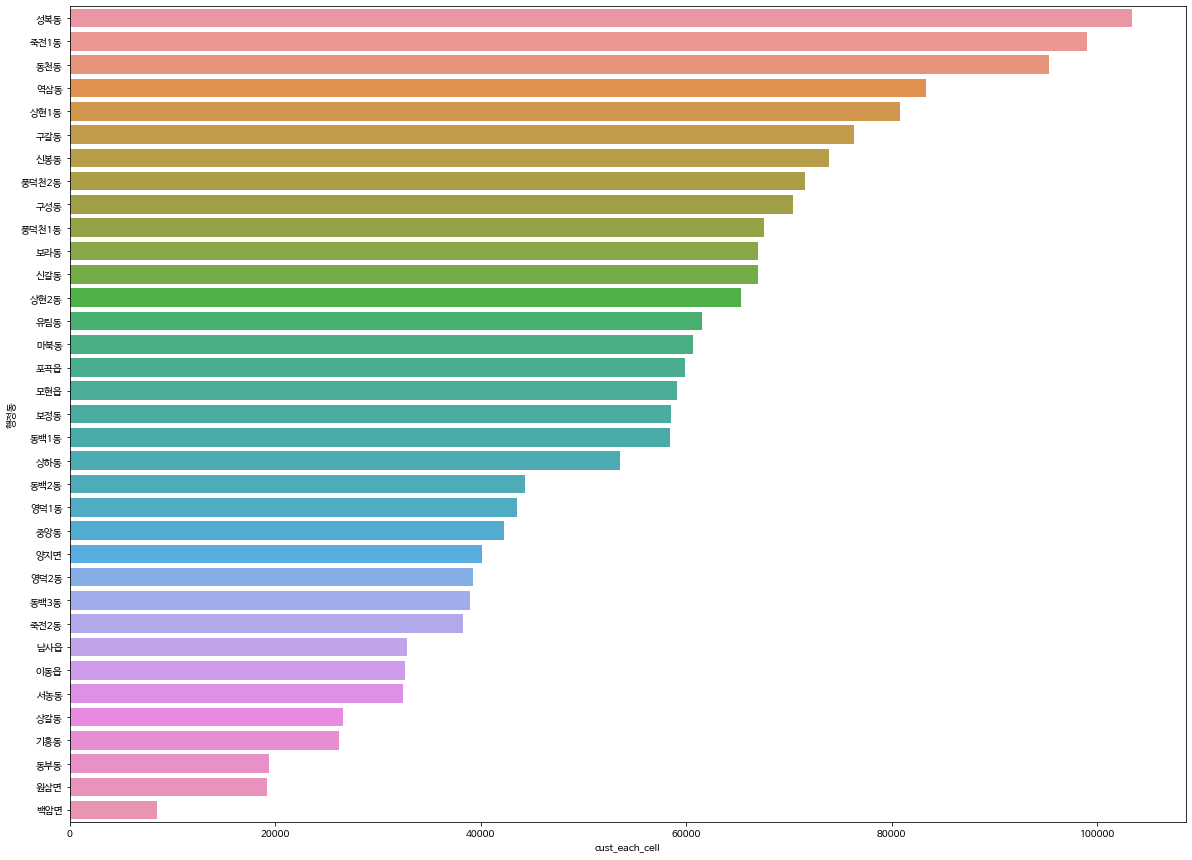

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

plt.figure(figsize=(20,15))
sns.barplot(x=df_count['cust_each_cell'], y=df_count['행정동'])

### 시각화 : 격자계산 (haversine)

haversine 라이브러리를 활용해 각cell별 중심점을 기준으로 50m * 50m 격자 만들어내기 

함수를 만들어 위경도 point 좌표를 50,50 sqaure grid를 그리기 위한 bound로 변경 

In [ ]:
# haversine 라이브러리 사용해서 역계산
! pip install haversine 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from haversine import inverse_haversine, Direction
from math import pi

In [ ]:
# 함수로 만들기

def get_bound (coordinate):
  north = inverse_haversine(coordinate, 25, Direction.NORTH, unit='m')
  up_right = inverse_haversine(north, 25, Direction.EAST, unit='m')

  south = inverse_haversine(coordinate, 25, Direction.SOUTH, unit='m')
  dn_left = inverse_haversine(south, 25, Direction.WEST, unit='m')

  return [up_right,dn_left]


In [ ]:
test_grid=[]
for j in tqdm(range(len(cell))):
   test_grid.append( (cell['cell_ycrd'][j],cell['cell_xcrd'][j]) )


bounds=[]
for i in tqdm(range(len(test_grid))):
  bounds.append(get_bound(test_grid[i]))

100%|██████████| 12375/12375 [00:00<00:00, 31610.54it/s]


### 시각화: 수요구간을 나눠 격자별로 count_cust 확인하기  

계산해낸 bound 별 카운트에 구간을 부여해서 수요가 많은 격자를 파악하고자 함 

In [ ]:
# bound 열 추가
len(bounds)

cell['bounds'] = bounds

In [ ]:
# 구간 파악 
cell

cell_id  cust_each_cell   cell_xcrd  cell_ycrd    age_avg adng_cm  \
0      88342548          30.591  127.230650  37.129658   8.000000     이동읍   
1      85622804          12.563  127.134770  37.168163   5.504179     남사읍   
2      85622805          13.162  127.134766  37.168613   7.712354     남사읍   
3      88086902           8.970  127.221085  37.281975  12.000000     포곡읍   
4      89030704           3.112  127.254560  37.219402   5.000000     양지면   
...         ...             ...         ...        ...        ...     ...   
12370  84279263          25.801  127.086540  37.337017  10.353823     동천동   
12371  84279265          24.322  127.086540  37.337917   6.553162     동천동   
12372  84279269          43.232  127.086525  37.339720   6.161917     동천동   
12373  84279270         107.246  127.086525  37.340170  10.783955     동천동   
12374  84279283           4.374  127.086494  37.346030   9.000000     동천동   

                                                  bounds  
0      [(37.12988282975696, 127.23093200021611), (37....  
1      [(37.16838782975648, 127.13505214383754), (37....  
2      [(37.16883782975649, 127.13504814551762), (37....  
3      [(37.28219982975511, 127.22136756995314), (37....  
4      [(37.219626829755875, 127.25484233538087), (37...  
...                                                  ...  
12370  [(37.33724182975443, 127.08682277689485), (37....  
12371  [(37.33814182975443, 127.08682278028326), (37....  
12372  [(37.339944829754415, 127.08680778707188), (37...  
12373  [(37.340394829754395, 127.0868077887663), (37....  
12374  [(37.34625482975434, 127.08677681083485), (37....  

[12375 rows x 7 columns]

In [ ]:
cell['cust_each_cell'].describe()

count    12375.000000
mean       154.918989
std        405.547844
min          3.011000
25%          6.022000
50%         18.107000
75%         90.054000
max       9053.894000
Name: cust_each_cell, dtype: float64

In [ ]:
# count를 월평균 이용수요라고 가정한다면 15회 이하는 수익성이 없는 것으로 분류 

# 1구간: 15이하
# 2구간: 50% -> 18이하
# 3구간: 75% -> 90이하
# 4구간: 그 이상   

In [ ]:
cust = cell['cust_each_cell'].to_list()

one=[]
two=[]
three=[]
four=[]

for i in cell['cust_each_cell']:
  if i < 15:
    one.append(i)
  elif 15<i<18:
    two.append(i)
  elif 18<i < 90:
    three.append(i)
  elif i>90 :
    four.append(i)  

In [ ]:
bins = [0,15,18,90,9054]
cell['count_bins'] = pd.cut(x=cell.cust_each_cell, bins=bins,
                            labels = ['one','two','three','four'],include_lowest=True)



In [ ]:
# count_bins = 각 셀을 수요정도에 따라 나눈 구간 / 수요가 많을 수록 높은 숫자 
cell

cell_id  cust_each_cell   cell_xcrd  cell_ycrd    age_avg adng_cm  \
0      88342548          30.591  127.230650  37.129658   8.000000     이동읍   
1      85622804          12.563  127.134770  37.168163   5.504179     남사읍   
2      85622805          13.162  127.134766  37.168613   7.712354     남사읍   
3      88086902           8.970  127.221085  37.281975  12.000000     포곡읍   
4      89030704           3.112  127.254560  37.219402   5.000000     양지면   
...         ...             ...         ...        ...        ...     ...   
12370  84279263          25.801  127.086540  37.337017  10.353823     동천동   
12371  84279265          24.322  127.086540  37.337917   6.553162     동천동   
12372  84279269          43.232  127.086525  37.339720   6.161917     동천동   
12373  84279270         107.246  127.086525  37.340170  10.783955     동천동   
12374  84279283           4.374  127.086494  37.346030   9.000000     동천동   

                                                  bounds count_bins  
0      [(37.12988282975696, 127.23093200021611), (37....      three  
1      [(37.16838782975648, 127.13505214383754), (37....        one  
2      [(37.16883782975649, 127.13504814551762), (37....        one  
3      [(37.28219982975511, 127.22136756995314), (37....        one  
4      [(37.219626829755875, 127.25484233538087), (37...        one  
...                                                  ...        ...  
12370  [(37.33724182975443, 127.08682277689485), (37....      three  
12371  [(37.33814182975443, 127.08682278028326), (37....      three  
12372  [(37.339944829754415, 127.08680778707188), (37...      three  
12373  [(37.340394829754395, 127.0868077887663), (37....       four  
12374  [(37.34625482975434, 127.08677681083485), (37....        one  

[12375 rows x 8 columns]

In [ ]:
print(cell['count_bins'].value_counts())

one      5710
three    3107
four     3095
two       463
Name: count_bins, dtype: int64


In [ ]:
cell_one = cell.loc[cell['count_bins']=='one']
cell_two = cell.loc[cell['count_bins']=='two']
cell_three = cell.loc[cell['count_bins']=='three']
cell_four = cell.loc[cell['count_bins']=='four']

cell_one['bounds'].values[0]
cell_two['bounds'].values[0]

[(37.26085282975536, 127.15885248984632),
 (37.26040316957351, 127.15828751184014)]

In [ ]:
# 구간별로 나눈 격자를 각각 다른 색 농도로 지도에 시각화 
for one in cell_one['bounds'].values:
  folium.Rectangle(one , color='black', fill=True, fill_color ='black', fill_opacity=0.1 ).add_to(m)

for two in cell_two['bounds'].values:
  folium.Rectangle(two , color='black', fill=True, fill_color ='black', fill_opacity=0.3 ).add_to(m)

for three in cell_three['bounds'].values:
  folium.Rectangle(three , color='black', fill=True, fill_color ='black', fill_opacity=0.5 ).add_to(m)

for four in cell_four['bounds'].values:
  folium.Rectangle(four , color='black', fill=True, fill_color ='black', fill_opacity=0.8 ).add_to(m)

In [ ]:
m

### 시각화: 용인시 행정구 시각화 (json)

전국 행정구 geojson파일 파싱해서 용인시데이터만 추출후 지도위에 용인시 행정동 범위 그리기 

In [ ]:
import json
import requests

# 전국 행정구 geojson파일 불러오기 

r = requests.get('https://raw.githubusercontent.com/vuski/admdongkor/master/ver20220401/HangJeongDong_ver20220401.geojson')
c = r.content
geo = json.loads(c)

In [ ]:
# 용인시 데이터만 가져와서 list로 만들기 
from tqdm import tqdm

yongin = []
for i in tqdm(range(len(geo['features']))):
  if geo['features'][i]['properties']['sggnm'] == '용인시수지구':
    yongin.append(geo['features'][i])



  elif geo['features'][i]['properties']['sggnm'] == '용인시기흥구':
    yongin.append(geo['features'][i])



  elif geo['features'][i]['properties']['sggnm'] == '용인시처인구':
    yongin.append(geo['features'][i])



100%|██████████| 3512/3512 [00:00<00:00, 365854.40it/s]


In [ ]:
y_geo =  pd.DataFrame(yongin)
y_geo

type                                         properties  \
0   Feature  {'OBJECTID': 1484, 'adm_nm': '경기도 용인시처인구 포곡읍',...   
1   Feature  {'OBJECTID': 1485, 'adm_nm': '경기도 용인시처인구 모현읍',...   
2   Feature  {'OBJECTID': 1486, 'adm_nm': '경기도 용인시처인구 남사읍',...   
3   Feature  {'OBJECTID': 1487, 'adm_nm': '경기도 용인시처인구 이동읍',...   
4   Feature  {'OBJECTID': 1488, 'adm_nm': '경기도 용인시처인구 원삼면',...   
5   Feature  {'OBJECTID': 1489, 'adm_nm': '경기도 용인시처인구 백암면',...   
6   Feature  {'OBJECTID': 1490, 'adm_nm': '경기도 용인시처인구 양지면',...   
7   Feature  {'OBJECTID': 1491, 'adm_nm': '경기도 용인시처인구 중앙동',...   
8   Feature  {'OBJECTID': 1492, 'adm_nm': '경기도 용인시처인구 삼가동',...   
9   Feature  {'OBJECTID': 1493, 'adm_nm': '경기도 용인시처인구 유림동',...   
10  Feature  {'OBJECTID': 1494, 'adm_nm': '경기도 용인시처인구 동부동',...   
11  Feature  {'OBJECTID': 1495, 'adm_nm': '경기도 용인시기흥구 구갈동',...   
12  Feature  {'OBJECTID': 1496, 'adm_nm': '경기도 용인시기흥구 보라동',...   
13  Feature  {'OBJECTID': 1497, 'adm_nm': '경기도 용인시기흥구 기흥동',...   
14  Feature  {'OBJECTID': 1498, 'adm_nm': '경기도 용인시기흥구 서농동',...   
15  Feature  {'OBJECTID': 1499, 'adm_nm': '경기도 용인시기흥구 구성동',...   
16  Feature  {'OBJECTID': 1500, 'adm_nm': '경기도 용인시기흥구 마북동',...   
17  Feature  {'OBJECTID': 1501, 'adm_nm': '경기도 용인시기흥구 동백3동'...   
18  Feature  {'OBJECTID': 1502, 'adm_nm': '경기도 용인시기흥구 보정동',...   
19  Feature  {'OBJECTID': 1503, 'adm_nm': '경기도 용인시기흥구 상하동',...   
20  Feature  {'OBJECTID': 1504, 'adm_nm': '경기도 용인시기흥구 신갈동',...   
21  Feature  {'OBJECTID': 1505, 'adm_nm': '경기도 용인시기흥구 영덕2동'...   
22  Feature  {'OBJECTID': 1506, 'adm_nm': '경기도 용인시수지구 풍덕천1동...   
23  Feature  {'OBJECTID': 1507, 'adm_nm': '경기도 용인시수지구 풍덕천2동...   
24  Feature  {'OBJECTID': 1508, 'adm_nm': '경기도 용인시수지구 신봉동',...   
25  Feature  {'OBJECTID': 1509, 'adm_nm': '경기도 용인시수지구 죽전3동'...   
26  Feature  {'OBJECTID': 1510, 'adm_nm': '경기도 용인시수지구 죽전2동'...   
27  Feature  {'OBJECTID': 1511, 'adm_nm': '경기도 용인시수지구 동천동',...   
28  Feature  {'OBJECTID': 1512, 'adm_nm': '경기도 용인시수지구 상현3동'...   
29  Feature  {'OBJECTID': 1513, 'adm_nm': '경기도 용인시수지구 상현2동'...   
30  Feature  {'OBJECTID': 1514, 'adm_nm': '경기도 용인시수지구 성복동',...   
31  Feature  {'OBJECTID': 3484, 'adm_nm': '경기도 용인시기흥구 영덕1동'...   
32  Feature  {'OBJECTID': 3485, 'adm_nm': '경기도 용인시기흥구 상갈동',...   
33  Feature  {'OBJECTID': 3486, 'adm_nm': '경기도 용인시기흥구 동백2동'...   
34  Feature  {'OBJECTID': 3487, 'adm_nm': '경기도 용인시기흥구 동백1동'...   
35  Feature  {'OBJECTID': 1492, 'adm_nm': '경기도 용인시처인구 역북동',...   
36  Feature  {'OBJECTID': 1509, 'adm_nm': '경기도 용인시수지구 죽전1동'...   
37  Feature  {'OBJECTID': 1512, 'adm_nm': '경기도 용인시수지구 상현1동'...   

                                             geometry  
0   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
1   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
2   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
3   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
4   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
5   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
6   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
7   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
8   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
9   {'type': 'MultiPolygon', 'coordinates': [[[[12...  
10  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
11  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
12  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
13  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
14  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
15  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
16  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
17  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
18  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
19  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
20  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
21  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
22  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
23  {'type': 'MultiPolygon', 'coordinates': [[[[12...  
24  {'type': 'MultiPolygon', 'co

In [ ]:
for i in tqdm(range(len(yongin))):
  folium.GeoJson(yongin[i], name = '지역구').add_to(m)
m

In [ ]:
yongin

### 한국환경공단_전기자동차 전국 충전소 정보 openapi 불러오기 

한국환경공단 전기차 전국 충전소 정보 openapi에서 용인시 정보만 파싱해서 분석에 사용할 데이터프레임으로 저장 

In [ ]:
# 용인시가 들어가있는 행 찾기
import re


In [ ]:
from os import name
import xml.etree.ElementTree as et
import pandas as pd
import bs4
from lxml import html
from urllib.parse import urlencode, quote_plus, unquote


import requests
import pprint

#인증키 입력
encoding = 'ddFWTw1pGZsh2OVAv05I9V0j4okLA5m9jz7oOO%2BBDUuKfiOkb9BEZ4lAcS3Y4etXjsoP4%2F4Kxrf%2FI4YqL0pTBg%3D%3D'
decoding = 'ddFWTw1pGZsh2OVAv05I9V0j4okLA5m9jz7oOO+BDUuKfiOkb9BEZ4lAcS3Y4etXjsoP4/4Kxrf/I4YqL0pTBg=='

#url 입력
url = 'http://apis.data.go.kr/B552584/EvCharger/getChargerInfo'
params ={'serviceKey' : decoding, 'pageNo' : '4', 'numOfRows' : '9999', 'zcode' : '41' }

response = requests.get(url, params=params)


# xml 내용
content = response.text

# 깔끔한 출력 위한 코드
pp = pprint.PrettyPrinter(indent=4)
#print(pp.pprint(content))

xml_obj = bs4.BeautifulSoup(content,'lxml-xml')
rows = xml_obj.findAll('item')
print(rows)

# 각 행의 컬럼, 이름, 값을 가지는 리스트 만들기
row_list = [] # 행값
name_list = [] # 열이름값
value_list = [] #데이터값

# xml 안의 데이터 수집
for i in range(0, len(rows)):
    columns = rows[i].find_all()
    #첫째 행 데이터 수집
    for j in range(0,len(columns)):
        if i ==0:
            # 컬럼 이름 값 저장
            name_list.append(columns[j].name)
        # 컬럼의 각 데이터 값 저장
        value_list.append(columns[j].text)
    # 각 행의 value값 전체 저장
    row_list.append(value_list)
    # 데이터 리스트 값 초기화
    value_list=[]



#xml값 DataFrame으로 만들기
charger_df = pd.DataFrame(row_list, columns=name_list)
charger_df

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



statNm    statId chgerId chgerType               addr location  \
0        여주오드카운티아파트  PW011251      07        02  경기도 여주시 도예로 83-36     null   
1        여주오드카운티아파트  PW011251      08        02  경기도 여주시 도예로 83-36     null   
2     반도유보라아이비파크1단지  PW011253      01        02   경기도 평택시 비전2로 297     null   
3     반도유보라아이비파크1단지  PW011253      02        02   경기도 평택시 비전2로 297     null   
4     반도유보라아이비파크1단지  PW011253      03        02   경기도 평택시 비전2로 297     null   
...             ...       ...     ...       ...                ...      ...   
9728     동패동 중흥S클래스  UN000062      20        02   경기도 파주시 심학산로 234    지하주차장   
9729     동패동 중흥S클래스  UN000062      21        02   경기도 파주시 심학산로 234    지하주차장   
9730     동패동 중흥S클래스  UN000062      22        02   경기도 파주시 심학산로 234    지하주차장   
9731     동패동 중흥S클래스  UN000062      23        02   경기도 파주시 심학산로 234    지하주차장   
9732     동패동 중흥S클래스  UN000062      24        02   경기도 파주시 심학산로 234    지하주차장   

                  lat             lng    useTime busiId  ... zcode zscode  \
0     37.312540999895  127.6423128433  24시간 이용가능     PW  ...    41  41670   
1     37.312540999895  127.6423128433  24시간 이용가능     PW  ...    41  41670   
2     37.008807381497  127.1134858293  24시간 이용가능     PW  ...    41  41220   
3     37.008807381497  127.1134858293  24시간 이용가능     PW  ...    41  41220   
4     37.008807381497  127.1134858293  24시간 이용가능     PW  ...    41  41220   
...               ...             ...        ...    ...  ...   ...    ...   
9728       37.7157805     126.7194497  24시간 이용가능     UN  ...    41  41480   
9729       37.7157805     126.7194497  24시간 이용가능     UN  ...    41  41480   
9730       37.7157805     126.7194497  24시간 이용가능     UN  ...    41  41480   
9731       37.7157805     126.7194497  24시간 이용가능     UN  ...    41  41480   
9732       37.7157805     126.7194497  24시간 이용가능     UN  ...    41  41480   

     kind kindDetail parkingFree note limitYn limitDetail delYn delDetail  
0      H0       H001           Y            Y   거주자외 출입제한     N            
1      H0       H001           Y            Y   거주자외 출입제한     N            
2      H0       H001           Y            Y   거주자외 출입제한     N            
3      H0       H001           Y            Y   거주자외 출입제한     N            
4      H0       H001           Y            Y   거주자외 출입제한     N            
...   ...        ...         ...  ...     ...         ...   ...       ...  
9728   H0       H001           Y            Y  방문객 외 출입제한     N            
9729   H0       H001           Y            Y  방문객 외 출입제한     N            
9730   H0       H001           Y            Y  방문객 외 출입제한     N            
9731   H0       H001           Y            Y  방문객 외 출입제한     N            
9732   H0       H001           Y            Y  방문객 외 출입제한     N            

[9733 rows x 31 columns]

In [ ]:
#yongin1로 저장

import re


yongin1 = charger_df[charger_df['addr'].str.contains('용인')]
yongin1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 15 to 9703
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statNm       1115 non-null   object
 1   statId       1115 non-null   object
 2   chgerId      1115 non-null   object
 3   chgerType    1115 non-null   object
 4   addr         1115 non-null   object
 5   location     1115 non-null   object
 6   lat          1115 non-null   object
 7   lng          1115 non-null   object
 8   useTime      1115 non-null   object
 9   busiId       1115 non-null   object
 10  bnm          1115 non-null   object
 11  busiNm       1115 non-null   object
 12  busiCall     1115 non-null   object
 13  stat         1115 non-null   object
 14  statUpdDt    1115 non-null   object
 15  lastTsdt     1115 non-null   object
 16  lastTedt     1115 non-null   object
 17  nowTsdt      1115 non-null   object
 18  powerType    1115 non-null   object
 19  output       1115 non-null

In [ ]:
yongin2 = charger_df[charger_df['addr'].str.contains('용인')]
yongin2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 15 to 9703
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statNm       1115 non-null   object
 1   statId       1115 non-null   object
 2   chgerId      1115 non-null   object
 3   chgerType    1115 non-null   object
 4   addr         1115 non-null   object
 5   location     1115 non-null   object
 6   lat          1115 non-null   object
 7   lng          1115 non-null   object
 8   useTime      1115 non-null   object
 9   busiId       1115 non-null   object
 10  bnm          1115 non-null   object
 11  busiNm       1115 non-null   object
 12  busiCall     1115 non-null   object
 13  stat         1115 non-null   object
 14  statUpdDt    1115 non-null   object
 15  lastTsdt     1115 non-null   object
 16  lastTedt     1115 non-null   object
 17  nowTsdt      1115 non-null   object
 18  powerType    1115 non-null   object
 19  output       1115 non-null

In [ ]:
yongin3 = charger_df[charger_df['addr'].str.contains('용인')]
yongin3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 15 to 9703
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statNm       1115 non-null   object
 1   statId       1115 non-null   object
 2   chgerId      1115 non-null   object
 3   chgerType    1115 non-null   object
 4   addr         1115 non-null   object
 5   location     1115 non-null   object
 6   lat          1115 non-null   object
 7   lng          1115 non-null   object
 8   useTime      1115 non-null   object
 9   busiId       1115 non-null   object
 10  bnm          1115 non-null   object
 11  busiNm       1115 non-null   object
 12  busiCall     1115 non-null   object
 13  stat         1115 non-null   object
 14  statUpdDt    1115 non-null   object
 15  lastTsdt     1115 non-null   object
 16  lastTedt     1115 non-null   object
 17  nowTsdt      1115 non-null   object
 18  powerType    1115 non-null   object
 19  output       1115 non-null

In [ ]:
yongin4 = charger_df[charger_df['addr'].str.contains('용인')]
yongin4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 15 to 9703
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statNm       1115 non-null   object
 1   statId       1115 non-null   object
 2   chgerId      1115 non-null   object
 3   chgerType    1115 non-null   object
 4   addr         1115 non-null   object
 5   location     1115 non-null   object
 6   lat          1115 non-null   object
 7   lng          1115 non-null   object
 8   useTime      1115 non-null   object
 9   busiId       1115 non-null   object
 10  bnm          1115 non-null   object
 11  busiNm       1115 non-null   object
 12  busiCall     1115 non-null   object
 13  stat         1115 non-null   object
 14  statUpdDt    1115 non-null   object
 15  lastTsdt     1115 non-null   object
 16  lastTedt     1115 non-null   object
 17  nowTsdt      1115 non-null   object
 18  powerType    1115 non-null   object
 19  output       1115 non-null

In [ ]:
yongin = pd.concat([yongin1,yongin2,yongin3,yongin4])
yongin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4460 entries, 15 to 9703
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statNm       4460 non-null   object
 1   statId       4460 non-null   object
 2   chgerId      4460 non-null   object
 3   chgerType    4460 non-null   object
 4   addr         4460 non-null   object
 5   location     4460 non-null   object
 6   lat          4460 non-null   object
 7   lng          4460 non-null   object
 8   useTime      4460 non-null   object
 9   busiId       4460 non-null   object
 10  bnm          4460 non-null   object
 11  busiNm       4460 non-null   object
 12  busiCall     4460 non-null   object
 13  stat         4460 non-null   object
 14  statUpdDt    4460 non-null   object
 15  lastTsdt     4460 non-null   object
 16  lastTedt     4460 non-null   object
 17  nowTsdt      4460 non-null   object
 18  powerType    4460 non-null   object
 19  output       4460 non-null

In [ ]:
# 저장
# yongin.to_csv("/content/gdrive/Shareddrives/논문 QA/전기차 데이터/경기도 전기차 충전소 현황/전기차충전소용인시현황.csv")

### 용인시 전기차 충전소 현황데이터 load


저장한 전기차 충전소 현황 데이터 불러와서 EDA 

In [ ]:
charger_df = pd.read_csv("/content/gdrive/Shareddrives/논문 QA/전기차 데이터/경기도 전기차 충전소 현황/전기차충전소용인시현황.csv")
charger_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151 entries, 0 to 4150
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   4151 non-null   int64  
 1   statNm       4151 non-null   object 
 2   statId       4151 non-null   object 
 3   chgerId      4151 non-null   int64  
 4   chgerType    4151 non-null   int64  
 5   addr         4151 non-null   object 
 6   location     2130 non-null   object 
 7   lat          4151 non-null   float64
 8   lng          4151 non-null   float64
 9   useTime      4021 non-null   object 
 10  busiId       4151 non-null   object 
 11  bnm          4151 non-null   object 
 12  busiNm       4151 non-null   object 
 13  busiCall     4035 non-null   object 
 14  stat         4151 non-null   int64  
 15  statUpdDt    4042 non-null   float64
 16  lastTsdt     2886 non-null   float64
 17  lastTedt     2886 non-null   float64
 18  nowTsdt      2752 non-null   float64
 19  powerT

In [ ]:
# 왼쪽부터 충전타입, 주소, 충전소명, 위도,경도, 이용가능시간

charger_df[['chgerType','addr','statNm','lat','lng','useTime','kind','kindDetail',]]

chgerType                          addr              statNm        lat  \
0             6           경기도 용인시 처인구 삼가동 556                용인시청  37.240666   
1             6       경기도 용인시 처인구 포곡읍 포곡로 258              포곡읍사무소  37.278100   
2             6  경기도 용인시 수지구 경부고속도로 400 (죽전동)         죽전휴게소(서울방향)  37.332073   
3             6  경기도 용인시 수지구 경부고속도로 400 (죽전동)         죽전휴게소(서울방향)  37.332073   
4             6     경기도 용인시 기흥구 공세로 173 (공세동)         기흥휴게소(부산방향)  37.235656   
...         ...                           ...                 ...        ...   
4146          6        경기도 용인시 처인구 포곡읍 곡현로 74  삼천리 에버랜드 복합충전소(급속)  37.293272   
4147          6        경기도 용인시 처인구 포곡읍 곡현로 74  삼천리 에버랜드 복합충전소(급속)  37.293272   
4148          6        경기도 용인시 처인구 포곡읍 곡현로 74  삼천리 에버랜드 복합충전소(급속)  37.293272   
4149          6        경기도 용인시 처인구 포곡읍 곡현로 74  삼천리 에버랜드 복합충전소(급속)  37.293272   
4150          6        경기도 용인시 처인구 포곡읍 곡현로 74  삼천리 에버랜드 복합충전소(급속)  37.293272   

             lng    useTime kind kindDetail  
0     127.177375  24시간 이용가능   A0       A001  
1     127.231259  24시간 이용가능   A0       A002  
2     127.104848  24시간 이용가능   C0       C001  
3     127.104848  24시간 이용가능   C0       C001  
4     127.105021  24시간 이용가능   C0       C001  
...          ...        ...  ...        ...  
4146  127.222609  24시간 이용가능   B0       B002  
4147  127.222609  24시간 이용가능   B0       B002  
4148  127.222609  24시간 이용가능   B0       B002  
4149  127.222609  24시간 이용가능   B0       B002  
4150  127.222609  24시간 이용가능   B0       B002  

[4151 rows x 8 columns]

In [ ]:
# 2 = AC완속
# 6 = DC 차데모 + AC3 상 + DC 콤보 (급완속 전부)
# 4 = DC 콤보 (급속)
# 5 = DC 차데모 + DC 콤보 (급속)

charger_df['chgerType'].value_counts()

2    3925
6     124
4      74
5      28
Name: chgerType, dtype: int64

In [ ]:
# 입지kind

# A0 = 공공시설
# B0 = 주차시설
# C0 = 휴게시설
# D0 = 관광시설
# E0 = 상업시설
# F0 = 차량정비시설
# G0 = 기타시설
# H0 = 공동주택시설
# I0 = 근린생활시설
# J0 = 교육문화시설


# H001 = 아파트
# H003 = 사업장(사옥)
# G004 = 기타
# E001 = 쇼핑몰
# J001 = 학교
# A002 = 주민센터

charger_df['kindDetail'].value_counts()

H001    3433
H003     123
G004     120
E001      66
J001      62
A002      42
G005      30
A001      26
A003      26
E003      22
E004      21
F001      14
B004      13
C001      12
D008      11
E006       9
I001       9
B001       9
D003       8
A004       8
H002       7
E002       7
B002       7
I002       7
E007       6
J005       6
I005       5
J002       4
G006       4
D007       3
F002       3
I004       3
J007       2
E005       2
C002       1
D001       1
Name: kindDetail, dtype: int64

In [ ]:
# 완속충전기 입지 알아보기 

condition = (charger_df.chgerType == 2)
charger_cond =charger_df[condition]
pd.DataFrame(charger_cond['statNm'].value_counts())

statNm
신동백롯데캐슬에코1단지             134
성복역롯데캐슬골드타운               50
경희대학교국제캠퍼스                34
장미마을삼성래미안 2차 입주자대표회의      31
민속마을신창미션힐                 31
...                      ...
한라비발디1단지-B주차장              1
한라비발디1단지-C주차장              1
신정마을9단지-903동               1
신정마을9단지-909동               1
에스지스크린골프                   1

[928 rows x 1 columns]

In [ ]:
charger_cond

Unnamed: 0              statNm    statId  chgerId  chgerType  \
39           980            에스지스크린골프  CSSGS001        1          2   
40          1004             용인스테이타워  CU310006        1          2   
41          1051              죽전누리에뜰  CU310022        1          2   
42          1052              죽전누리에뜰  CU310022        2          2   
43          1053              죽전누리에뜰  CU310022        3          2   
...          ...                 ...       ...      ...        ...   
4141        5891         금화마을대우현대아파트  TDH00056        3          2   
4142        5892         금화마을대우현대아파트  TDH00056        4          2   
4143        5893        플랫폼시티아이브오피스텔  TDH00058        1          2   
4144        5898  삼천리 에버랜드 복합충전소(완속)  TDH79001        1          2   
4145        5899  삼천리 에버랜드 복합충전소(완속)  TDH79001        2          2   

                            addr               location        lat  \
39    경기도 용인시 기흥구 동백죽전대로175번길 13                    주차장  37.257835   
40          경기도 용인시 기흥구 중부대로 382      상가내 지상1층 우측 경비실 옆  37.271652   
41            경기도 용인시 기흥구 죽전로 20                    NaN  37.320018   
42            경기도 용인시 기흥구 죽전로 20                    NaN  37.320018   
43            경기도 용인시 기흥구 죽전로 20                    NaN  37.320018   
...                          ...                    ...        ...   
4141      경기도 용인시 기흥구 금화로82번길 14  지하 1층 주차장 37번 기둥 뒤 벽면  37.264701   
4142      경기도 용인시 기흥구 금화로82번길 14  지하 1층 주차장 37번 기둥 뒤 벽면  37.264701   
4143   경기도 용인시 기흥구 용구대로2360번길 15               지하1층 주차장  37.298363   
4144      경기도 용인시 처인구 포곡읍 곡현로 74            주차장 전기차 충전소  37.293272   
4145      경기도 용인시 처인구 포곡읍 곡현로 74            주차장 전기차 충전소  37.293272   

             lng      useTime  ... zcode zscode kind kindDetail  parkingFree  \
39    127.160884    24시간 이용가능  ...    41  41460   E0       E004            Y   
40    127.109405  09:00~18:00  ...    41  41460   G0       G004            N   
41    127.111144    24시간 이용가능  ...    41  41460   H0       H001            N   
42    127.111144    24시간 이용가능  ...    41  41460   H0       H001            N   
43    127.111144    24시간 이용가능  ...    41  41460   H0       H001            N   
...          ...          ...  ...   ...    ...  ...        ...          ...   
4141  127.110847    24시간 이용가능  ...    41  41460   H0       H001            Y   
4142  127.110847    24시간 이용가능  ...    41  41460   H0       H001            Y   
4143  127.110283    24시간 이용가능  ...    41  41460   G0       G005            Y   
4144  127.222609    24시간 이용가능  ...    41  41460   B0       B002            N   
4145  127.222609    24시간 이용가능  ...    41  41460   B0       B002            N   

      note  limitYn  limitDetail  delYn  delDetail  
39     NaN        N          NaN      N        NaN  
40     NaN        N          NaN      N        NaN  
41     NaN        N          NaN      N        NaN  
42     NaN        N          NaN      N        NaN  
43     NaN        N          NaN      N        NaN  
...    ...      ...          ...    ...        ...  
4141   NaN        N          NaN      N        NaN  
4142   NaN        N          NaN      N        NaN  
4143   NaN        N          NaN      N        NaN  
4144   NaN        N          NaN      N        NaN  
4145   NaN        N          NaN      N        NaN  

[3925 rows x 32 columns]

### 아파트 단지 폴리곤데이터 확인하기

KRX 전국 아파트단지 폴리곤데이터 전처리 
용인시내의 폴리곤만 추출 / PNU코드->지번코드로 변경하여 아파트 이름 얻어내기

In [ ]:
import json
import requests

# 아파트 건물정보 json파일 불러오기 

with open("/content/gdrive/Shareddrives/전기차/data/위치데이터(.shp file)/아파트단지별구역정보(POLYGON).json") as f:
    contents = f.read() # string 타입
    json_data = json.loads(contents)


In [ ]:
len(json_data)

406756

In [ ]:
# I = 토지 / b = 건물
df_aptinfo = pd.DataFrame(json_data)
df_aptinfo

BLDID_ID                  PNU  \
0          64997  2714012300103770007   
1          64997  2714012300103770020   
2          55111  1111010900100400000   
3          37706  1150010300110520011   
4          65768  4827010400103550007   
...          ...                  ...   
406751    105987  1174010900100370013   
406752    105987  1174010900100370009   
406753    105987  1174010900100370013   
406754    105988  1174010900100380016   
406755    105988  1174010900100380016   

                                                   PYN_CN SCTN_CD         LA  \
0       {"type": "Polygon", "coordinates": [[[128.7129...       l  35.872821   
1       {"type": "Polygon", "coordinates": [[[128.7129...       l  35.872828   
2       {"type": "Polygon", "coordinates": [[[126.9662...       l  37.580694   
3       {"type": "Polygon", "coordinates": [[[126.8401...       l  37.542610   
4       {"type": "Polygon", "coordinates": [[[128.7510...       l  35.487799   
...                                                   ...     ...        ...   
406751  {"type": "Polygon", "coordinates": [[[127.1392...       l  37.547579   
406752  {"type": "Polygon", "coordinates": [[[127.1392...       b  37.547739   
406753  {"type": "Polygon", "coordinates": [[[127.1392...       b  37.547587   
406754  {"type": "Polygon", "coordinates": [[[127.1389...       l  37.545860   
406755  {"type": "Polygon", "coordinates": [[[127.1389...       b  37.545859   

                LO                          UFID  
0       128.713170                          None  
1       128.712973                          None  
2       126.966339                          None  
3       126.840156                          None  
4       128.750888                          None  
...            ...                           ...  
406751  127.139133                          None  
406752  127.139154  2001212226914495054200000000  
406753  127.139159  2001212227904494893000000000  
406754  127.138856                          None  
406755  127.138848  2018212200744492977700000000  

[406756 rows x 7 columns]

In [ ]:
df_aptinfo[df_aptinfo['PNU'].str.startswith('4146')]

BLDID_ID                  PNU  \
4639       75375  4146125321104790007   
4640       75375  4146125321104790029   
24499      75424  4146310300101200013   
24651         81  4146510600107260000   
24652         81  4146510600107260000   
...          ...                  ...   
394710    100702  4146510500101300007   
400602    103339  4146110100103350002   
400603    103339  4146110100103350010   
400604    103339  4146110100103350002   
400605    103339  4146110100103350010   

                                                   PYN_CN SCTN_CD         LA  \
4639    {"type": "Polygon", "coordinates": [[[127.2511...       l  37.334535   
4640    {"type": "Polygon", "coordinates": [[[127.2511...       l  37.334424   
24499   {"type": "Polygon", "coordinates": [[[127.1080...       l  37.269103   
24651   {"type": "Polygon", "coordinates": [[[127.0751...       l  37.318210   
24652   {"type": "Polygon", "coordinates": [[[127.0710...       b  37.316818   
...                                                   ...     ...        ...   
394710  {"type": "Polygon", "coordinates": [[[127.0721...       l  37.327801   
400602  {"type": "Polygon", "coordinates": [[[127.2000...       l  37.233745   
400603  {"type": "Polygon", "coordinates": [[[127.1996...       l  37.233564   
400604  {"type": "Polygon", "coordinates": [[[127.2001...       b  37.233782   
400605  {"type": "Polygon", "coordinates": [[[127.1999...       b  37.233561   

                LO                          UFID  
4639    127.251074                          None  
4640    127.251291                          None  
24499   127.107884                          None  
24651   127.073024                          None  
24652   127.071204  2002206241794238704300000000  
...            ...                           ...  
394710  127.072005                          None  
400602  127.199941                          None  
400603  127.199818                          None  
400604  127.199940  1990217672224146710400000000  
400605  127.199789  1991217659184146468800000000  

[8235 rows x 7 columns]

In [ ]:
len(df_aptinfo['LA'].dropna().tolist())

406046

In [ ]:
df_aptinfo['BLDID_ID'].value_counts()

81934    252
7736     229
8475     194
11082    194
58418    191
        ... 
95639      1
60116      1
73445      1
95644      1
40910      1
Name: BLDID_ID, Length: 84022, dtype: int64

In [ ]:
# 데이터프레임 인덱스도 맞춰주기 (la,lo 결측값 drop)
ind = df_aptinfo['LA'].dropna().index

ind = df_aptinfo.drop(ind).index

df_aptinfo = df_aptinfo.drop(ind)
df_aptinfo = df_aptinfo.reset_index()
df_aptinfo

index  BLDID_ID                  PNU  \
0            0     64997  2714012300103770007   
1            1     64997  2714012300103770020   
2            2     55111  1111010900100400000   
3            3     37706  1150010300110520011   
4            4     65768  4827010400103550007   
...        ...       ...                  ...   
406041  406751    105987  1174010900100370013   
406042  406752    105987  1174010900100370009   
406043  406753    105987  1174010900100370013   
406044  406754    105988  1174010900100380016   
406045  406755    105988  1174010900100380016   

                                                   PYN_CN SCTN_CD         LA  \
0       {"type": "Polygon", "coordinates": [[[128.7129...       l  35.872821   
1       {"type": "Polygon", "coordinates": [[[128.7129...       l  35.872828   
2       {"type": "Polygon", "coordinates": [[[126.9662...       l  37.580694   
3       {"type": "Polygon", "coordinates": [[[126.8401...       l  37.542610   
4       {"type": "Polygon", "coordinates": [[[128.7510...       l  35.487799   
...                                                   ...     ...        ...   
406041  {"type": "Polygon", "coordinates": [[[127.1392...       l  37.547579   
406042  {"type": "Polygon", "coordinates": [[[127.1392...       b  37.547739   
406043  {"type": "Polygon", "coordinates": [[[127.1392...       b  37.547587   
406044  {"type": "Polygon", "coordinates": [[[127.1389...       l  37.545860   
406045  {"type": "Polygon", "coordinates": [[[127.1389...       b  37.545859   

                LO                          UFID  
0       128.713170                          None  
1       128.712973                          None  
2       126.966339                          None  
3       126.840156                          None  
4       128.750888                          None  
...            ...                           ...  
406041  127.139133                          None  
406042  127.139154  2001212226914495054200000000  
406043  127.139159  2001212227904494893000000000  
406044  127.138856                          None  
406045  127.138848  2018212200744492977700000000  

[406046 rows x 8 columns]

In [ ]:
# 용인시 안에있는 폴리곤 걸러내기 
a = eval(df_aptinfo['PYN_CN'][0])

a['coordinates']

[[[128.712955216202, 35.8727519854815],
  [128.712970246963, 35.8729034486104],
  [128.712971646397, 35.8729175564408],
  [128.713143298545, 35.8729091994058],
  [128.713235366018, 35.8729045445923],
  [128.713262472179, 35.872901698602],
  [128.713322010377, 35.8728960824638],
  [128.71334786161, 35.8728973070678],
  [128.713385498681, 35.8728606986629],
  [128.713372685543, 35.872766307679],
  [128.713330141484, 35.8727360860731],
  [128.71333581877, 35.8727247350006],
  [128.71324896121, 35.8727340257727],
  [128.713062767863, 35.8727461693287],
  [128.712955216202, 35.8727519854815]]]

In [ ]:
a['coordinates'][0][0]

[128.712955216202, 35.8727519854815]

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
b=[]
for i in range(len(a['coordinates'][0])):
  b.append(tuple(a['coordinates'][0][i])) 

In [ ]:
b

[(128.712955216202, 35.8727519854815),
 (128.712970246963, 35.8729034486104),
 (128.712971646397, 35.8729175564408),
 (128.713143298545, 35.8729091994058),
 (128.713235366018, 35.8729045445923),
 (128.713262472179, 35.872901698602),
 (128.713322010377, 35.8728960824638),
 (128.71334786161, 35.8728973070678),
 (128.713385498681, 35.8728606986629),
 (128.713372685543, 35.872766307679),
 (128.713330141484, 35.8727360860731),
 (128.71333581877, 35.8727247350006),
 (128.71324896121, 35.8727340257727),
 (128.713062767863, 35.8727461693287),
 (128.712955216202, 35.8727519854815)]

In [ ]:
df_aptinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406046 entries, 0 to 406045
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   index     406046 non-null  int64  
 1   BLDID_ID  406046 non-null  int64  
 2   PNU       406046 non-null  object 
 3   PYN_CN    406046 non-null  object 
 4   SCTN_CD   406046 non-null  object 
 5   LA        406046 non-null  float64
 6   LO        406046 non-null  float64
 7   UFID      288568 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 24.8+ MB


In [ ]:
# index에 해당하는 데이터프레임 추출 
df_aptYongin = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/위치데이터(.shp file)/용인시아파트토지만정렬.csv')


df_aptYongin

Unnamed: 0   index  BLDID_ID                  PNU  \
0          31090   31169     75526  4146125027103750002   
1          31091   31170     75526  4146125027103750010   
2          31092   31171     75526  4146125027103750011   
3          31093   31172     75529  4146125027103750006   
4          66626   66843     63874  4146125021101150002   
...          ...     ...       ...                  ...   
1475      208137  208652     25086  4146510700100960003   
1476      208138  208653     25086  4146510700100960005   
1477      208139  208654     25086  4146510700100960006   
1478      208140  208655     25086  4146510700100960007   
1479      208141  208656     25086  4146510700100960008   

                                                 PYN_CN SCTN_CD         LA  \
0     {"type": "Polygon", "coordinates": [[[127.2151...       l  37.286025   
1     {"type": "Polygon", "coordinates": [[[127.2149...       l  37.285809   
2     {"type": "Polygon", "coordinates": [[[127.2147...       l  37.286003   
3     {"type": "Polygon", "coordinates": [[[127.2144...       l  37.286389   
4     {"type": "Polygon", "coordinates": [[[127.2350...       l  37.296869   
...                                                 ...     ...        ...   
1475  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.310262   
1476  {"type": "Polygon", "coordinates": [[[127.0809...       l  37.310453   
1477  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.309871   
1478  {"type": "Polygon", "coordinates": [[[127.0807...       l  37.310095   
1479  {"type": "Polygon", "coordinates": [[[127.0810...       l  37.309910   

              LO  UFID  
0     127.215044   NaN  
1     127.214861   NaN  
2     127.214605   NaN  
3     127.214296   NaN  
4     127.234921   NaN  
...          ...   ...  
1475  127.080135   NaN  
1476  127.080587   NaN  
1477  127.080385   NaN  
1478  127.080884   NaN  
1479  127.081134   NaN  

[1480 rows x 9 columns]

In [ ]:
df_aptYongin['SCTN_CD'].value_counts()

l    1480
Name: SCTN_CD, dtype: int64

아파트별 폴리곤내에 포함되는 count만 세어서 데이터프레임 만들어주기 

In [ ]:
# 아파트별 폴리곤 내에 빅콘count가 포함되는지 여부 

# 빅콘데이터 격자로 만들때 사용한 bound를 사각형 polygon으로 바꿔주기 

# haversine 함수로 만들기

def get_polygon (coordinate):
  north = inverse_haversine(coordinate, 25, Direction.NORTH, unit='m')
  up_right = inverse_haversine(north, 25, Direction.EAST, unit='m')
  up_left = inverse_haversine(north, 25, Direction.WEST, unit='m')


  south = inverse_haversine(coordinate, 25, Direction.SOUTH, unit='m')
  dn_left = inverse_haversine(south, 25, Direction.WEST, unit='m')
  dn_right = inverse_haversine(south, 25, Direction.EAST, unit='m')

  # polygon y/x 위치 바꾸기 
  up_right=[up_right[1],up_right[0]]
  up_left=[up_left[1],up_left[0]]
  dn_right=[dn_right[1],dn_right[0]]
  dn_left=[dn_left[1],dn_left[0]]


  return [up_right,dn_right,dn_left,up_left]


In [ ]:
test_polygon=[]
for j in tqdm(range(len(cell))):
   test_polygon.append( [ cell['cell_ycrd'][j],cell['cell_xcrd'][j] ] )


polygons=[]
for i in tqdm(range(len(test_polygon))):
  polygons.append(get_polygon(test_polygon[i]))

100%|██████████| 12375/12375 [00:00<00:00, 29480.75it/s]


In [ ]:
poly = []
for i in range(len(polygons)):
  poly.append( {'type': 'Polygon', 'coordinates':[polygons[i]]} )
len(poly)

12375

In [ ]:
poly[0]

{'type': 'Polygon',
 'coordinates': [[[127.23093200021611, 37.12988282975696],
   [127.23093199854053, 37.12943316957511],
   [127.23036800145947, 37.12943316957511],
   [127.23036799978388, 37.12988282975696]]]}

In [ ]:
for i in tqdm(range(12375)):
  folium.GeoJson(poly[i], name = '지역구').add_to(m)

100%|██████████| 12375/12375 [00:00<00:00, 67968.18it/s]


In [ ]:
m

In [ ]:
poly[0]

{'type': 'Polygon',
 'coordinates': [[[127.23093200021611, 37.12988282975696],
   [127.23093199854053, 37.12943316957511],
   [127.23036800145947, 37.12943316957511],
   [127.23036799978388, 37.12988282975696]]]}

In [ ]:
poly[0]

{'type': 'Polygon',
 'coordinates': [[[127.23093200021611, 37.12988282975696],
   [127.23093199854053, 37.12943316957511],
   [127.23036800145947, 37.12943316957511],
   [127.23036799978388, 37.12988282975696]]]}

In [ ]:
def get_polygon_tuple (coordinate):
  north = inverse_haversine(coordinate, 25, Direction.NORTH, unit='m')
  up_right = inverse_haversine(north, 25, Direction.EAST, unit='m')
  up_left = inverse_haversine(north, 25, Direction.WEST, unit='m')


  south = inverse_haversine(coordinate, 25, Direction.SOUTH, unit='m')
  dn_left = inverse_haversine(south, 25, Direction.WEST, unit='m')
  dn_right = inverse_haversine(south, 25, Direction.EAST, unit='m')

  up_right=[up_right[1],up_right[0]]
  up_left=[up_left[1],up_left[0]]
  dn_right=[dn_right[1],dn_right[0]]
  dn_left=[dn_left[1],dn_left[0]]

  return [up_right,dn_right,dn_left,up_left]

In [ ]:
# 폴리곤은 x,y 127/37
test_polygon=[]
for j in tqdm(range(len(cell))):
   test_polygon.append( [ cell['cell_ycrd'][j],cell['cell_xcrd'][j] ] )


polygons=[]
for i in tqdm(range(len(test_polygon))):
  polygons.append(get_polygon_tuple(test_polygon[i]))

100%|██████████| 12375/12375 [00:00<00:00, 17155.47it/s]


In [ ]:
polygons[0]

[[127.23093200021611, 37.12988282975696],
 [127.23093199854053, 37.12943316957511],
 [127.23036800145947, 37.12943316957511],
 [127.23036799978388, 37.12988282975696]]

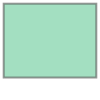

In [ ]:
polygon_square = Polygon(polygons[0])
polygon_square

In [ ]:
토지들만정렬 = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/위치데이터(.shp file)/용인시아파트토지만정렬.csv')

In [ ]:
# a = 아파트토지들 polygon tuple형태로 들어있는 리스트 
아파트토지들=[]
for j in tqdm(range(len(토지들만정렬['PYN_CN'].values))):
  b = []
  for i in range(len(eval(토지들만정렬['PYN_CN'].values[j])['coordinates'][0])):
    b.append( ( eval( 토지들만정렬['PYN_CN'].values[j] )['coordinates'][0][i][0],eval( 토지들만정렬['PYN_CN'].values[j] )['coordinates'][0][i][1] ) )
  아파트토지들.append(b)
len(아파트토지들)

100%|██████████| 1480/1480 [00:28<00:00, 51.74it/s] 


1480

In [ ]:
아파트토지들[0]

[(127.215145663581, 37.2858888306712),
 (127.215118745418, 37.2858487203357),
 (127.214889635598, 37.2860162746175),
 (127.214889601794, 37.2860162836887),
 (127.214933687933, 37.2861579272333),
 (127.214957705037, 37.286200989208),
 (127.21519840622, 37.286028899715),
 (127.215161639928, 37.285927735348),
 (127.215145663581, 37.2858888306712)]

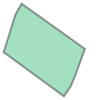

In [ ]:
Polygon(아파트토지들[0])

In [ ]:
# cell별 count와 중복되는 아파트 폴리곤만 뽑아내기 

In [ ]:
# j = cell 데이터프레임의 index번호
# i = 아파트토지들만 정렬의 index번호  

cell_index=[]

for i in tqdm(range(len(아파트토지들))):
  for j in range(len(polygons)):
    
    polygon_square = Polygon(polygons[j])  
    if polygon_square.overlaps(Polygon(아파트토지들[i])) == True:
      
      cell_index.append([i,j])
      



100%|██████████| 1480/1480 [10:30<00:00,  2.35it/s]


In [ ]:
within = cell_index
len(within) 

5553

In [ ]:
len(cell_index)

apt_idx=[]
cell_idx=[]

for i in range(len(cell_index)):
  apt_idx.append(cell_index[i][0])
for j in range(len(cell_index)):
  cell_idx.append(cell_index[j][1])

In [ ]:
len(set(apt_idx))

1276

### PNU코드 지번으로 바꾸기 

- 아파트별 경계를 폴리곤형태로 제공하는 데이터의 읍면동과 지번주소를 파악하기 위해 PNU코드를 지번으로 가공 
- 법정동코드와의 일치여부를 정규표현식 startswith로 확인 후 추출 

In [ ]:
# df_apt_idx = 아파트별 폴리곤 데이터 
df_apt_idx = df_apt_idx.drop([103, 104, 105, 106, 107, 108, 866, 1052])
df_apt_idx 

Unnamed: 0  level_0   index  BLDID_ID                  PNU  \
0              0    31090   31169     75526  4146125027103750002   
1              1    31091   31170     75526  4146125027103750010   
2              2    31092   31171     75526  4146125027103750011   
3              3    31093   31172     75529  4146125027103750006   
4              4    66626   66843     63874  4146125021101150002   
...          ...      ...     ...       ...                  ...   
1271        1475   208137  208652     25086  4146510700100960003   
1272        1476   208138  208653     25086  4146510700100960005   
1273        1477   208139  208654     25086  4146510700100960006   
1274        1478   208140  208655     25086  4146510700100960007   
1275        1479   208141  208656     25086  4146510700100960008   

                                                 PYN_CN SCTN_CD         LA  \
0     {"type": "Polygon", "coordinates": [[[127.2151...       l  37.286025   
1     {"type": "Polygon", "coordinates": [[[127.2149...       l  37.285809   
2     {"type": "Polygon", "coordinates": [[[127.2147...       l  37.286003   
3     {"type": "Polygon", "coordinates": [[[127.2144...       l  37.286389   
4     {"type": "Polygon", "coordinates": [[[127.2350...       l  37.296869   
...                                                 ...     ...        ...   
1271  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.310262   
1272  {"type": "Polygon", "coordinates": [[[127.0809...       l  37.310453   
1273  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.309871   
1274  {"type": "Polygon", "coordinates": [[[127.0807...       l  37.310095   
1275  {"type": "Polygon", "coordinates": [[[127.0810...       l  37.309910   

              LO  UFID  
0     127.215044   NaN  
1     127.214861   NaN  
2     127.214605   NaN  
3     127.214296   NaN  
4     127.234921   NaN  
...          ...   ...  
1271  127.080135   NaN  
1272  127.080587   NaN  
1273  127.080385   NaN  
1274  127.080884   NaN  
1275  127.081134   NaN  

[1268 rows x 10 columns]

In [ ]:
# 지번데이터 불러오기 
import pandas as pd
지번txt = pd.read_csv('/content/gdrive/MyDrive/법정동코드 전체자료.txt', delimiter = '\t',encoding='cp949')
# 지번txt.loc[6338] = ['41','용인시','존재']
지번txt = 지번txt[지번txt['법정동명'].str.contains('용인시')]
지번txt = 지번txt[지번txt['폐지여부'] == '존재']
# 상세주소가 아닌 지역 drop 
지번txt = 지번txt.drop([6057,6190,6201,6211,6220,6230,6273,6286,6300,6311,6330])

지번txt

법정동코드              법정동명 폐지여부
6191  4146110100  경기도 용인시 처인구 김량장동   존재
6192  4146110200   경기도 용인시 처인구 역북동   존재
6193  4146110300   경기도 용인시 처인구 삼가동   존재
6194  4146110400    경기도 용인시 처인구 남동   존재
6195  4146110500   경기도 용인시 처인구 유방동   존재
...          ...               ...  ...
6333  4146510300   경기도 용인시 수지구 동천동   존재
6334  4146510400   경기도 용인시 수지구 고기동   존재
6335  4146510500   경기도 용인시 수지구 신봉동   존재
6336  4146510600   경기도 용인시 수지구 성복동   존재
6337  4146510700   경기도 용인시 수지구 상현동   존재

[107 rows x 3 columns]

In [ ]:
str법정동코드 = []
for i in range(len(지번txt['법정동코드'])):
  str법정동코드.append(str(지번txt['법정동코드'].values[i]))

지번txt['str법정동코드'] = str법정동코드
지번txt


법정동코드              법정동명 폐지여부    str법정동코드
6191  4146110100  경기도 용인시 처인구 김량장동   존재  4146110100
6192  4146110200   경기도 용인시 처인구 역북동   존재  4146110200
6193  4146110300   경기도 용인시 처인구 삼가동   존재  4146110300
6194  4146110400    경기도 용인시 처인구 남동   존재  4146110400
6195  4146110500   경기도 용인시 처인구 유방동   존재  4146110500
...          ...               ...  ...         ...
6333  4146510300   경기도 용인시 수지구 동천동   존재  4146510300
6334  4146510400   경기도 용인시 수지구 고기동   존재  4146510400
6335  4146510500   경기도 용인시 수지구 신봉동   존재  4146510500
6336  4146510600   경기도 용인시 수지구 성복동   존재  4146510600
6337  4146510700   경기도 용인시 수지구 상현동   존재  4146510700

[107 rows x 4 columns]

In [ ]:
strPNU = []
for i in range(len(df_apt_idx['PNU'])):
  strPNU.append(str(df_apt_idx['PNU'].values[i]))

df_apt_idx['strPNU'] = strPNU
df_apt_idx

Unnamed: 0  level_0   index  BLDID_ID                  PNU  \
0              0    31090   31169     75526  4146125027103750002   
1              1    31091   31170     75526  4146125027103750010   
2              2    31092   31171     75526  4146125027103750011   
3              3    31093   31172     75529  4146125027103750006   
4              4    66626   66843     63874  4146125021101150002   
...          ...      ...     ...       ...                  ...   
1271        1475   208137  208652     25086  4146510700100960003   
1272        1476   208138  208653     25086  4146510700100960005   
1273        1477   208139  208654     25086  4146510700100960006   
1274        1478   208140  208655     25086  4146510700100960007   
1275        1479   208141  208656     25086  4146510700100960008   

                                                 PYN_CN SCTN_CD         LA  \
0     {"type": "Polygon", "coordinates": [[[127.2151...       l  37.286025   
1     {"type": "Polygon", "coordinates": [[[127.2149...       l  37.285809   
2     {"type": "Polygon", "coordinates": [[[127.2147...       l  37.286003   
3     {"type": "Polygon", "coordinates": [[[127.2144...       l  37.286389   
4     {"type": "Polygon", "coordinates": [[[127.2350...       l  37.296869   
...                                                 ...     ...        ...   
1271  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.310262   
1272  {"type": "Polygon", "coordinates": [[[127.0809...       l  37.310453   
1273  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.309871   
1274  {"type": "Polygon", "coordinates": [[[127.0807...       l  37.310095   
1275  {"type": "Polygon", "coordinates": [[[127.0810...       l  37.309910   

              LO  UFID               strPNU  
0     127.215044   NaN  4146125027103750002  
1     127.214861   NaN  4146125027103750010  
2     127.214605   NaN  4146125027103750011  
3     127.214296   NaN  4146125027103750006  
4     127.234921   NaN  4146125021101150002  
...          ...   ...                  ...  
1271  127.080135   NaN  4146510700100960003  
1272  127.080587   NaN  4146510700100960005  
1273  127.080385   NaN  4146510700100960006  
1274  127.080884   NaN  4146510700100960007  
1275  127.081134   NaN  4146510700100960008  

[1268 rows x 11 columns]

In [ ]:
법정동 = []
idx = []
for j in range(len(df_apt_idx['strPNU'])):
  for i in range(len(지번txt['str법정동코드'])): 
    if df_apt_idx['strPNU'].values[j].startswith(지번txt['str법정동코드'].values[i]):
      법정동.append(지번txt['법정동명'].values[i]) 
      idx.append(j)
df_apt_idx['법정동'] = 법정동
df_apt_idx


Unnamed: 0  level_0   index  BLDID_ID                  PNU  \
0              0    31090   31169     75526  4146125027103750002   
1              1    31091   31170     75526  4146125027103750010   
2              2    31092   31171     75526  4146125027103750011   
3              3    31093   31172     75529  4146125027103750006   
4              4    66626   66843     63874  4146125021101150002   
...          ...      ...     ...       ...                  ...   
1271        1475   208137  208652     25086  4146510700100960003   
1272        1476   208138  208653     25086  4146510700100960005   
1273        1477   208139  208654     25086  4146510700100960006   
1274        1478   208140  208655     25086  4146510700100960007   
1275        1479   208141  208656     25086  4146510700100960008   

                                                 PYN_CN SCTN_CD         LA  \
0     {"type": "Polygon", "coordinates": [[[127.2151...       l  37.286025   
1     {"type": "Polygon", "coordinates": [[[127.2149...       l  37.285809   
2     {"type": "Polygon", "coordinates": [[[127.2147...       l  37.286003   
3     {"type": "Polygon", "coordinates": [[[127.2144...       l  37.286389   
4     {"type": "Polygon", "coordinates": [[[127.2350...       l  37.296869   
...                                                 ...     ...        ...   
1271  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.310262   
1272  {"type": "Polygon", "coordinates": [[[127.0809...       l  37.310453   
1273  {"type": "Polygon", "coordinates": [[[127.0804...       l  37.309871   
1274  {"type": "Polygon", "coordinates": [[[127.0807...       l  37.310095   
1275  {"type": "Polygon", "coordinates": [[[127.0810...       l  37.309910   

              LO  UFID               strPNU                  법정동  
0     127.215044   NaN  4146125027103750002  경기도 용인시 처인구 포곡읍 전대리  
1     127.214861   NaN  4146125027103750010  경기도 용인시 처인구 포곡읍 전대리  
2     127.214605   NaN  4146125027103750011  경기도 용인시 처인구 포곡읍 전대리  
3     127.214296   NaN  4146125027103750006  경기도 용인시 처인구 포곡읍 전대리  
4     127.234921   NaN  4146125021101150002  경기도 용인시 처인구 포곡읍 삼계리  
...          ...   ...                  ...                  ...  
1271  127.080135   NaN  4146510700100960003      경기도 용인시 수지구 상현동  
1272  127.080587   NaN  4146510700100960005      경기도 용인시 수지구 상현동  
1273  127.080385   NaN  4146510700100960006      경기도 용인시 수지구 상현동  
1274  127.080884   NaN  4146510700100960007      경기도 용인시 수지구 상현동  
1275  127.081134   NaN  4146510700100960008      경기도 용인시 수지구 상현동  

[1268 rows x 12 columns]

In [ ]:
주번_부번 = []
for i in range(len(df_apt_idx['strPNU'])):
  주번_부번.append(df_apt_idx['strPNU'].values[i][-8:])

df_apt_idx['주번_부번'] = 주번_부번
아파트정보법정동입력= df_apt_idx[['Unnamed: 0','BLDID_ID','PNU','PYN_CN','LA','LO','법정동','주번_부번']]
아파트정보법정동입력=아파트정보법정동입력.rename(columns={'Unnamed: 0':'df_apt_idx'})
아파트정보법정동입력

df_apt_idx  BLDID_ID                  PNU  \
0              0     75526  4146125027103750002   
1              1     75526  4146125027103750010   
2              2     75526  4146125027103750011   
3              3     75529  4146125027103750006   
4              4     63874  4146125021101150002   
...          ...       ...                  ...   
1271        1475     25086  4146510700100960003   
1272        1476     25086  4146510700100960005   
1273        1477     25086  4146510700100960006   
1274        1478     25086  4146510700100960007   
1275        1479     25086  4146510700100960008   

                                                 PYN_CN         LA  \
0     {"type": "Polygon", "coordinates": [[[127.2151...  37.286025   
1     {"type": "Polygon", "coordinates": [[[127.2149...  37.285809   
2     {"type": "Polygon", "coordinates": [[[127.2147...  37.286003   
3     {"type": "Polygon", "coordinates": [[[127.2144...  37.286389   
4     {"type": "Polygon", "coordinates": [[[127.2350...  37.296869   
...                                                 ...        ...   
1271  {"type": "Polygon", "coordinates": [[[127.0804...  37.310262   
1272  {"type": "Polygon", "coordinates": [[[127.0809...  37.310453   
1273  {"type": "Polygon", "coordinates": [[[127.0804...  37.309871   
1274  {"type": "Polygon", "coordinates": [[[127.0807...  37.310095   
1275  {"type": "Polygon", "coordinates": [[[127.0810...  37.309910   

              LO                  법정동     주번_부번  
0     127.215044  경기도 용인시 처인구 포곡읍 전대리  03750002  
1     127.214861  경기도 용인시 처인구 포곡읍 전대리  03750010  
2     127.214605  경기도 용인시 처인구 포곡읍 전대리  03750011  
3     127.214296  경기도 용인시 처인구 포곡읍 전대리  03750006  
4     127.234921  경기도 용인시 처인구 포곡읍 삼계리  01150002  
...          ...                  ...       ...  
1271  127.080135      경기도 용인시 수지구 상현동  00960003  
1272  127.080587      경기도 용인시 수지구 상현동  00960005  
1273  127.080385      경기도 용인시 수지구 상현동  00960006  
1274  127.080884      경기도 용인시 수지구 상현동  00960007  
1275  127.081134      경기도 용인시 수지구 상현동  00960008  

[1268 rows x 8 columns]

In [ ]:
df_cell_idx

Unnamed: 0   cell_id  cust_each_cell  cell_xcrd  cell_ycrd  \
0          10148  87910922          10.560  127.21487  37.286020   
1          10147  87910921          17.788  127.21487  37.285564   
2          10148  87910922          10.560  127.21487  37.286020   
3          10147  87910921          17.788  127.21487  37.285564   
4          10148  87910922          10.560  127.21487  37.286020   
...          ...       ...             ...        ...        ...   
5548        7679  84103214           3.801  127.08048  37.309956   
5549        1322  84119213          14.109  127.08105  37.309956   
5550        7679  84103214           3.801  127.08048  37.309956   
5551        7680  84103215          58.777  127.08048  37.310406   
5552        1322  84119213          14.109  127.08105  37.309956   

                                                 bounds count_bins  apt_idx  
0     [(37.28624482975506, 127.21515258514195), (37....        one        0  
1     [(37.285788829755056, 127.21515258342954), (37...        two        1  
2     [(37.28624482975506, 127.21515258514195), (37....        one        1  
3     [(37.285788829755056, 127.21515258342954), (37...        two        2  
4     [(37.28624482975506, 127.21515258514195), (37....        one        2  
...                                                 ...        ...      ...  
5548  [(37.31018082975476, 127.08076267508298), (37....        one     1477  
5549  [(37.31018082975476, 127.08133267508299), (37....        one     1478  
5550  [(37.31018082975476, 127.08076267508298), (37....        one     1478  
5551  [(37.310630829754764, 127.08076267677491), (37...      three     1478  
5552  [(37.31018082975476, 127.08133267508299), (37....        one     1479  

[5553 rows x 8 columns]

In [ ]:
conc = df_cell_idx[['apt_idx','cust_each_cell']] 

apt_id = list(conc['apt_idx'].drop_duplicates(keep='first'))

len(apt_id)


1276

In [ ]:
dup = conc[conc['apt_idx'] == 1478]
sum(dup['cust_each_cell'])


76.68699999999998

In [ ]:
dp=[]
for i in apt_id:
  dup = conc[conc['apt_idx'] == i]
  dp.append(sum(dup['cust_each_cell']))

len(dp)
min(dp)

3.058

In [ ]:
df_idx = pd.DataFrame([ x for x in zip(apt_id,dp)])
df_idx.columns = ['df_apt_idx', 'cust_each_cell']
df_idx

df_apt_idx  cust_each_cell
0              0          10.560
1              1          28.348
2              2          28.348
3              3         693.466
4              4          92.637
...          ...             ...
1271        1475         527.314
1272        1476          69.337
1273        1477          36.436
1274        1478          76.687
1275        1479          14.109

[1276 rows x 2 columns]

In [ ]:
법정동주소로아파트명조사 = pd.merge(아파트정보법정동입력, df_idx, on = 'df_apt_idx', how = 'left')
법정동주소로아파트명조사.to_csv('/content/gdrive/Shareddrives/전기차/data/위치데이터(.shp file)/법정동주소로아파트명조사.csv')

In [ ]:
법정동주소로아파트명조사

df_apt_idx  BLDID_ID                  PNU  \
0              0     75526  4146125027103750002   
1              1     75526  4146125027103750010   
2              2     75526  4146125027103750011   
3              3     75529  4146125027103750006   
4              4     63874  4146125021101150002   
...          ...       ...                  ...   
1263        1475     25086  4146510700100960003   
1264        1476     25086  4146510700100960005   
1265        1477     25086  4146510700100960006   
1266        1478     25086  4146510700100960007   
1267        1479     25086  4146510700100960008   

                                                 PYN_CN         LA  \
0     {"type": "Polygon", "coordinates": [[[127.2151...  37.286025   
1     {"type": "Polygon", "coordinates": [[[127.2149...  37.285809   
2     {"type": "Polygon", "coordinates": [[[127.2147...  37.286003   
3     {"type": "Polygon", "coordinates": [[[127.2144...  37.286389   
4     {"type": "Polygon", "coordinates": [[[127.2350...  37.296869   
...                                                 ...        ...   
1263  {"type": "Polygon", "coordinates": [[[127.0804...  37.310262   
1264  {"type": "Polygon", "coordinates": [[[127.0809...  37.310453   
1265  {"type": "Polygon", "coordinates": [[[127.0804...  37.309871   
1266  {"type": "Polygon", "coordinates": [[[127.0807...  37.310095   
1267  {"type": "Polygon", "coordinates": [[[127.0810...  37.309910   

              LO                  법정동     주번_부번  cust_each_cell  
0     127.215044  경기도 용인시 처인구 포곡읍 전대리  03750002          10.560  
1     127.214861  경기도 용인시 처인구 포곡읍 전대리  03750010          28.348  
2     127.214605  경기도 용인시 처인구 포곡읍 전대리  03750011          28.348  
3     127.214296  경기도 용인시 처인구 포곡읍 전대리  03750006         693.466  
4     127.234921  경기도 용인시 처인구 포곡읍 삼계리  01150002          92.637  
...          ...                  ...       ...             ...  
1263  127.080135      경기도 용인시 수지구 상현동  00960003         527.314  
1264  127.080587      경기도 용인시 수지구 상현동  00960005          69.337  
1265  127.080385      경기도 용인시 수지구 상현동  00960006          36.436  
1266  127.080884      경기도 용인시 수지구 상현동  00960007          76.687  
1267  127.081134      경기도 용인시 수지구 상현동  00960008          14.109  

[1268 rows x 9 columns]

### 용인시 행정동별 전기차 수 카운트

용인시 구별 차량대수와 전기차 대수 , 읍면동별 차량대수 데이터를 활용해서 각 구별 비율을 통해 동별 전기차대수를 추정 

2020년, 2021년 별로 추정한 전기차대수를 통해 연간 읍면동별 전기차대수 증가량을 도출 

In [ ]:
# 용인시 구별 전기차 대수 () / 용인시 구별 차량 대수 ( ) * 용인시 읍면동별 차량 대수 ( ) 
#  = 용인시 읍면동별 전기차 대수 (2020/ 2021년데이터  를 비교해서 증가량 산출 )

In [ ]:
df_ev = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/backup/경기도 전기차 수.csv', encoding='cp949')
df_ev

등록연도      시군구명            연료별   용도별   승용차수  승합차수  화물차수  특수차수
0     2020       부천시  하이브리드(휘발유+전기)   사업용     18     0     0     0
1     2020       부천시            휘발유  비사업용  52904    23   151     0
2     2020       부천시            휘발유   사업용    116     0     0     0
3     2020       부천시        휘발유(무연)  비사업용  95700    44    46     0
4     2020       부천시        휘발유(무연)   사업용    714     0     0     0
...    ...       ...            ...   ...    ...   ...   ...   ...
2588  2019  고양시 일산서구            엘피지   사업용   1543     2    78     0
2589  2019  고양시 일산서구             전기  비사업용    249     0     0     0
2590  2019  고양시 일산서구             전기   사업용      2     0     0     0
2591  2019  고양시 일산서구  하이브리드(LPG+전기)  비사업용     78     0     0     0
2592  2019  고양시 일산서구   하이브리드(경유+전기)  비사업용      1     1     0     0

[2593 rows x 8 columns]

In [ ]:
# 용인시 구별 전기차수 (2019,2020,2021)

df_ev = df_ev[(df_ev['시군구명']== '용인시 수지구') | (df_ev['시군구명']== '용인시 기흥구') |  (df_ev['시군구명']== '용인시 처인구')]

df_ev = df_ev[df_ev['연료별'] == '전기']


df_ev = df_ev[df_ev['등록연도'] > 2019]
df_ev

등록연도     시군구명 연료별   용도별  승용차수  승합차수  화물차수  특수차수
1154  2021  용인시 처인구  전기  비사업용   673     8   164     0
1155  2021  용인시 처인구  전기   사업용     5    11    79     0
1175  2021  용인시 기흥구  전기  비사업용  1167     6    80     2
1176  2021  용인시 기흥구  전기   사업용   394     7    77     0
1196  2021  용인시 수지구  전기  비사업용   995     1    29     0
1197  2021  용인시 수지구  전기   사업용     5     0    30     0
1562  2020  용인시 처인구  전기  비사업용   498     0    32     0
1563  2020  용인시 처인구  전기   사업용     1     0     8     0
1582  2020  용인시 기흥구  전기  비사업용   717     1    18     0
1583  2020  용인시 기흥구  전기   사업용     2     1     9     0
1602  2020  용인시 수지구  전기  비사업용   558     0     5     0
1603  2020  용인시 수지구  전기   사업용     1     0     7     0

In [ ]:
a= []
for i in df_ev.values:
  a.append(sum(i[-4:-1]))

df_ev['sum'] = a

In [ ]:
df_ev

등록연도     시군구명 연료별   용도별  승용차수  승합차수  화물차수  특수차수   sum
1154  2021  용인시 처인구  전기  비사업용   673     8   164     0   845
1155  2021  용인시 처인구  전기   사업용     5    11    79     0    95
1175  2021  용인시 기흥구  전기  비사업용  1167     6    80     2  1253
1176  2021  용인시 기흥구  전기   사업용   394     7    77     0   478
1196  2021  용인시 수지구  전기  비사업용   995     1    29     0  1025
1197  2021  용인시 수지구  전기   사업용     5     0    30     0    35
1562  2020  용인시 처인구  전기  비사업용   498     0    32     0   530
1563  2020  용인시 처인구  전기   사업용     1     0     8     0     9
1582  2020  용인시 기흥구  전기  비사업용   717     1    18     0   736
1583  2020  용인시 기흥구  전기   사업용     2     1     9     0    12
1602  2020  용인시 수지구  전기  비사업용   558     0     5     0   563
1603  2020  용인시 수지구  전기   사업용     1     0     7     0     8

In [ ]:
# 구별 자동차 총 등록대수 (2021 6월, 2020 6월)

# 기흥구 = 195084     192204
# 수지구 = 148693     144768
# 처인구 = 141301     135385


# 구별 전기차 수

#       2021 2020
# 기흥구 1731 571
# 수지구 1060 748
# 처인구 940  539

In [ ]:
# 구별 전체차량대비 전기차대수의 비율 

print('기흥구2021:', 1731/195084)
print('수지구2021:', 1060 / 148693)
print('처인구2021:', 940/141301)
print()
print('기흥구2020:', 571/192204)
print('수지구2020:', 748/144768)
print('처인구2020:', 539/135385)

기흥구2021: 0.008873100818109122
수지구2021: 0.00712878212155246
처인구2021: 0.006652465304562601

기흥구2020: 0.00297080185636095
수지구2020: 0.005166887709991158
처인구2020: 0.003981238689662814


In [ ]:
# 법정동별 차량대수

df_addr = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/읍면동별 총 전기 자동차 대수 모음/법정동별자동차등록대수(2020,2021) .xls - Sheet1.csv')



In [ ]:
df_addr['법정동'] = df_addr['Unnamed: 0']
df_addr['시군구'] = ''

df_addr = df_addr.drop('Unnamed: 0', axis=1)

df_addr

2021 06  2020 06    법정동 시군구
0   17305.0   16570.0   포곡읍    
1   15838.0   14785.0   모현읍    
2   12554.0   12044.0   이동읍    
3   13520.0   12958.0   남사읍    
4    5668.0    5556.0   원삼면    
5    6391.0    6236.0   백암면    
6   12444.0   11612.0   양지면    
7    9270.0    8950.0  김량장동    
8    3466.0    3310.0    남동    
9   13920.0   13345.0   역북동    
10   6541.0    6371.0   삼가동    
11   5891.0    5767.0   유방동    
12  11700.0   11188.0   고림동    
13   5445.0    5422.0   마평동    
14    807.0     754.0   운학동    
15    361.0     351.0    호동    
16    180.0     166.0   해곡동    
17      NaN       NaN   NaN    
18  16276.0   16098.0   신갈동    
19  23924.0   24485.0   영덕동    
20   3053.0    3191.0   하갈동    
21  17899.0   17216.0   구갈동    
22   5397.0    5279.0   상갈동    
23  12539.0   12401.0   보라동    
24   2681.0    2497.0   지곡동    
25   7733.0    7424.0   공세동    
26   3034.0    2884.0   고매동    
27   2029.0    1804.0   농서동    
28   9072.0    8918.0   서천동    
29   9325.0    9221.0   언남동    
30   7027.0    6974.0   청덕동    
31  13208.0   13046.0   마북동    
32  13924.0   13578.0   동백동    
33  20463.0   19880.0    중동    
34  11074.0   10958.0   상하동    
35  16426.0   16350.0   보정동    
36      NaN       NaN   NaN    
37  28455.0   28283.0  풍덕천동    
38  15465.0   15200.0   신봉동    
39  28129.0   27870.0   죽전동    
40  19575.0   19134.0   동천동    
41   1976.0    1804.0   고기동    
42  32533.0   32009.0   상현동    
43  22560.0   20468.0   성복동

In [ ]:
for i in range(17):
  df_addr['시군구'][i] = '용인시 처인구'

for i in range(18,36):
  df_addr['시군구'][i] = '용인시 기흥구'

for i in range(37,44):
  df_addr['시군구'][i] = '용인시 수지구'

df_addr = df_addr.dropna()
df_addr = df_addr.reset_index()
df_addr = df_addr.drop('index',axis=1)
df_addr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2021 06  2020 06    법정동      시군구
0   17305.0   16570.0   포곡읍  용인시 처인구
1   15838.0   14785.0   모현읍  용인시 처인구
2   12554.0   12044.0   이동읍  용인시 처인구
3   13520.0   12958.0   남사읍  용인시 처인구
4    5668.0    5556.0   원삼면  용인시 처인구
5    6391.0    6236.0   백암면  용인시 처인구
6   12444.0   11612.0   양지면  용인시 처인구
7    9270.0    8950.0  김량장동  용인시 처인구
8    3466.0    3310.0    남동  용인시 처인구
9   13920.0   13345.0   역북동  용인시 처인구
10   6541.0    6371.0   삼가동  용인시 처인구
11   5891.0    5767.0   유방동  용인시 처인구
12  11700.0   11188.0   고림동  용인시 처인구
13   5445.0    5422.0   마평동  용인시 처인구
14    807.0     754.0   운학동  용인시 처인구
15    361.0     351.0    호동  용인시 처인구
16    180.0     166.0   해곡동  용인시 처인구
17  16276.0   16098.0   신갈동  용인시 기흥구
18  23924.0   24485.0   영덕동  용인시 기흥구
19   3053.0    3191.0   하갈동  용인시 기흥구
20  17899.0   17216.0   구갈동  용인시 기흥구
21   5397.0    5279.0   상갈동  용인시 기흥구
22  12539.0   12401.0   보라동  용인시 기흥구
23   2681.0    2497.0   지곡동  용인시 기흥구
24   7733.0    7424.0   공세동  용인시 기흥구
25   3034.0    2884.0   고매동  용인시 기흥구
26   2029.0    1804.0   농서동  용인시 기흥구
27   9072.0    8918.0   서천동  용인시 기흥구
28   9325.0    9221.0   언남동  용인시 기흥구
29   7027.0    6974.0   청덕동  용인시 기흥구
30  13208.0   13046.0   마북동  용인시 기흥구
31  13924.0   13578.0   동백동  용인시 기흥구
32  20463.0   19880.0    중동  용인시 기흥구
33  11074.0   10958.0   상하동  용인시 기흥구
34  16426.0   16350.0   보정동  용인시 기흥구
35  28455.0   28283.0  풍덕천동  용인시 수지구
36  15465.0   15200.0   신봉동  용인시 수지구
37  28129.0   27870.0   죽전동  용인시 수지구
38  19575.0   19134.0   동천동  용인시 수지구
39   1976.0    1804.0   고기동  용인시 수지구
40  32533.0   32009.0   상현동  용인시 수지구
41  22560.0   20468.0   성복동  용인시 수지구

In [ ]:
# 시군구 전기차 비율 

기흥구_2021 = 1731/195084
수지구_2021= 1060 / 148693
처인구_2021= 940/141301

기흥구_2020= 571/192204
수지구_2020= 748/144768
처인구_2020= 539/135385

In [ ]:
#2021 동별 전기차 

처인구동별전기차대수 = []
for i in range(len(df_addr[df_addr['시군구'] == '용인시 처인구'].values)):
  처인구동별전기차대수.append( (df_addr[df_addr['시군구'] == '용인시 처인구'].values[i][0] ) * (처인구_2021) )

기흥구동별전기차대수 = []
for i in range(len(df_addr[df_addr['시군구'] == '용인시 기흥구'].values)):
  기흥구동별전기차대수.append( (df_addr[df_addr['시군구'] == '용인시 기흥구'].values[i][0] ) * (기흥구_2021) )

수지구동별전기차대수 = []
for i in range(len(df_addr[df_addr['시군구'] == '용인시 수지구'].values)):
  기흥구동별전기차대수.append( (df_addr[df_addr['시군구'] == '용인시 수지구'].values[i][0] ) * (수지구_2021) )

In [ ]:
동별전기차대수 = 처인구동별전기차대수 + 기흥구동별전기차대수 + 수지구동별전기차대수 

df_addr['2021동별전기차대수'] = 동별전기차대수

In [ ]:
처인구동별전기차대수 = []
for i in range(len(df_addr[df_addr['시군구'] == '용인시 처인구'].values)):
  처인구동별전기차대수.append( (df_addr[df_addr['시군구'] == '용인시 처인구'].values[i][1] ) * (처인구_2020) )

기흥구동별전기차대수 = []
for i in range(len(df_addr[df_addr['시군구'] == '용인시 기흥구'].values)):
  기흥구동별전기차대수.append( (df_addr[df_addr['시군구'] == '용인시 기흥구'].values[i][1] ) * (기흥구_2020) )

수지구동별전기차대수 = []
for i in range(len(df_addr[df_addr['시군구'] == '용인시 수지구'].values)):
  기흥구동별전기차대수.append( (df_addr[df_addr['시군구'] == '용인시 수지구'].values[i][1] ) * (수지구_2020) )

In [ ]:
동별전기차대수 = 처인구동별전기차대수 + 기흥구동별전기차대수 + 수지구동별전기차대수 

df_addr['2020동별전기차대수'] = 동별전기차대수

In [ ]:
증감량 = []
for i,j in zip(df_addr['2020동별전기차대수'], df_addr['2021동별전기차대수']):
  증감량.append(j - i)

df_addr['증감량'] = 증감량

In [ ]:
# 법정동별 전기차대수와 증감량 데이터 
df_addr= df_addr[['시군구','법정동','2020동별전기차대수','2021동별전기차대수','증감량']]
df_addr

시군구   법정동  2020동별전기차대수  2021동별전기차대수         증감량
0   용인시 처인구   포곡읍    65.969125   115.120912   49.151787
1   용인시 처인구   모현읍    58.862614   105.361745   46.499131
2   용인시 처인구   이동읍    47.950039    83.515049   35.565011
3   용인시 처인구   남사읍    51.588891    89.941331   38.352440
4   용인시 처인구   원삼면    22.119762    37.706173   15.586411
5   용인시 처인구   백암면    24.827004    42.515906   17.688901
6   용인시 처인구   양지면    46.230144    82.783278   36.553135
7   용인시 처인구  김량장동    35.632086    61.668353   26.036267
8   용인시 처인구    남동    13.177900    23.057445    9.879545
9   용인시 처인구   역북동    53.129630    92.602317   39.472687
10  용인시 처인구   삼가동    25.364472    43.513776   18.149304
11  용인시 처인구   유방동    22.959804    39.189673   16.229870
12  용인시 처인구   고림동    44.542098    77.833844   33.291746
13  용인시 처인구   마평동    21.586276    36.222674   14.636397
14  용인시 처인구   운학동     3.001854     5.368540    2.366686
15  용인시 처인구    호동     1.397415     2.401540    1.004125
16  용인시 처인구   해곡동     0.660886     1.197444    0.536558
17  용인시 기흥구   신갈동    47.823968   144.418589   96.594621
18  용인시 기흥구   영덕동    72.740083   212.280064  139.539981
19  용인시 기흥구   하갈동     9.479829    27.089577   17.609748
20  용인시 기흥구   구갈동    51.145325   158.819632  107.674307
21  용인시 기흥구   상갈동    15.682863    47.888125   32.205262
22  용인시 기흥구   보라동    36.840914   111.259811   74.418897
23  용인시 기흥구   지곡동     7.418092    23.788783   16.370691
24  용인시 기흥구   공세동    22.055233    68.615689   46.560456
25  용인시 기흥구   고매동     8.567793    26.920988   18.353195
26  용인시 기흥구   농서동     5.359327    18.003522   12.644195
27  용인시 기흥구   서천동    26.493611    80.496771   54.003160
28  용인시 기흥구   언남동    27.393764    82.741665   55.347901
29  용인시 기흥구   청덕동    20.718372    62.351279   41.632907
30  용인시 기흥구   마북동    38.757081   117.195916   78.438835
31  용인시 기흥구   동백동    40.337548   123.549056   83.211508
32  용인시 기흥구    중동    59.059541   181.570262  122.510721
33  용인시 기흥구   상하동    32.554047    98.260718   65.706672
34  용인시 기흥구   보정동    48.572610   145.749554   97.176944
35  용인시 수지구  풍덕천동   146.135085   202.849495   56.714410
36  용인시 수지구   신봉동    78.536693   110.246616   31.709922
37  용인시 수지구   죽전동   144.001160   200.525512   56.524352
38  용인시 수지구   동천동    98.863229   139.545910   40.682681
39  용인시 수지구   고기동     9.321065    14.086473    4.765408
40  용인시 수지구   상현동   165.386909   231.920669   66.533760
41  용인시 수지구   성복동   105.755858   160.825325   55.069467

In [ ]:
# df_addr.to_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/읍면동별.../법정동전기차대수(2020,2021).csv')

### 데이터 로드해서 회귀분석 1 (거주지 읍면동별 수요지수 도출) + 거주지 읍면동별 수요지수 계산

거주지 읍면동별 현재수요(count_cust)와 잠재수요에 대한 회귀를 통해 거주지의 읍면동별 수요지수 도출  

잠재수요 Y (읍면동별 전기차 증가량) 과 Xs (거주인구수	1인가구 수	면적당 아파트 가격	공시지가	학원 수	보육시설 대비 아동 수	차량수	유소년	연봉)과의 회귀를 통해 주요영향변수를 도출하고 도출된 변수를 바탕으로 각 변수를 가중치로 사용하는 잠재수요지수 계산식 도출 

In [ ]:
# 거주지 완속 현재 + / 잠재수요 회귀 

In [ ]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
df_res = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/거주지수요지수산출용 (1) -2.csv')
df_res = df_res[['행정동','거주인구수'	,'1인가구 수'	,'면적당 아파트 가격',	'공시지가',	'학원 수',	'보육시설 대비 아동 수',	'차량수',	'유소년'	,'연봉'	,'전기차증가량']]
df_res

행정동  거주인구수  1인가구 수  면적당 아파트 가격        공시지가  학원 수  보육시설 대비 아동 수  \
0     동천동  50740   19496  7824870.05   966606.48   142         74.00   
1   풍덕천1동  36470   15865  7920457.43  2222995.82   106         40.70   
2   풍덕천2동  41131   14954  8827759.42  2282322.31   251         56.54   
3     신봉동  38413   13977  6449613.79  1103420.09   168         46.68   
4    죽전1동  57037   21372  5851875.46  1988940.69   229         45.36   
5    죽전2동  18385    7724  7481606.40  2283492.96    50         44.18   
6     성복동  54775   18816  5634161.23  1151700.32   110        106.52   
7    상현1동  48165   17828  6711425.52  2474067.92   143         59.22   
8    상현2동  33088   11493  5975016.35  1702908.45   160         55.47   
9    동백2동  27170    9362  4438707.94  1262682.36   163         36.31   
10   영덕1동  30459   11801  6005265.43  1471318.97   111         36.43   
11    보라동  33347   12449  3179512.37   917883.11   110         31.23   
12    서농동  26838   11951  5724221.72  1232486.93    79         52.55   
13    보정동  36153   13324  6605142.24  1784706.41   205         48.59   
14   동백1동  32692   11652  4685954.98   877001.53   121         35.20   
15    상갈동  13444    6203  4537173.70  1500272.77    32         33.35   
16   영덕2동  17559    7229  3639057.97  1005720.21    28         51.87   
17    신갈동  38797   16130  5455001.42  1474183.80    91         55.86   
18    상하동  24411    9184  3211004.64   875345.27    44         37.85   
19    기흥동  21785    9094  2954391.29   879569.61    38         33.34   
20    구갈동  42366   18147  6747448.62  1894991.53   143         72.19   
21    구성동  40325   15539  4124207.02  1258053.50   121         36.31   
22   동백3동  26835    9945  4987498.09  1269927.40    41         67.00   
23    마북동  32135   12428  5220523.10  1389063.70    86         38.89   
24    원삼면   8644    4017  1470847.80   243011.44     6         35.75   
25    백암면   9282    4931  1617172.54   210084.47    10         27.00   
26    양지면  20665    9340  2442638.69   362510.06    44         43.64   
27    이동읍  21600    9143  2248575.40   348714.37    33         33.42   
28    모현읍  28324   12431  2880359.08   517299.11    51         39.48   
29    동부동  13937    6056  2472001.25   590412.14    32         22.47   
30    남사읍  24738    9900  4177460.06   169750.00    38         90.95   
31    포곡읍  34282   14681  2451552.70   537189.01    81         32.44   
32    중앙동  26934   12403  3204758.52  1018475.33    64         63.46   
33    유림동  36855   14418  2548811.36   710730.73    51         43.54   
34    역삼동  45163   18776  4353967.15  1155623.92   135         61.46   

             차량수   유소년       연봉      전기차증가량  
0   21551.000000  8225  3409.50   45.448089  
1   13372.944290  4498  3306.00   26.653968  
2   15082.055710  7894  3306.00   30.060443  
3   15465.000000  6759  3315.00   31.709922  
4   21272.225250  8440  3363.00   42.745876  
5    6856.774747  2209  3363.00   13.778476  
6   22560.000000  9568  3416.00   55.069467  
7   19284.850340  8196  3643.00   39.439757  
8   13248.149660  5607  3643.00   27.094003  
9   10776.552710  5110  3449.00   64.471354  
10  17112.175500  5206  3945.00   99.683943  
11  15220.000000  5252  3553.50   90.789588  
12  11101.000000  4503  3467.50   66.647355  
13  16426.000000  5789  3522.00   97.176944  
14  12966.767060  6445  3417.00   77.574439  
15   5397.000000  1506  3455.00   32.205262  
16   9864.824503  2525  3839.50   57.465785  
17  16276.000000  5138  3399.00   96.594621  
18  11074.000000  3216  3405.00   65.706672  
19  10767.000000  2967  3848.00   64.913651  
20  17899.000000  5824  3596.00  107.674307  
21  16352.000000  5998  3400.00   96.980809  
22  10643.680230  5391  3433.00   63.676437  
23  13208.000000  4117  3594.00   78.438835  
24   5668.000000   634  3611.00   15.586411  
25   6391.000000   459  3606.00   17.688901  
26  12444.000000  2233  3629.00   36.553135  
27  12554.000000  2425  3651.00   35.565011  
28  15838.000000  3290  3396.00   46.499131  
29   6793.000000  1264  3781.75  

In [ ]:
# 행정동명을 제거한 테이블 만들고 
df_res = df_res.drop(['행정동'],axis=1,inplace=False)

In [ ]:
# 클러스터링에서 나온 결과동만 추리기
# ['포곡읍','역삼동','신갈동','구갈동','구성동','보정동','죽전1동','동천동','상현1동','성복동']
# df_res = df_res[(df_res['행정동'] == '포곡읍') | (df_res['행정동'] == '역삼동') | (df_res['행정동'] == '신갈동') | (df_res['행정동'] == '구갈동') | (df_res['행정동'] == '구성동') | (df_res['행정동'] == '보정동') | (df_res['행정동'] == '죽전1동') | (df_res['행정동'] == '동천동') | (df_res['행정동'] == '상현1동') |(df_res['행정동'] == '성복동')]
# df_res

In [ ]:
# data scaling

# min-max scale
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
scaled = minMaxScaler.fit_transform(df_res)
columns = df_res.columns
df_scaled = pd.DataFrame(scaled,columns=columns)
df_scaled

거주인구수    1인가구 수  면적당 아파트 가격      공시지가      학원 수  보육시설 대비 아동 수  \
0   0.869878  0.891904    0.863681  0.345810  0.555102      0.613087   
1   0.575001  0.682685    0.876674  0.891043  0.408163      0.216895   
2   0.671316  0.630193    1.000000  0.916789  1.000000      0.405354   
3   0.615151  0.573898    0.676747  0.405183  0.661224      0.288043   
4   1.000000  1.000000    0.595498  0.789470  0.910204      0.272338   
5   0.201289  0.213598    0.817022  0.917297  0.179592      0.258299   
6   0.953258  0.852723    0.565905  0.426135  0.424490      1.000000   
7   0.816668  0.795794    0.712334  1.000000  0.559184      0.437240   
8   0.505114  0.430769    0.612236  0.665342  0.628571      0.392623   
9   0.382824  0.307980    0.403411  0.474298  0.640816      0.164664   
10  0.450788  0.448516    0.616348  0.564839  0.428571      0.166092   
11  0.510466  0.485854    0.232253  0.324666  0.424490      0.104224   
12  0.375963  0.457159    0.578147  0.461194  0.297959      0.357882   
13  0.568450  0.536272    0.697887  0.700839  0.812245      0.310767   
14  0.496931  0.439931    0.437019  0.306924  0.469388      0.151457   
15  0.099188  0.125958    0.416795  0.577404  0.106122      0.129447   
16  0.184221  0.185076    0.294717  0.362784  0.089796      0.349792   
17  0.623086  0.697954    0.541552  0.566082  0.346939      0.397264   
18  0.325812  0.297724    0.236534  0.306206  0.155102      0.182986   
19  0.271548  0.292538    0.201653  0.308039  0.130612      0.129328   
20  0.696836  0.814175    0.717230  0.748699  0.559184      0.591553   
21  0.654661  0.663901    0.360662  0.472289  0.469388      0.164664   
22  0.375901  0.341573    0.478006  0.477442  0.142857      0.529804   
23  0.485421  0.484644    0.509681  0.529143  0.326531      0.195360   
24  0.000000  0.000000    0.000000  0.031793  0.000000      0.158001   
25  0.013184  0.052665    0.019889  0.017504  0.016327      0.053896   
26  0.248404  0.306713    0.132092  0.083652  0.155102      0.251874   
27  0.267725  0.295362    0.105714  0.077665  0.110204      0.130280   
28  0.406670  0.484817    0.191590  0.150825  0.183673      0.202380   
29  0.109375  0.117488    0.136083  0.182554  0.106122      0.000000   
30  0.332569  0.338980    0.367901  0.000000  0.130612      0.814753   
31  0.529787  0.614463    0.133304  0.159457  0.306122      0.118620   
32  0.377947  0.483204    0.235685  0.368320  0.236735      0.487686   
33  0.582956  0.599309    0.146524  0.234768  0.183673      0.250684   
34  0.754634  0.850418    0.391893  0.427838  0.526531      0.463891   

         차량수       유소년        연봉    전기차증가량  
0   0.941211  0.852563  0.161972  0.337285  
1   0.464717  0.443408  0.000000  0.137125  
2   0.564299  0.816226  0.000000  0.173405  
3   0.586611  0.691624  0.014085  0.190972  
4   0.924968  0.876166  0.089202  0.308506  
5   0.085054  0.192118  0.089202  0.000000  
6   1.000000  1.000000  0.172144  0.439753  
7   0.809174  0.849380  0.527387  0.273295  
8   0.457446  0.565155  0.527387  0.141812  
9   0.313439  0.510594  0.223787  0.539884  
10  0.682583  0.521133  1.000000  0.914902  
11  0.572336  0.526183  0.387324  0.820176  
12  0.332343  0.443957  0.252739  0.563059  
13  0.642603  0.585136  0.338028  0.888202  
14  0.441052  0.657152  0.173709  0.679433  
15  0.000000  0.114941  0.233177  0.196247  
16  0.260317  0.226809  0.834898  0.465274  
17  0.633864  0.513668  0.145540  0.882000  
18  0.330770  0.302668  0.154930  0.553040  
19  0.312882  0.275332  0.848200  0.544595  
20  0.728427  0.588978  0.453834  1.000000  
21  0.638292  0.608080  0.147105  0.886113  
22  0.305697  0.541443  0.198748  0.531418  
23  0.455107  0.401581  0.450704  0.688639  
24  0.015790  0.019212  0.477308  0.019255  
25  0.057915  0.000000  0.469484  0.041646  
26  0.410593  0.194752  0.505477  0.242552  
27  0.417002  0.215830  0.539906  0.232029  
28  0.608344  0.310792  0.140845  0.348478  
29  0.081338  0.088374  0.744523  0.050751  
30  0.473286  0.470

In [ ]:
#종속변수와 독립변수들간의 상관관계 확인 
df_scaled.corr()

거주인구수    1인가구 수  면적당 아파트 가격      공시지가      학원 수  \
거주인구수         1.000000  0.975580    0.585730  0.491586  0.761436   
1인가구 수        0.975580  1.000000    0.551112  0.468598  0.695541   
면적당 아파트 가격    0.585730  0.551112    1.000000  0.840942  0.701685   
공시지가          0.491586  0.468598    0.840942  1.000000  0.641549   
학원 수          0.761436  0.695541    0.701685  0.641549  1.000000   
보육시설 대비 아동 수  0.510602  0.488697    0.422482  0.171936  0.220732   
차량수           0.935496  0.934772    0.389569  0.260774  0.622401   
유소년           0.942249  0.866496    0.640893  0.485094  0.794411   
연봉           -0.384148 -0.395265   -0.346606 -0.287211 -0.358095   
전기차증가량        0.340097  0.339916    0.125048  0.145462  0.258944   

              보육시설 대비 아동 수       차량수       유소년        연봉    전기차증가량  
거주인구수             0.510602  0.935496  0.942249 -0.384148  0.340097  
1인가구 수            0.488697  0.934772  0.866496 -0.395265  0.339916  
면적당 아파트 가격        0.422482  0.389569  0.640893 -0.346606  0.125048  
공시지가              0.171936  0.260774  0.485094 -0.287211  0.145462  
학원 수              0.220732  0.622401  0.794411 -0.358095  0.258944  
보육시설 대비 아동 수      1.000000  0.505076  0.570532 -0.135615  0.066788  
차량수               0.505076  1.000000  0.855031 -0.203809  0.393200  
유소년               0.570532  0.855031  1.000000 -0.324546  0.333009  
연봉               -0.135615 -0.203809 -0.324546  1.000000  0.115550  
전기차증가량            0.066788  0.393200  0.333009  0.115550  1.000000

In [ ]:
y_target = df_scaled['전기차증가량']
X_data = df_scaled.drop(['전기차증가량'], axis=1, inplace=False)

In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [ ]:
# 고려한 모델들  
lr_reg = LinearRegression()
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=100)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=100)
xgb_reg = XGBRegressor(n_estimators=100)
lgb_reg = LGBMRegressor(n_estimators=100)

In [ ]:
# 모델별로 5번 cross_val해서 평균 낸 RMSE
models = [lr_reg,dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  LinearRegression  #####
 5 교차 검증의 평균 RMSE : 0.462 
#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 0.386 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 0.289 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 0.309 
[20:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 0.312 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 0.297 


#### model 별 feature importance 시각화

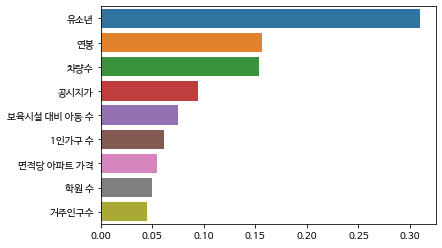

In [ ]:
import seaborn as sns
%matplotlib inline

# Random Forest Regressor 

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습   
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
#Permutation importance of RF

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_reg,random_state=0).fit(X_data,y_target)
eli5.show_weights(perm, feature_names = X_data.columns.tolist())

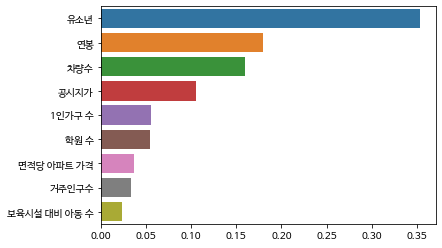

In [ ]:
# GB regressor 

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
gb_reg.fit(X_data, y_target)

feature_series = pd.Series(data=gb_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
#Permutation importance of GB
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(gb_reg,random_state=0).fit(X_data,y_target)
eli5.show_weights(perm, feature_names = X_data.columns.tolist())

[20:17:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


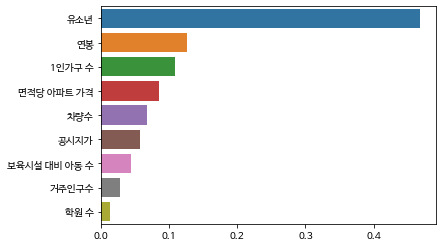

In [ ]:
# XGB regressor 

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
xgb_reg.fit(X_data, y_target)

feature_series = pd.Series(data=xgb_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
#Permutation importance of XGB
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_reg,random_state=0).fit(X_data,y_target)
eli5.show_weights(perm, feature_names = X_data.columns.tolist())

#### 거주지 읍면동별 수요지수 계산 


In [ ]:
# feature importance 기반으로 점수식 만들기

# 유소년 / 연봉 / 차량수 세가지 고려

# 0.3829 / 0.3829	유소년
# 0.2023 / 0.3829	연봉
# 0.1287 / 0.3829	차량수

유소년w = 0.3829 / 0.3829
연봉w = 0.2023 / 0.3829
차량수w = 0.1287 / 0.3829

In [ ]:
# 데이터프레임에서 세가지 변수만 추출
df_수요지수 = df_scaled[['유소년','연봉','차량수']]
# df_수요지수[['유소년']] * (유소년w) * 1 + df_수요지수[['연봉']] *  (연봉w) * 1 + df_수요지수[['차량수']] * 차량수w * 1

유소년w = 0.3829 / 0.3829
연봉w = 0.2023 / 0.3829
차량수w = 0.1287 / 0.3829

잠재수요지수 = []
for i in range(len(df_수요지수)):
  잠재수요지수.append( ( df_수요지수.values[i][0] * 유소년w ) + ( df_수요지수.values[i][1] * 연봉w ) + ( df_수요지수.values[i][2] * 차량수w ) )

len(잠재수요지수)

35

In [ ]:
df_수요지수['잠재수요지수'] = 잠재수요지수
df_res = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/거주지수요지수산출용 (1) -2.csv')


df_수요지수['행정동'] = df_res['행정동']


df_수요지수

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


유소년        연봉       차량수    잠재수요지수    행정동
0   0.852563  0.161972  0.941211  1.254498    동천동
1   0.443408  0.000000  0.464717  0.599608  풍덕천1동
2   0.816226  0.000000  0.564299  1.005897  풍덕천2동
3   0.691624  0.014085  0.586611  0.896236    신봉동
4   0.876166  0.089202  0.924968  1.234194   죽전1동
5   0.192118  0.089202  0.085054  0.267834   죽전2동
6   1.000000  0.172144  1.000000  1.427069    성복동
7   0.849380  0.527387  0.809174  1.399996   상현1동
8   0.565155  0.527387  0.457446  0.997549   상현2동
9   0.510594  0.223787  0.313439  0.734182   동백2동
10  0.521133  1.000000  0.682583  1.278899   영덕1동
11  0.526183  0.387324  0.572336  0.923193    보라동
12  0.443957  0.252739  0.332343  0.689194    서농동
13  0.585136  0.338028  0.642603  0.979719    보정동
14  0.657152  0.173709  0.441052  0.897175   동백1동
15  0.114941  0.233177  0.000000  0.238137    상갈동
16  0.226809  0.834898  0.260317  0.755413   영덕2동
17  0.513668  0.145540  0.633864  0.803615    신갈동
18  0.302668  0.154930  0.330770  0.495701    상하동
19  0.275332  0.848200  0.312882  0.828633    기흥동
20  0.588978  0.453834  0.728427  1.073593    구갈동
21  0.608080  0.147105  0.638292  0.900343    구성동
22  0.541443  0.198748  0.305697  0.749199   동백3동
23  0.401581  0.450704  0.455107  0.792674    마북동
24  0.019212  0.477308  0.015790  0.276698    원삼면
25  0.000000  0.469484  0.057915  0.267512    백암면
26  0.194752  0.505477  0.410593  0.599822    양지면
27  0.215830  0.539906  0.417002  0.641245    이동읍
28  0.310792  0.140845  0.608344  0.589681    모현읍
29  0.088374  0.744523  0.081338  0.509072    동부동
30  0.470963  0.641628  0.473286  0.969038    남사읍
31  0.405313  0.139280  0.693818  0.712106    포곡읍
32  0.246679  0.063380  0.427606  0.423892    중앙동
33  0.540015  0.351487  0.710482  0.964525    유림동
34  0.730596  0.374022  0.877702  1.223218    역삼동

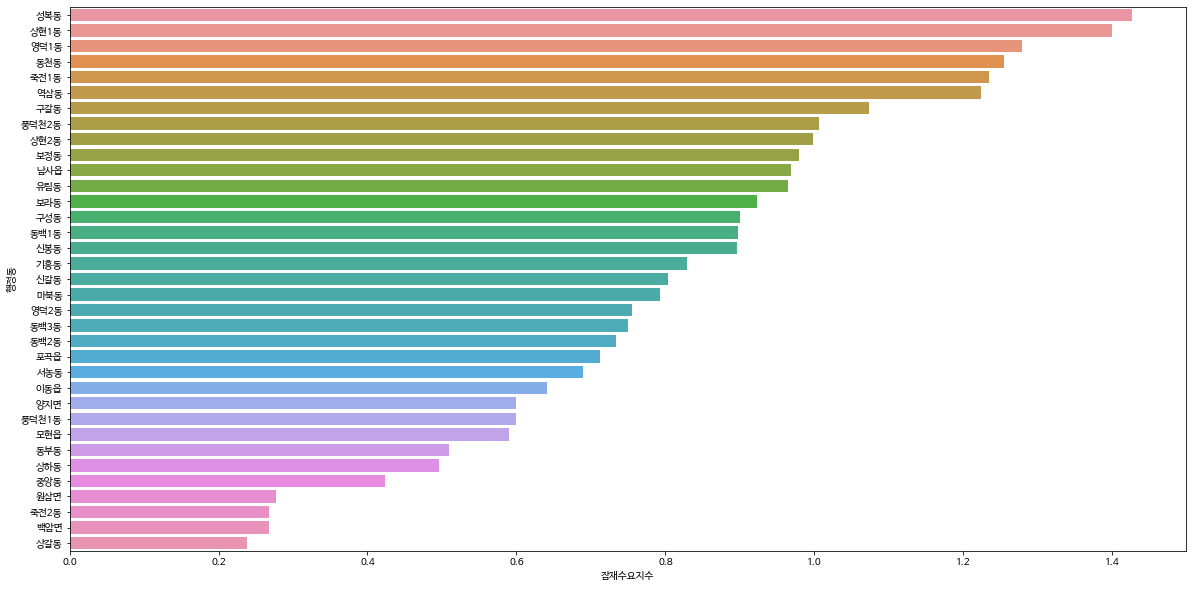

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
순위대로정렬 = df_수요지수.sort_values('잠재수요지수', ascending=False)

sns.barplot(x=순위대로정렬['잠재수요지수'], y=순위대로정렬['행정동'])

In [ ]:
# count_cust 현재수요 합치기
import pandas as pd
df_현재수요 = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/읍면동 빅콘count모음/읍면동별count_cust빅콘1번.csv')
df_현재수요

Unnamed: 0    행정동  cust_each_cell
0           11    성복동      103420.254
1            2   죽전1동       98960.946
2            5    동천동       95293.624
3            3    역삼동       83327.567
4           14   상현1동       80829.972
5            6    구갈동       76355.630
6           13    신봉동       73854.709
7           15  풍덕천2동       71517.848
8            7    구성동       70373.600
9           20  풍덕천1동       67523.901
10          10    보라동       66974.472
11          12    신갈동       66949.827
12          27   상현2동       65324.381
13           8    유림동       61571.031
14          16    마북동       60651.371
15           0    포곡읍       59914.552
16           1    모현읍       59136.142
17           4    보정동       58536.926
18          18   동백1동       58422.144
19          25    상하동       53582.543
20          23   동백2동       44339.944
21          17   영덕1동       43490.345
22          19    중앙동       42238.038
23           9    양지면       40140.253
24          26   영덕2동       39286.576
25          30   동백3동       38931.272
26          29   죽전2동       38315.322
27          24    남사읍       32876.348
28          21    이동읍       32651.623
29          28    서농동       32442.825
30          32    상갈동       26605.000
31          22    기흥동       26240.418
32          31    동부동       19365.800
33          33    원삼면       19189.782
34          34    백암면        8487.501

In [ ]:
df_거주지수요지수 = pd.merge(df_현재수요, df_수요지수, on = '행정동', how = 'right')
df_거주지수요지수 = df_거주지수요지수.rename(columns = {'cust_each_cell':'현재수요count'})
df_거주지수요지수 = df_거주지수요지수[['행정동','유소년','연봉','차량수','현재수요count','잠재수요지수']]

#현재수요 min_max scaling 


minMaxScaler = MinMaxScaler()
scaled_count = minMaxScaler.fit_transform(df_거주지수요지수[['현재수요count']])
df_거주지수요지수['현재수요지수'] = scaled_count
df_거주지수요지수




행정동       유소년        연봉       차량수   현재수요count    잠재수요지수    현재수요지수
0     동천동  0.852563  0.161972  0.941211   95293.624  1.254498  0.914396
1   풍덕천1동  0.443408  0.000000  0.464717   67523.901  0.599608  0.621876
2   풍덕천2동  0.816226  0.000000  0.564299   71517.848  1.005897  0.663947
3     신봉동  0.691624  0.014085  0.586611   73854.709  0.896236  0.688563
4    죽전1동  0.876166  0.089202  0.924968   98960.946  1.234194  0.953027
5    죽전2동  0.192118  0.089202  0.085054   38315.322  0.267834  0.314199
6     성복동  1.000000  0.172144  1.000000  103420.254  1.427069  1.000000
7    상현1동  0.849380  0.527387  0.809174   80829.972  1.399996  0.762039
8    상현2동  0.565155  0.527387  0.457446   65324.381  0.997549  0.598707
9    동백2동  0.510594  0.223787  0.313439   44339.944  0.734182  0.377661
10   영덕1동  0.521133  1.000000  0.682583   43490.345  1.278899  0.368712
11    보라동  0.526183  0.387324  0.572336   66974.472  0.923193  0.616088
12    서농동  0.443957  0.252739  0.332343   32442.825  0.689194  0.252340
13    보정동  0.585136  0.338028  0.642603   58536.926  0.979719  0.527209
14   동백1동  0.657152  0.173709  0.441052   58422.144  0.897175  0.526000
15    상갈동  0.114941  0.233177  0.000000   26605.000  0.238137  0.190846
16   영덕2동  0.226809  0.834898  0.260317   39286.576  0.755413  0.324430
17    신갈동  0.513668  0.145540  0.633864   66949.827  0.803615  0.615829
18    상하동  0.302668  0.154930  0.330770   53582.543  0.495701  0.475021
19    기흥동  0.275332  0.848200  0.312882   26240.418  0.828633  0.187005
20    구갈동  0.588978  0.453834  0.728427   76355.630  1.073593  0.714907
21    구성동  0.608080  0.147105  0.638292   70373.600  0.900343  0.651894
22   동백3동  0.541443  0.198748  0.305697   38931.272  0.749199  0.320688
23    마북동  0.401581  0.450704  0.455107   60651.371  0.792674  0.549482
24    원삼면  0.019212  0.477308  0.015790   19189.782  0.276698  0.112735
25    백암면  0.000000  0.469484  0.057915    8487.501  0.267512  0.000000
26    양지면  0.194752  0.505477  0.410593   40140.253  0.599822  0.333423
27    이동읍  0.215830  0.539906  0.417002   32651.623  0.641245  0.254539
28    모현읍  0.310792  0.140845  0.608344   59136.142  0.589681  0.533521
29    동부동  0.088374  0.744523  0.081338   19365.800  0.509072  0.114590
30    남사읍  0.470963  0.641628  0.473286   32876.348  0.969038  0.256907
31    포곡읍  0.405313  0.139280  0.693818   59914.552  0.712106  0.541721
32    중앙동  0.246679  0.063380  0.427606   42238.038  0.423892  0.355520
33    유림동  0.540015  0.351487  0.710482   61571.031  0.964525  0.559170
34    역삼동  0.730596  0.374022  0.877702   83327.567  1.223218  0.788348

In [ ]:
잠재순위  = df_거주지수요지수.sort_values('잠재수요지수',ascending=False)
잠재순위['잠재수요순위'] = list(range(1,36))
현재순위=잠재순위.sort_values('현재수요지수',ascending=False)
현재순위['현재수요순위'] = list(range(1,36))

현재순위 = 현재순위.sort_index()
현재순위

행정동       유소년        연봉       차량수   현재수요count    잠재수요지수    현재수요지수  \
0     동천동  0.852563  0.161972  0.941211   95293.624  1.254498  0.914396   
1   풍덕천1동  0.443408  0.000000  0.464717   67523.901  0.599608  0.621876   
2   풍덕천2동  0.816226  0.000000  0.564299   71517.848  1.005897  0.663947   
3     신봉동  0.691624  0.014085  0.586611   73854.709  0.896236  0.688563   
4    죽전1동  0.876166  0.089202  0.924968   98960.946  1.234194  0.953027   
5    죽전2동  0.192118  0.089202  0.085054   38315.322  0.267834  0.314199   
6     성복동  1.000000  0.172144  1.000000  103420.254  1.427069  1.000000   
7    상현1동  0.849380  0.527387  0.809174   80829.972  1.399996  0.762039   
8    상현2동  0.565155  0.527387  0.457446   65324.381  0.997549  0.598707   
9    동백2동  0.510594  0.223787  0.313439   44339.944  0.734182  0.377661   
10   영덕1동  0.521133  1.000000  0.682583   43490.345  1.278899  0.368712   
11    보라동  0.526183  0.387324  0.572336   66974.472  0.923193  0.616088   
12    서농동  0.443957  0.252739  0.332343   32442.825  0.689194  0.252340   
13    보정동  0.585136  0.338028  0.642603   58536.926  0.979719  0.527209   
14   동백1동  0.657152  0.173709  0.441052   58422.144  0.897175  0.526000   
15    상갈동  0.114941  0.233177  0.000000   26605.000  0.238137  0.190846   
16   영덕2동  0.226809  0.834898  0.260317   39286.576  0.755413  0.324430   
17    신갈동  0.513668  0.145540  0.633864   66949.827  0.803615  0.615829   
18    상하동  0.302668  0.154930  0.330770   53582.543  0.495701  0.475021   
19    기흥동  0.275332  0.848200  0.312882   26240.418  0.828633  0.187005   
20    구갈동  0.588978  0.453834  0.728427   76355.630  1.073593  0.714907   
21    구성동  0.608080  0.147105  0.638292   70373.600  0.900343  0.651894   
22   동백3동  0.541443  0.198748  0.305697   38931.272  0.749199  0.320688   
23    마북동  0.401581  0.450704  0.455107   60651.371  0.792674  0.549482   
24    원삼면  0.019212  0.477308  0.015790   19189.782  0.276698  0.112735   
25    백암면  0.000000  0.469484  0.057915    8487.501  0.267512  0.000000   
26    양지면  0.194752  0.505477  0.410593   40140.253  0.599822  0.333423   
27    이동읍  0.215830  0.539906  0.417002   32651.623  0.641245  0.254539   
28    모현읍  0.310792  0.140845  0.608344   59136.142  0.589681  0.533521   
29    동부동  0.088374  0.744523  0.081338   19365.800  0.509072  0.114590   
30    남사읍  0.470963  0.641628  0.473286   32876.348  0.969038  0.256907   
31    포곡읍  0.405313  0.139280  0.693818   59914.552  0.712106  0.541721   
32    중앙동  0.246679  0.063380  0.427606   42238.038  0.423892  0.355520   
33    유림동  0.540015  0.351487  0.710482   61571.031  0.964525  0.559170   
34    역삼동  0.730596  0.374022  0.877702   83327.567  1.223218  0.788348   

    잠재수요순위  현재수요순위  
0        4       3  
1       27      10  
2        8       8  
3       16       7  
4        5       2  
5       33      27  
6        1       1  
7        2       5  
8        9      13  
9       22      21  
10       3      22  
11      13      11  
12      24      30  
13      10      18  
14      15      19  
15      35      31  
16      20      25  
17      18      12  
18      30      20  
19      17      32  
20       7       6  
21      14       9  
22      21      26  
23      19      15  
24      32      34  
25      34      35  
26      26      24  
27      25      29  
28      28      17  
29      29      33  
30      11      28  
31      23      16  
32      31      23  
33      12      14  
34       6       4

In [ ]:
순위점수합 = []
for i in range(len(현재순위)):
  순위점수합.append(현재순위['잠재수요순위'][i] + 현재순위['현재수요순위'][i])

현재순위['순위점수합'] = 순위점수합
현재순위
최종_거주지수요점수 = 현재순위.sort_values('순위점수합')


In [ ]:
최종_거주지수요점수['최종순위'] = list(range(1,36))
최종_거주지수요점수

행정동       유소년        연봉       차량수   현재수요count    잠재수요지수    현재수요지수  \
6     성복동  1.000000  0.172144  1.000000  103420.254  1.427069  1.000000   
0     동천동  0.852563  0.161972  0.941211   95293.624  1.254498  0.914396   
7    상현1동  0.849380  0.527387  0.809174   80829.972  1.399996  0.762039   
4    죽전1동  0.876166  0.089202  0.924968   98960.946  1.234194  0.953027   
34    역삼동  0.730596  0.374022  0.877702   83327.567  1.223218  0.788348   
20    구갈동  0.588978  0.453834  0.728427   76355.630  1.073593  0.714907   
2   풍덕천2동  0.816226  0.000000  0.564299   71517.848  1.005897  0.663947   
8    상현2동  0.565155  0.527387  0.457446   65324.381  0.997549  0.598707   
21    구성동  0.608080  0.147105  0.638292   70373.600  0.900343  0.651894   
3     신봉동  0.691624  0.014085  0.586611   73854.709  0.896236  0.688563   
11    보라동  0.526183  0.387324  0.572336   66974.472  0.923193  0.616088   
10   영덕1동  0.521133  1.000000  0.682583   43490.345  1.278899  0.368712   
33    유림동  0.540015  0.351487  0.710482   61571.031  0.964525  0.559170   
13    보정동  0.585136  0.338028  0.642603   58536.926  0.979719  0.527209   
17    신갈동  0.513668  0.145540  0.633864   66949.827  0.803615  0.615829   
14   동백1동  0.657152  0.173709  0.441052   58422.144  0.897175  0.526000   
23    마북동  0.401581  0.450704  0.455107   60651.371  0.792674  0.549482   
1   풍덕천1동  0.443408  0.000000  0.464717   67523.901  0.599608  0.621876   
31    포곡읍  0.405313  0.139280  0.693818   59914.552  0.712106  0.541721   
30    남사읍  0.470963  0.641628  0.473286   32876.348  0.969038  0.256907   
9    동백2동  0.510594  0.223787  0.313439   44339.944  0.734182  0.377661   
16   영덕2동  0.226809  0.834898  0.260317   39286.576  0.755413  0.324430   
28    모현읍  0.310792  0.140845  0.608344   59136.142  0.589681  0.533521   
22   동백3동  0.541443  0.198748  0.305697   38931.272  0.749199  0.320688   
19    기흥동  0.275332  0.848200  0.312882   26240.418  0.828633  0.187005   
26    양지면  0.194752  0.505477  0.410593   40140.253  0.599822  0.333423   
18    상하동  0.302668  0.154930  0.330770   53582.543  0.495701  0.475021   
27    이동읍  0.215830  0.539906  0.417002   32651.623  0.641245  0.254539   
12    서농동  0.443957  0.252739  0.332343   32442.825  0.689194  0.252340   
32    중앙동  0.246679  0.063380  0.427606   42238.038  0.423892  0.355520   
5    죽전2동  0.192118  0.089202  0.085054   38315.322  0.267834  0.314199   
29    동부동  0.088374  0.744523  0.081338   19365.800  0.509072  0.114590   
15    상갈동  0.114941  0.233177  0.000000   26605.000  0.238137  0.190846   
24    원삼면  0.019212  0.477308  0.015790   19189.782  0.276698  0.112735   
25    백암면  0.000000  0.469484  0.057915    8487.501  0.267512  0.000000   

    잠재수요순위  현재수요순위  순위점수합  최종순위  
6        1       1      2     1  
0        4       3      7     2  
7        2       5      7     3  
4        5       2      7     4  
34       6       4     10     5  
20       7       6     13     6  
2        8       8     16     7  
8        9      13     22     8  
21      14       9     23     9  
3       16       7     23    10  
11      13      11     24    11  
10       3      22     25    12  
33      12      14     26    13  
13      10      18     28    14  
17      18      12     30    15  
14      15      19     34    16  
23      19      15     34    17  
1       27      10     37    18  
31      23      16     39    19  
30      11      28     39    20  
9       22      21     43    21  
16      20      25     45    22  
28      28      17     45    23  
22      21      26     47    24  
19      17      32     49    25  
26      26      24     50    26  
18      30      20     50    27  
27      25      29     54    28  
12      24      30     54    29  
32      31      23     54    30  
5       33      27     60    31  
29      29      33     62    32  
15      35      31     66    33  
24      32      34     66    34  
25      34      35     69    35

In [ ]:
# 거주지 읍면동 수요지수 순위 수정 
거주지읍면동 = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/결과물/읍면동_거주지_수요점수.csv')
거주지읍면동

Unnamed: 0    행정동       유소년        연봉       차량수   현재수요count    잠재수요지수  \
0            6    성복동  1.000000  0.172144  1.000000  103420.254  1.427069   
1            0    동천동  0.852563  0.161972  0.941211   95293.624  1.254498   
2            7   상현1동  0.849380  0.527387  0.809174   80829.972  1.399996   
3            4   죽전1동  0.876166  0.089202  0.924968   98960.946  1.234194   
4           34    역삼동  0.730596  0.374022  0.877702   83327.567  1.223218   
5           20    구갈동  0.588978  0.453834  0.728427   76355.630  1.073593   
6            2  풍덕천2동  0.816226  0.000000  0.564299   71517.848  1.005897   
7            8   상현2동  0.565155  0.527387  0.457446   65324.381  0.997549   
8           21    구성동  0.608080  0.147105  0.638292   70373.600  0.900343   
9            3    신봉동  0.691624  0.014085  0.586611   73854.709  0.896236   
10          11    보라동  0.526183  0.387324  0.572336   66974.472  0.923193   
11          10   영덕1동  0.521133  1.000000  0.682583   43490.345  1.278899   
12          33    유림동  0.540015  0.351487  0.710482   61571.031  0.964525   
13          13    보정동  0.585136  0.338028  0.642603   58536.926  0.979719   
14          17    신갈동  0.513668  0.145540  0.633864   66949.827  0.803615   
15          14   동백1동  0.657152  0.173709  0.441052   58422.144  0.897175   
16          23    마북동  0.401581  0.450704  0.455107   60651.371  0.792674   
17           1  풍덕천1동  0.443408  0.000000  0.464717   67523.901  0.599608   
18          31    포곡읍  0.405313  0.139280  0.693818   59914.552  0.712106   
19          30    남사읍  0.470963  0.641628  0.473286   32876.348  0.969038   
20           9   동백2동  0.510594  0.223787  0.313439   44339.944  0.734182   
21          16   영덕2동  0.226809  0.834898  0.260317   39286.576  0.755413   
22          28    모현읍  0.310792  0.140845  0.608344   59136.142  0.589681   
23          22   동백3동  0.541443  0.198748  0.305697   38931.272  0.749199   
24          19    기흥동  0.275332  0.848200  0.312882   26240.418  0.828633   
25          26    양지면  0.194752  0.505477  0.410593   40140.253  0.599822   
26          18    상하동  0.302668  0.154930  0.330770   53582.543  0.495701   
27          27    이동읍  0.215830  0.539906  0.417002   32651.623  0.641245   
28          12    서농동  0.443957  0.252739  0.332343   32442.825  0.689194   
29          32    중앙동  0.246679  0.063380  0.427606   42238.038  0.423892   
30           5   죽전2동  0.192118  0.089202  0.085054   38315.322  0.267834   
31          29    동부동  0.088374  0.744523  0.081338   19365.800  0.509072   
32          15    상갈동  0.114941  0.233177  0.000000   26605.000  0.238137   
33          24    원삼면  0.019212  0.477308  0.015790   19189.782  0.276698   
34          25    백암면  0.000000  0.469484  0.057915    8487.501  0.267512   

      현재수요지수  잠재수요순위  현재수요순위  순위점수합  최종순위  
0   1.000000       1       1      2     1  
1   0.914396       4       3      7     2  
2   0.762039       2       5      7     2  
3   0.953027       5       2      7     2  
4   0.788348       6       4     10     5  
5   0.714907       7       6     13     6  
6   0.663947       8       8     16     7  
7   0.598707       9      13     22     8  
8   0.651894      14       9     23     9  
9   0.688563      16       7     23     9  
10  0.616088      13      11     24    11  
11  0.368712       3      22     25    12  
12  0.559170      12      14     26    13  
13  0.527209      10      18     28    14  
14  0.615829      18      12     30    15  
15  0.526000      15      19     34    16  
16  0.549482      19      15     34    16  
17  0.621876      27      10     37    18  
18  0.541721      23      16     39    19  
19  0.256907      11      28     39    19  
20  0.377661      22      21     43    21  
21  0.324430      20      25     45    22  
22  0.533521      28      17     45    22  
23  0.320688      21      26     47    24  
24  0.187005      17      32     49    25  
25  0.333423      26      24     50    26  
26  0.475021      30      20     50    26  

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
scaled = minMaxScaler.fit_transform(거주지읍면동[['잠재수요지수']])
거주지읍면동['잠재수요지수scaled'] = scaled
거주지읍면동['최종수요지수합']=거주지읍면동['현재수요지수'] + 거주지읍면동['잠재수요지수scaled']
scaled= minMaxScaler.fit_transform(거주지읍면동[['최종수요지수합']])
거주지읍면동['최종수요지수합scaled'] = scaled
거주지읍면동

Unnamed: 0    행정동       유소년        연봉       차량수   현재수요count    잠재수요지수  \
0            6    성복동  1.000000  0.172144  1.000000  103420.254  1.427069   
1            0    동천동  0.852563  0.161972  0.941211   95293.624  1.254498   
2            7   상현1동  0.849380  0.527387  0.809174   80829.972  1.399996   
3            4   죽전1동  0.876166  0.089202  0.924968   98960.946  1.234194   
4           34    역삼동  0.730596  0.374022  0.877702   83327.567  1.223218   
5           20    구갈동  0.588978  0.453834  0.728427   76355.630  1.073593   
6            2  풍덕천2동  0.816226  0.000000  0.564299   71517.848  1.005897   
7            8   상현2동  0.565155  0.527387  0.457446   65324.381  0.997549   
8           21    구성동  0.608080  0.147105  0.638292   70373.600  0.900343   
9            3    신봉동  0.691624  0.014085  0.586611   73854.709  0.896236   
10          11    보라동  0.526183  0.387324  0.572336   66974.472  0.923193   
11          10   영덕1동  0.521133  1.000000  0.682583   43490.345  1.278899   
12          33    유림동  0.540015  0.351487  0.710482   61571.031  0.964525   
13          13    보정동  0.585136  0.338028  0.642603   58536.926  0.979719   
14          17    신갈동  0.513668  0.145540  0.633864   66949.827  0.803615   
15          14   동백1동  0.657152  0.173709  0.441052   58422.144  0.897175   
16          23    마북동  0.401581  0.450704  0.455107   60651.371  0.792674   
17           1  풍덕천1동  0.443408  0.000000  0.464717   67523.901  0.599608   
18          31    포곡읍  0.405313  0.139280  0.693818   59914.552  0.712106   
19          30    남사읍  0.470963  0.641628  0.473286   32876.348  0.969038   
20           9   동백2동  0.510594  0.223787  0.313439   44339.944  0.734182   
21          16   영덕2동  0.226809  0.834898  0.260317   39286.576  0.755413   
22          28    모현읍  0.310792  0.140845  0.608344   59136.142  0.589681   
23          22   동백3동  0.541443  0.198748  0.305697   38931.272  0.749199   
24          19    기흥동  0.275332  0.848200  0.312882   26240.418  0.828633   
25          26    양지면  0.194752  0.505477  0.410593   40140.253  0.599822   
26          18    상하동  0.302668  0.154930  0.330770   53582.543  0.495701   
27          27    이동읍  0.215830  0.539906  0.417002   32651.623  0.641245   
28          12    서농동  0.443957  0.252739  0.332343   32442.825  0.689194   
29          32    중앙동  0.246679  0.063380  0.427606   42238.038  0.423892   
30           5   죽전2동  0.192118  0.089202  0.085054   38315.322  0.267834   
31          29    동부동  0.088374  0.744523  0.081338   19365.800  0.509072   
32          15    상갈동  0.114941  0.233177  0.000000   26605.000  0.238137   
33          24    원삼면  0.019212  0.477308  0.015790   19189.782  0.276698   
34          25    백암면  0.000000  0.469484  0.057915    8487.501  0.267512   

      현재수요지수  잠재수요순위  현재수요순위  순위점수합  최종순위  잠재수요지수scaled   최종수요지수합  \
0   1.000000       1       1      2     1      1.000000  2.000000   
1   0.914396       4       3      7     2      0.854852  1.769248   
2   0.762039       2       5      7     2      0.977229  1.739268   
3   0.953027       5       2      7     2      0.837775  1.790802   
4   0.788348       6       4     10     5      0.828543  1.616891   
5   0.714907       7       6     13     6      0.702695  1.417602   
6   0.663947       8       8     16     7      0.645756  1.309703   
7   0.598707       9      13     22     8      0.638735  1.237442   
8   0.651894      14       9     23     9      0.556975  1.208869   
9   0.688563      16       7     23     9      0.553521  1.242084   
10  0.616088      13      11     24    11      0.576195  1.192283   
11  0.368712       3      22     25    12      0.875375  1.244087   
12  0.559170      12      14     26    13      0.610958  1.170128   
13  0.527209      10      18     28    14      0.623738  1.150947   
14  0.615829      18      12     30    15      0.475619  1.091448   
15  0.526000      15      19     34    16      0.554311  1.080311   
16  0.549482      19      15     34    16      0.466416  1

### 데이터 로드해서 회귀분석 2 (활동지 읍면동별 수요지수 도출) + 활동지 읍면동별 수요지수계산

####기본 설치

In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  


In [ ]:
#패키지 불러오기
import pandas as pd #파일불러올 떄
import numpy as np
import matplotlib as mpl #시각화
import matplotlib.pyplot as plt
import seaborn as sns #boxplot등 그래프 그릴 때 필요함
import os #디렉토리
from scipy import stats

import missingno as msno #결측치 확인할 수 있는 패키지
plt.style.use('seaborn')

import warnings #경고 무시하기
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] = False #마이너스 폰트가 깨지는 것을 방지

%matplotlib inline

# 기본적인 모듈을 import 합니다. 
# mlp.rcParams['axes.unicode_minus'] = False 코드는 그래프에서 마이너스 폰트가 깨지는 문제에 대한 대처입니다.

In [ ]:
# 활동지 완속 현재 + / 잠재수요 회귀 

In [ ]:
#활동지 현재수요
dfb_2=pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/읍면동 빅콘count모음/활동지count_cust빅콘2번.csv',index_col=0)
dfb_3=pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/읍면동 빅콘count모음/활동지count_cust빅콘3번(용인시내만).csv',index_col=0)
dfb_23=pd.merge(dfb_2,dfb_3,on='행정동')
dfb_23['현재수요지수']=dfb_23['cust_each_cell_x']+dfb_23['cust_each_cell_y']
dfb_23 = dfb_23.drop(['cust_each_cell_x'],axis=1,inplace=False)
dfb_23 = dfb_23.drop(['cust_each_cell_y'],axis=1,inplace=False)
#활동지 잠재수요
df_res = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/활동지수요산출용 (1).csv')
df2=pd.read_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/거주지수요지수산출용 (1) -2.csv')
df_res['행정동']=df_res['행정읍면동']
df_res.drop(['행정읍면동'],axis=1,inplace=True)
df3 = pd.merge(df_res,df2,on='행정동')
# 행정동명을 제거한 테이블 만들고 
dfd=df3[['행정동']]
df3 = df3.drop(['행정동'],axis=1,inplace=False)
#회귀용 테이블 생성
df3 = df3.drop(['공시지가'],axis=1,inplace=False)
df3 = df3.drop(['면적당 아파트 가격'],axis=1,inplace=False)
df3 = df3.drop(['보육시설 대비 아동 수'],axis=1,inplace=False)
df3 = df3.drop(['학원 수'],axis=1,inplace=False)
df3 = df3.drop(['유소년'],axis=1,inplace=False)
df3 = df3.drop(['연봉'],axis=1,inplace=False)
df3 = df3.drop(['전기차증가량'],axis=1,inplace=False)
df3 = df3.drop(['차량수'],axis=1,inplace=False)
df3 = df3.drop(['거주인구수'],axis=1,inplace=False)
df3 = df3.drop(['1인가구 수'],axis=1,inplace=False)
df3 = df3.drop(['공동주택비율'],axis=1,inplace=False)
df3 = df3.drop(['노후주택비율'],axis=1,inplace=False)
df3 = df3.drop(['단독주택비율'],axis=1,inplace=False)
df_res = df3.drop(['주거면적(제곱미터)'],axis=1,inplace=False)

df_res['문화쇼핑시설 수'] = df_res['쇼핑시설 수']+df_res['문화시설 수']
df_res['체육편의시설 수'] = df_res['체육시설 수']+df_res['편의시설 수']
df_res = df_res.drop(['쇼핑시설 수'],axis=1,inplace=False)
df_res = df_res.drop(['문화시설 수'],axis=1,inplace=False)
df_res = df_res.drop(['외식시설 수'],axis=1,inplace=False)
df_res = df_res.drop(['잡화점 수'],axis=1,inplace=False)
df_res = df_res.drop(['체육시설 수'],axis=1,inplace=False)
df_res = df_res.drop(['편의시설 수'],axis=1,inplace=False)
df_res = df_res.drop(['녹지비율'],axis=1,inplace=False)

df_res

2020총OD       2019총OD           변화량   유동인구  기업체 수  상권유무  대규모 점포 수  \
0   191612.88700  181629.00000   9983.887000   5453   2572     1         1   
1   109887.81500  111676.00000  -1788.185000   6302   1248     0         1   
2   139254.81300  127630.00000  11624.813000   7532   1248     0         5   
3    90204.45300   79461.00000  10743.453000   7075   1375     0         0   
4    80202.44791   78877.50896   1324.938947   4847    722     0         2   
5    94134.87232   92579.77068   1555.101645   5689   2112     1         0   
6    56557.03877   55622.72037    934.318408   3418    416     0         0   
7    70292.07500   68420.00000   1872.075000   3222   1122     0         0   
8   126770.75600  116368.00000  10402.756000   6733   1983     0         0   
9   116910.53700  118965.00000  -2054.463000   6502    944     0         0   
10   79068.30800   78679.00000    389.308000   4798   2625     0         0   
11   31521.51700   32602.00000  -1080.483000   3107    979     0         0   
12   74455.94367   72348.44125   2107.502423   4700   1275     0         1   
13  152553.73500  155407.00000  -2853.265000   8988   2115     1         1   
14   51057.76733   49612.55875   1445.208577   3223    583     0         0   
15   69602.45000   67278.00000   2324.450000   2701    630     0         1   
16  183555.36700  177631.00000   5924.367000   5717   1479     1         0   
17   81519.30200   79905.00000   1614.302000   1925    891     0         0   
18  107832.38700  106911.00000    921.387000   4742    940     0         0   
19  115902.98300  100388.00000  15514.983000   7213   1267     0         1   
20  137864.02100  131944.00000   5920.021000   8427   1605     1         1   
21  138834.06800  139653.00000   -818.932000   3604   1056     0         1   
22   64143.82300   62359.00000   1784.823000   8753   1678     0         1   
23  198252.94000  187599.00000  10653.940000   6629   2014     0         2   
24  101376.24650   96976.46047   4399.786049   5573   1895     1         2   
25   70270.31048   67220.53953   3049.770951   3863    665     0         0   
26   41104.47800   40548.00000    556.478000   2790    827     0         0   
27  117111.61600  109782.00000   7329.616000   7952   1141     0         0   
28   40673.03200   42036.00000  -1362.968000   5675   1707     0         0   
29  185786.93000  186441.00000   -654.070000   4783   2083     0         0   
30  115083.11300  118577.00000  -3493.887000   5489   1296     1         4   
31  115745.77300  116197.00000   -451.227000   6777   2733     1         2   
32  143371.77000  144569.00000  -1197.230000  10179   2125     0         0   
33  169668.50000  166915.00000   2753.500000   4736   2020     0         0   
34   95418.81700   96163.00000   -744.183000   5263   1225     1         0   

    문화쇼핑시설 수  체육편의시설 수  
0         53        63  
1         29        28  
2         23        15  
3         28        18  
4         14         9  
5         25        52  
6         11         9  
7         23        22  
8         46        47  
9         33        26  
10        40        32  
11        26        18  
12        30        31  
13        34        44  
14        17         8  
15        15        10  
16        29        42  
17        15        28  
18        35        19  
19        26        28  
20        34        32  
21        18        40  
22        37        23  
23        54        54  
24        29        46  
25        17        11  
26        12        21  
27        30        18  
28        31        24  
29        51        54  
30        19        11  
31        57        58  
32        61        51  
33        27        46  
34        24        25

In [ ]:
# data scaling

# min-max scale
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
scaled = minMaxScaler.fit_transform(df_res)
columns = df_res.columns
df_scaled = pd.DataFrame(scaled,columns=columns)
df_scaled.corr()

2020총OD   2019총OD       변화량      유동인구     기업체 수      상권유무  \
2020총OD   1.000000  0.994762  0.328449  0.443716  0.536981  0.326560   
2019총OD   0.994762  1.000000  0.230182  0.429758  0.542164  0.344252   
변화량       0.328449  0.230182  1.000000  0.253236  0.102495 -0.072020   
유동인구      0.443716  0.429758  0.253236  1.000000  0.502935  0.248084   
기업체 수     0.536981  0.542164  0.102495  0.502935  1.000000  0.432176   
상권유무      0.326560  0.344252 -0.072020  0.248084  0.432176  1.000000   
대규모 점포 수  0.229859  0.216723  0.185756  0.241448  0.081839  0.244199   
문화쇼핑시설 수  0.577141  0.579585  0.139049  0.589223  0.806767  0.167182   
체육편의시설 수  0.692613  0.700582  0.120335  0.336844  0.841902  0.412169   

          대규모 점포 수  문화쇼핑시설 수  체육편의시설 수  
2020총OD   0.229859  0.577141  0.692613  
2019총OD   0.216723  0.579585  0.700582  
변화량       0.185756  0.139049  0.120335  
유동인구      0.241448  0.589223  0.336844  
기업체 수     0.081839  0.806767  0.841902  
상권유무      0.244199  0.167182  0.412169  
대규모 점포 수  1.000000 -0.013763 -0.058938  
문화쇼핑시설 수 -0.013763  1.000000  0.753325  
체육편의시설 수 -0.058938  0.753325  1.000000

In [ ]:
y_target = df_scaled['변화량']
X_data = df_scaled.drop(['변화량'], axis=1, inplace=False)

def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))
lr_reg = LinearRegression()
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=100)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=100)
xgb_reg = XGBRegressor(n_estimators=100)
lgb_reg = LGBMRegressor(n_estimators=100)

# 모델별로 5번 cross_val해서 평균 낸 RMSE
models = [lr_reg,dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)
    print(model)

##결과 GradientBoostingRegressor가 제일 낮은 RMSE를 보임

#####  LinearRegression  #####
 5 교차 검증의 평균 RMSE : 0.000 
LinearRegression()
#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 0.262 
DecisionTreeRegressor(max_depth=4, random_state=0)
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 0.241 
RandomForestRegressor(random_state=0)
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 0.234 
GradientBoostingRegressor(random_state=0)
[20:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now depre

#### model 별 feature importance 시각화

In [ ]:
# import seaborn as sns
# %matplotlib inline

# # Random Forest Regressor 

# # 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
# rf_reg.fit(X_data, y_target)
# plt.rc("font", family = "NanumBarunGothic")
# sns.set(font="NanumBarunGothic", 
# rc={"axes.unicode_minus":False}, style='white')
# feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
# feature_series = feature_series.sort_values(ascending=False)
# sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
# #Permutation importance of RF

# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(rf_reg,random_state=0).fit(X_data,y_target)
# eli5.show_weights(perm, feature_names = X_data.columns.tolist())

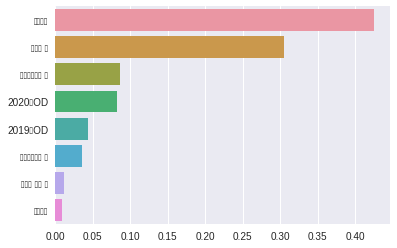

In [ ]:
# GB regressor 

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
gb_reg.fit(X_data, y_target)

feature_series = pd.Series(data=gb_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
#Permutation importance of GB
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(gb_reg,random_state=0).fit(X_data,y_target)
eli5.show_weights(perm, feature_names = X_data.columns.tolist())

In [ ]:
# # XGB regressor 

# # 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
# xgb_reg.fit(X_data, y_target)

# feature_series = pd.Series(data=xgb_reg.feature_importances_, index=X_data.columns )
# feature_series = feature_series.sort_values(ascending=False)
# sns.barplot(x= feature_series, y=feature_series.index)

In [ ]:
# #Permutation importance of XGB
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(xgb_reg,random_state=0).fit(X_data,y_target)
# eli5.show_weights(perm, feature_names = X_data.columns.tolist())

In [ ]:
import statsmodels.api as sm
# 상수항 b0 추가 
X_data1 = sm.add_constant(X_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y_target, X_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()
y_target = df_scaled['변화량']
X_data = df_scaled.drop(['2019총OD','상권유무','대규모 점포 수','문화쇼핑시설 수','2019총OD','체육편의시설 수'], axis=1, inplace=False)
# 상수항 b0 추가 
X_data1 = sm.add_constant(X_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y_target, X_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    변화량   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.864e+30
Date:                Thu, 13 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:17:10   Log-Likelihood:                 1196.9
No. Observations:                  35   AIC:                            -2384.
Df Residuals:                      30   BIC:                            -2376.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.018e-16   1.56e-16     -1.930      0.063   -6.21e-16    1.75e-17
2020총OD     1.388e-16   2.98e-16      0.465      0.645   -4.71e-16    7.48e-16
변화량            1.0000   2.75e-16   3.64e+15      0.000       1.000       1.000
유동인구       -1.145e-16   3.19e-16     -0.359      0.722   -7.65e-16    5.36e-16
기업체 수       7.286e-17   3.03e-16      0.240      0.812   -5.46e-16    6.92e-16
==============================================================================
Omnibus:                        3.857   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                2.592
Skew:                           0.627   Prob(JB):                        0.274
Kurtosis:                       3.455   Cond. No.                         8.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# feature importance 기반으로 점수식 만들기

# 유동인구 / 기업체 수 두가지 고려

# 1.0310 / 1.0310	유동인구
# 0.4104 / 1.0310	기업체
# 0.1437 / 1.0310	체육편의시설
# 0.1029 / 1.0310	 2020 총 0d 

유동인구w = 1.0310 / 1.0310
기업체w = 0.4104 / 1.0310
체육편의시설w = 0.1437 / 1.0310
odw = 0.1029 / 1.0310

In [ ]:
# 데이터프레임에서 두가지 변수만 추출
df_수요지수 = df_scaled[['유동인구','기업체 수']]

잠재수요지수 = []
for i in range(len(df_수요지수)):
  잠재수요지수.append( ( df_수요지수.values[i][0] * 유동인구w ) + ( df_수요지수.values[i][1] * 기업체w ) )
df_수요지수['잠재수요지수'] = 잠재수요지수
df_수요지수['행정동'] = dfd['행정동']
df_수요지수

유동인구     기업체 수    잠재수요지수    행정동
0   0.427429  0.930514  0.797829    구갈동
1   0.530288  0.359085  0.673226    구성동
2   0.679307  0.359085  0.822244    기흥동
3   0.623940  0.413897  0.788696    남사읍
4   0.354010  0.132067  0.406581   동백1동
5   0.456021  0.731981  0.747394   동백2동
6   0.180882  0.000000  0.180882   동백3동
7   0.157136  0.304704  0.278427    동부동
8   0.582505  0.676306  0.851716    동천동
9   0.554519  0.227881  0.645229    마북동
10  0.348074  0.953388  0.727579    모현읍
11  0.143203  0.242987  0.239927    백암면
12  0.336201  0.370738  0.483777    보라동
13  0.855706  0.733276  1.147594    보정동
14  0.157257  0.072076  0.185948    상갈동
15  0.094015  0.092361  0.130780    상하동
16  0.459414  0.458783  0.642037   상현1동
17  0.000000  0.205006  0.081605   상현2동
18  0.341289  0.226155  0.431312    서농동
19  0.640659  0.367285  0.786861    성복동
20  0.787739  0.513164  0.992009    신갈동
21  0.203417  0.276219  0.313368    신봉동
22  0.827235  0.544670  1.044047    양지면
23  0.569906  0.689685  0.844442    역삼동
24  0.441968  0.638325  0.696059   영덕1동
25  0.234795  0.107467  0.277573   영덕2동
26  0.104798  0.177385  0.175407    원삼면
27  0.730191  0.312905  0.854746    유림동
28  0.454325  0.557186  0.676119    이동읍
29  0.346256  0.719465  0.632647   죽전1동
30  0.431791  0.379801  0.582974   죽전2동
31  0.587836  1.000000  0.985896    중앙동
32  1.000000  0.737592  1.293606    포곡읍
33  0.340562  0.692274  0.616129  풍덕천1동
34  0.404410  0.349158  0.543396  풍덕천2동

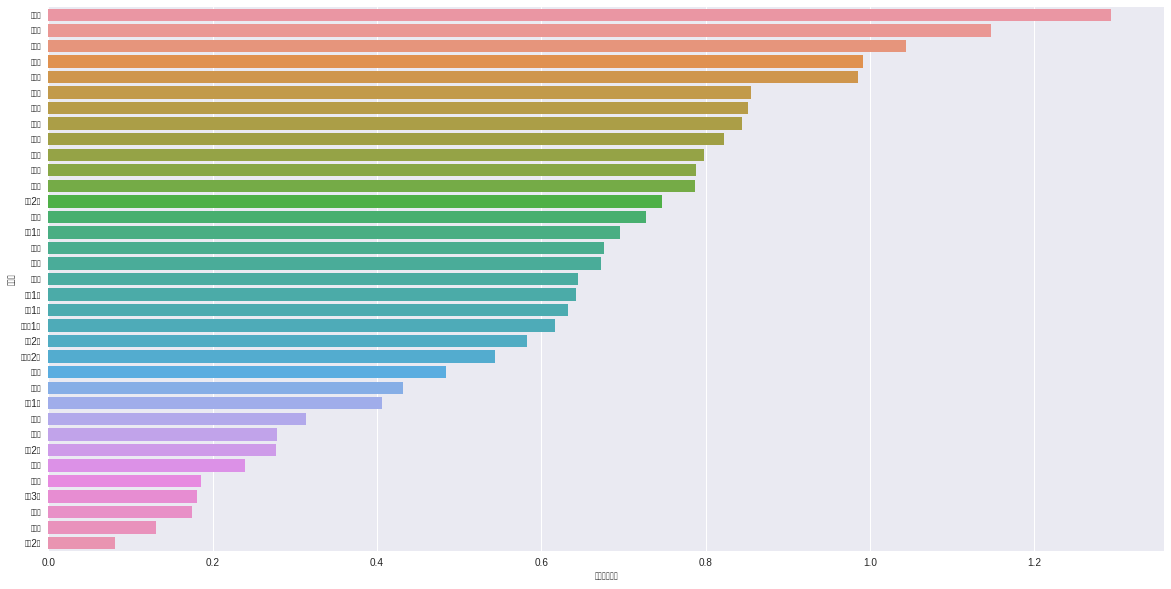

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
순위대로정렬 = df_수요지수.sort_values('잠재수요지수', ascending=False)

sns.barplot(x=순위대로정렬['잠재수요지수'], y=순위대로정렬['행정동'])

In [ ]:
# min-max scale
curr_count=dfb_23[['현재수요지수']]
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
scaled = minMaxScaler.fit_transform(curr_count)
columns = curr_count.columns
curr_count = pd.DataFrame(scaled,columns=columns)
#현재수요지수 합치기
curr_count['행정동']=dfb_23['행정동']
df_cf=pd.merge(df_수요지수,curr_count,on='행정동')
df_cf

유동인구     기업체 수    잠재수요지수    행정동    현재수요지수
0   0.427429  0.930514  0.797829    구갈동  0.556319
1   0.530288  0.359085  0.673226    구성동  0.429095
2   0.679307  0.359085  0.822244    기흥동  0.439509
3   0.623940  0.413897  0.788696    남사읍  0.354266
4   0.354010  0.132067  0.406581   동백1동  0.245899
5   0.456021  0.731981  0.747394   동백2동  0.309476
6   0.180882  0.000000  0.180882   동백3동  0.188933
7   0.157136  0.304704  0.278427    동부동  0.000000
8   0.582505  0.676306  0.851716    동천동  0.557591
9   0.554519  0.227881  0.645229    마북동  0.529850
10  0.348074  0.953388  0.727579    모현읍  0.967073
11  0.143203  0.242987  0.239927    백암면  0.117729
12  0.336201  0.370738  0.483777    보라동  0.487873
13  0.855706  0.733276  1.147594    보정동  0.491639
14  0.157257  0.072076  0.185948    상갈동  0.048647
15  0.094015  0.092361  0.130780    상하동  0.236105
16  0.459414  0.458783  0.642037   상현1동  0.514977
17  0.000000  0.205006  0.081605   상현2동  0.185921
18  0.341289  0.226155  0.431312    서농동  1.000000
19  0.640659  0.367285  0.786861    성복동  0.721281
20  0.787739  0.513164  0.992009    신갈동  0.521619
21  0.203417  0.276219  0.313368    신봉동  0.475970
22  0.827235  0.544670  1.044047    양지면  0.422114
23  0.569906  0.689685  0.844442    역삼동  0.692828
24  0.441968  0.638325  0.696059   영덕1동  0.310799
25  0.234795  0.107467  0.277573   영덕2동  0.169563
26  0.104798  0.177385  0.175407    원삼면  0.066439
27  0.730191  0.312905  0.854746    유림동  0.529723
28  0.454325  0.557186  0.676119    이동읍  0.339650
29  0.346256  0.719465  0.632647   죽전1동  0.851149
30  0.431791  0.379801  0.582974   죽전2동  0.193607
31  0.587836  1.000000  0.985896    중앙동  0.387113
32  1.000000  0.737592  1.293606    포곡읍  0.655246
33  0.340562  0.692274  0.616129  풍덕천1동  0.457338
34  0.404410  0.349158  0.543396  풍덕천2동  0.457574

In [ ]:
#순위매기기
df_cf['현재수요순위'] = df_cf.현재수요지수.rank(method='max',ascending=False)
df_cf['잠재수요순위'] = df_cf.잠재수요지수.rank(method='max',ascending=False)
df_cf['최종순위']=df_cf['잠재수요순위']+df_cf['현재수요순위']
df_cf['현재수요순위']=df_cf['현재수요순위'].astype(int)
df_cf['잠재수요순위']=df_cf['잠재수요순위'].astype(int)
df_cf['최종순위']=df_cf['최종순위'].astype(int)
df_cf=df_cf.sort_values(by='최종순위',ascending=True)

In [ ]:
df_cf

유동인구     기업체 수    잠재수요지수    행정동    현재수요지수  현재수요순위  잠재수요순위  최종순위
32  1.000000  0.737592  1.293606    포곡읍  0.655246       6       1     7
23  0.569906  0.689685  0.844442    역삼동  0.692828       5       8    13
8   0.582505  0.676306  0.851716    동천동  0.557591       7       7    14
20  0.787739  0.513164  0.992009    신갈동  0.521619      11       4    15
13  0.855706  0.733276  1.147594    보정동  0.491639      13       2    15
19  0.640659  0.367285  0.786861    성복동  0.721281       4      12    16
27  0.730191  0.312905  0.854746    유림동  0.529723      10       6    16
10  0.348074  0.953388  0.727579    모현읍  0.967073       2      14    16
0   0.427429  0.930514  0.797829    구갈동  0.556319       8      10    18
22  0.827235  0.544670  1.044047    양지면  0.422114      20       3    23
29  0.346256  0.719465  0.632647   죽전1동  0.851149       3      20    23
31  0.587836  1.000000  0.985896    중앙동  0.387113      21       5    26
18  0.341289  0.226155  0.431312    서농동  1.000000       1      25    26
2   0.679307  0.359085  0.822244    기흥동  0.439509      18       9    27
9   0.554519  0.227881  0.645229    마북동  0.529850       9      18    27
16  0.459414  0.458783  0.642037   상현1동  0.514977      12      19    31
3   0.623940  0.413897  0.788696    남사읍  0.354266      22      11    33
1   0.530288  0.359085  0.673226    구성동  0.429095      19      17    36
12  0.336201  0.370738  0.483777    보라동  0.487873      14      24    38
5   0.456021  0.731981  0.747394   동백2동  0.309476      25      13    38
33  0.340562  0.692274  0.616129  풍덕천1동  0.457338      17      21    38
24  0.441968  0.638325  0.696059   영덕1동  0.310799      24      15    39
28  0.454325  0.557186  0.676119    이동읍  0.339650      23      16    39
34  0.404410  0.349158  0.543396  풍덕천2동  0.457574      16      23    39
21  0.203417  0.276219  0.313368    신봉동  0.475970      15      27    42
30  0.431791  0.379801  0.582974   죽전2동  0.193607      28      22    50
4   0.354010  0.132067  0.406581   동백1동  0.245899      26      26    52
25  0.234795  0.107467  0.277573   영덕2동  0.169563      31      29    60
15  0.094015  0.092361  0.130780    상하동  0.236105      27      34    61
6   0.180882  0.000000  0.180882   동백3동  0.188933      29      32    61
11  0.143203  0.242987  0.239927    백암면  0.117729      32      30    62
7   0.157136  0.304704  0.278427    동부동  0.000000      35      28    63
14  0.157257  0.072076  0.185948    상갈동  0.048647      34      31    65
17  0.000000  0.205006  0.081605   상현2동  0.185921      30      35    65
26  0.104798  0.177385  0.175407    원삼면  0.066439      33      33    66

In [ ]:
# df_cf.to_csv('/content/gdrive/Shareddrives/전기차/data/통계자료/활동지_읍면동별수요지수.csv')

In [ ]:
# 활동지 읍면동별 수요지수 가져와서 수요지수 만들어주기 
활동지읍면동 = pd.read_csv('/content/gdrive/Shareddrives/전기차/data/결과물/활동지_읍면동별수요지수.csv')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
scaled = minMaxScaler.fit_transform(활동지읍면동[['잠재수요지수']])
활동지읍면동['잠재수요지수scaled'] = scaled
활동지읍면동['최종수요지수합']=활동지읍면동['현재수요지수'] + 활동지읍면동['잠재수요지수scaled']
scaled= minMaxScaler.fit_transform(활동지읍면동[['최종수요지수합']])
활동지읍면동['최종수요지수합scaled'] = scaled
활동지읍면동

Unnamed: 0      유동인구     기업체 수    잠재수요지수    행정동    현재수요지수  현재수요순위  잠재수요순위  \
0           32  1.000000  0.737592  1.293606    포곡읍  0.655246       6       1   
1           23  0.569906  0.689685  0.844442    역삼동  0.692828       5       8   
2            8  0.582505  0.676306  0.851716    동천동  0.557591       7       7   
3           20  0.787739  0.513164  0.992009    신갈동  0.521619      11       4   
4           13  0.855706  0.733276  1.147594    보정동  0.491639      13       2   
5           19  0.640659  0.367285  0.786861    성복동  0.721281       4      12   
6           27  0.730191  0.312905  0.854746    유림동  0.529723      10       6   
7           10  0.348074  0.953388  0.727579    모현읍  0.967073       2      14   
8            0  0.427429  0.930514  0.797829    구갈동  0.556319       8      10   
9           22  0.827235  0.544670  1.044047    양지면  0.422114      20       3   
10          29  0.346256  0.719465  0.632647   죽전1동  0.851149       3      20   
11          31  0.587836  1.000000  0.985896    중앙동  0.387113      21       5   
12          18  0.341289  0.226155  0.431312    서농동  1.000000       1      25   
13           2  0.679307  0.359085  0.822244    기흥동  0.439509      18       9   
14           9  0.554519  0.227881  0.645229    마북동  0.529850       9      18   
15          16  0.459414  0.458783  0.642037   상현1동  0.514977      12      19   
16           3  0.623940  0.413897  0.788696    남사읍  0.354266      22      11   
17           1  0.530288  0.359085  0.673226    구성동  0.429095      19      17   
18          12  0.336201  0.370738  0.483777    보라동  0.487873      14      24   
19           5  0.456021  0.731981  0.747394   동백2동  0.309476      25      13   
20          33  0.340562  0.692274  0.616129  풍덕천1동  0.457338      17      21   
21          24  0.441968  0.638325  0.696059   영덕1동  0.310799      24      15   
22          28  0.454325  0.557186  0.676119    이동읍  0.339650      23      16   
23          34  0.404410  0.349158  0.543396  풍덕천2동  0.457574      16      23   
24          21  0.203417  0.276219  0.313368    신봉동  0.475970      15      27   
25          30  0.431791  0.379801  0.582974   죽전2동  0.193607      28      22   
26           4  0.354010  0.132067  0.406581   동백1동  0.245899      26      26   
27          25  0.234795  0.107467  0.277573   영덕2동  0.169563      31      29   
28          15  0.094015  0.092361  0.130780    상하동  0.236105      27      34   
29           6  0.180882  0.000000  0.180882   동백3동  0.188933      29      32   
30          11  0.143203  0.242987  0.239927    백암면  0.117729      32      30   
31           7  0.157136  0.304704  0.278427    동부동  0.000000      35      28   
32          14  0.157257  0.072076  0.185948    상갈동  0.048647      34      31   
33          17  0.000000  0.205006  0.081605   상현2동  0.185921      30      35   
34          26  0.104798  0.177385  0.175407    원삼면  0.066439      33      33   

    최종순위  잠재수요지수scaled   최종수요지수합  최종수요지수합scaled  
0      7      1.000000  1.655246       1.000000  
1     13      0.629403  1.322231       0.780984  
2     14      0.635404  1.192996       0.695989  
3     15      0.751158  1.272777       0.748460  
4     15      0.879528  1.371167       0.813168  
5     16      0.581894  1.303175       0.768451  
6     16      0.637905  1.167628       0.679306  
7     16      0.532982  1.500055       0.897935  
8     18      0.590944  1.147263       0.665912  
9     23      0.794093  1.216207       0.711255  
10    23      0.454655  1.305803       0.770180  
11    26      0.746114  1.133227       0.656681  
12    26      0.288537  1.288537       0.758825  
13    27      0.611088  1.050598       0.602338  
14    27      0.465036  0.994886       0.565697  
15    31      0.462402  0.977379       0.554184  
16    33      0.583408  0.937674       0.528071  
17    36      0.488136  0.917231       0.514625  
18    38      0.331825  0.819698       0.450481  
19    38      0.549330  0.858806       0.476201  
20    38      0.441026  0.898365     

In [ ]:
# 활동지읍면동.to_csv('/content/gdrive/Shareddrives/전기차/data/결과물/읍면동_활동지수요점수끝.csv')

### 거주지 잠재수요점수 산출 (아파트 clustering) 

#### K-means Clustering (아파트별 군집 나누기) 

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score
ss = MinMaxScaler()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df3=pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/최종거주지입지선정클러스터링진짜최종.csv')

In [ ]:
df3.head()

index  Unnamed: 0  Column1  df_apt_idx         LA          LO  \
0      0           0        6           6  37.267156  127.217583   
1      1          12       20          20  37.270094  127.212311   
2      2          14       26          28  37.266887  127.216223   
3      3          15       27          29  37.273634  127.221171   
4      4          17       29          31  37.272202  127.210297   

                   법정동     주번_부              아파트  count_cust   age_avg  \
0  경기도 용인시 처인구 포곡읍 둔전리  1470000          신원2차아파트     599.384  9.649709   
1  경기도 용인시 처인구 포곡읍 둔전리  3190000         인정멜로디아파트    2412.584  8.585178   
2  경기도 용인시 처인구 포곡읍 둔전리  4470000        금전마을계룡리슈빌     527.950  6.175950   
3  경기도 용인시 처인구 포곡읍 둔전리  4490000     용인포곡삼성쉐르빌아파트     620.068  8.348547   
4  경기도 용인시 처인구 포곡읍 영문리  5550000  배머루마을 인정베네치아빌리지     170.366  8.569379   

   완속최소설치개수  완속설치개수  부족개수  매매(억)    세대수  총주차대수  행정동  
0       4.0       0   4.0   3.00  296.0    296  포곡읍  
1      15.0       0  15.0   2.30  831.0    824  포곡읍  
2       8.0       2   6.0   4.30  441.0    485  포곡읍  
3      12.0       6   6.0   4.80  469.0    671  포곡읍  
4       7.0       0   7.0   3.47  347.0    422  포곡읍

In [ ]:
apart = df3[['법정동','행정동','주번_부','아파트','매매(억)','총주차대수','세대수','age_avg']]

In [ ]:
apart.isnull().sum()

법정동        0
행정동        0
주번_부       0
아파트        0
매매(억)      0
총주차대수      0
세대수        0
age_avg    0
dtype: int64

In [ ]:
apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   법정동      395 non-null    object 
 1   행정동      395 non-null    object 
 2   주번_부     395 non-null    int64  
 3   아파트      395 non-null    object 
 4   매매(억)    395 non-null    float64
 5   총주차대수    395 non-null    int64  
 6   세대수      395 non-null    float64
 7   age_avg  395 non-null    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 24.8+ KB


In [ ]:
for_kmeans=apart[['매매(억)',	'세대수','age_avg']]

In [ ]:
for_kmeans

매매(억)     세대수   age_avg
0     3.00   296.0  9.649709
1     2.30   831.0  8.585178
2     4.30   441.0  6.175950
3     4.80   469.0  8.348547
4     3.47   347.0  8.569379
..     ...     ...       ...
390   7.30   425.0  7.499142
391  12.00   344.0  8.498300
392   9.10   980.0  8.405539
393   8.20   283.0  8.051652
394   6.00  1744.0  8.625066

[395 rows x 3 columns]

In [ ]:
scaled_data = ss.fit_transform(for_kmeans)
scaled_df=pd.DataFrame(scaled_data, columns = ['매매(억)',	'세대수','age_avg'], index=apart.index)

In [ ]:
scaled_df

매매(억)       세대수   age_avg
0    0.112426  0.066183  0.592283
1    0.071006  0.308704  0.484554
2    0.189349  0.131913  0.240743
3    0.218935  0.144606  0.460607
4    0.140237  0.089302  0.482955
..        ...       ...       ...
390  0.366864  0.124660  0.374648
391  0.644970  0.087942  0.475762
392  0.473373  0.376247  0.466374
393  0.420118  0.060290  0.430562
394  0.289941  0.722575  0.488590

[395 rows x 3 columns]

Text(0, 0.5, 'Within Cluster Sum of Squares')

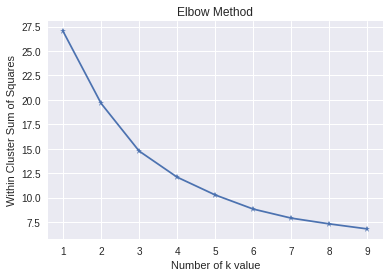

In [ ]:
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot([1,2,3,4,5,6,7,8,9], wcss, marker='*')
plt.title('Elbow Method')
plt.xlabel('Number of k value')
plt.ylabel('Within Cluster Sum of Squares')

Text(0, 0.5, 'silhouette_score')

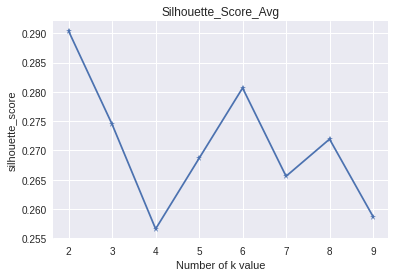

In [ ]:
silhouette_score_avg = []
for i in range(2,10):
  kmeans = KMeans(n_clusters=i, random_state=0)
  clusters = kmeans.fit(scaled_data)
  average_score = silhouette_score(scaled_data, clusters.labels_)
  silhouette_score_avg.append(average_score)

plt.plot([2,3,4,5,6,7,8,9],silhouette_score_avg, marker='*')
plt.title('Silhouette_Score_Avg')
plt.xlabel('Number of k value')
plt.ylabel('silhouette_score')

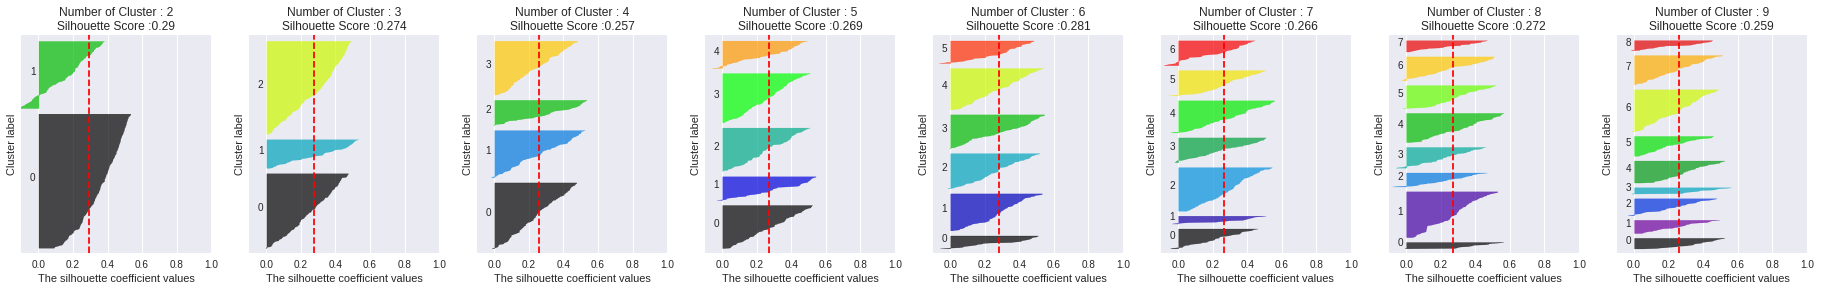

In [ ]:
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


def visualize_silhouette(cluster_lists, X_features):     
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
from sklearn.datasets import load_iris

# iris = load_iris()
visualize_silhouette([2, 3, 4, 5, 6, 7, 8, 9], scaled_data)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit(scaled_data)
scaled_df['cluster'] = clusters.labels_ # KMeans를 통해 도출된 cluster 값을 추가
# scaled_df[['행정동','주번_부','아파트']] = apart[['행정동','주번_부','아파트']]

# scaled_df.index = apart['아파트']
scaled_df

매매(억)       세대수   age_avg  cluster
0    0.112426  0.066183  0.592283        3
1    0.071006  0.308704  0.484554        3
2    0.189349  0.131913  0.240743        2
3    0.218935  0.144606  0.460607        3
4    0.140237  0.089302  0.482955        3
..        ...       ...       ...      ...
390  0.366864  0.124660  0.374648        2
391  0.644970  0.087942  0.475762        5
392  0.473373  0.376247  0.466374        1
393  0.420118  0.060290  0.430562        4
394  0.289941  0.722575  0.488590        0

[395 rows x 4 columns]

In [ ]:
#cluster 속성의 요약 값
new_scaled=scaled_df.groupby('cluster').mean()
new_scaled['age_avg']=[1-i for i in new_scaled['age_avg']]
new_scaled['총합'] = new_scaled['매매(억)']+new_scaled['세대수']+new_scaled['age_avg']
new_scaled['총합'] = ss.fit_transform(new_scaled[['총합']])
new_scaled

매매(억)       세대수   age_avg        총합
cluster                                        
0        0.408326  0.612064  0.522160  1.000000
1        0.327604  0.281902  0.538130  0.504382
2        0.302235  0.101213  0.692128  0.439048
3        0.157413  0.107925  0.480398  0.000000
4        0.410488  0.087659  0.430688  0.229790
5        0.639778  0.196056  0.551936  0.805751

In [ ]:
scaled_df[['법정동','행정동','주번_부','아파트']] = apart[['법정동','행정동','주번_부','아파트']]

In [ ]:
scaled_df['법정동주소상세'] = scaled_df['법정동'] + ' ' +scaled_df['주번_부'].astype(str)

In [ ]:
scaled_df['군집별총합'] = pd.Series()
scaled_df['군집별총합'][scaled_df['cluster']==0] = 1.542550
scaled_df['군집별총합'][scaled_df['cluster']==1] = 1.147635
scaled_df['군집별총합'][scaled_df['cluster']==2] = 	1.095576
scaled_df['군집별총합'][scaled_df['cluster']==3] = 0.745736
scaled_df['군집별총합'][scaled_df['cluster']==4] = 	0.928836
scaled_df['군집별총합'][scaled_df['cluster']==5] = 1.387770

In [ ]:
scaled_df.sample(5)

매매(억)       세대수   age_avg  cluster              법정동   행정동     주번_부  \
155  0.213018  0.386673  0.618892        1  경기도 용인시 기흥구 하갈동  영덕2동  6310000   
311  0.491124  0.067090  0.412455        4  경기도 용인시 수지구 신봉동   신봉동  9590000   
81   0.349112  0.139619  0.384167        2  경기도 용인시 기흥구 서천동   서농동  8340000   
286  0.331361  0.693110  0.462667        0  경기도 용인시 기흥구 하갈동  영덕2동  6350000   
191  0.624260  0.427924  0.561796        5  경기도 용인시 수지구 성복동   성복동  8190000   

                    아파트                  법정동주소상세     군집별총합  
155     청명호수마을 신안인스빌1단지  경기도 용인시 기흥구 하갈동 6310000  1.147635  
311  신봉마을 용인신봉 센트레빌 1단지  경기도 용인시 수지구 신봉동 9590000  0.928836  
81       용인서천 효성해링턴플레이스  경기도 용인시 기흥구 서천동 8340000  1.095576  
286       용인기흥효성해링턴플레이스  경기도 용인시 기흥구 하갈동 6350000  1.542550  
191       성복역 롯데캐슬 클라시엘  경기도 용인시 수지구 성복동 8190000  1.387770

In [ ]:
scaled_df[['아파트','cluster','군집별총합']].to_csv("/content/drive/Shareddrives/전기차/data/결과물/아파트별군별및총합.csv",index=False)

In [ ]:
pd.read_csv("/content/drive/Shareddrives/전기차/data/결과물/아파트별군별및총합.csv")

아파트  cluster     군집별총합
0            신원2차아파트        3  0.745736
1           인정멜로디아파트        3  0.745736
2          금전마을계룡리슈빌        2  1.095576
3       용인포곡삼성쉐르빌아파트        3  0.745736
4    배머루마을 인정베네치아빌리지        3  0.745736
..               ...      ...       ...
390      블루밍벽산3단지아파트        2  1.095576
391          수진마을2단지        5  1.387770
392       더샵 동천이스트포레        1  1.147635
393        광교쌍용포레듀엔B        4  0.928836
394     진산마을성원상떼빌아파트        0  1.542550

[395 rows x 3 columns]

In [ ]:
#아파트 단지 이름으로 클러스터 구분
cluster_0 = scaled_df['아파트'][scaled_df['cluster']==0].to_list()
cluster_1 = scaled_df['아파트'][scaled_df['cluster']==1].to_list()
cluster_2 = scaled_df['아파트'][scaled_df['cluster']==2].to_list()
cluster_3 = scaled_df['아파트'][scaled_df['cluster']==3].to_list()
cluster_4 = scaled_df['아파트'][scaled_df['cluster']==4].to_list()
cluster_5 = scaled_df['아파트'][scaled_df['cluster']==5].to_list()

print('cluster_0:\n',cluster_0,'\n')
print('cluster_1:\n',cluster_1,'\n')
print('cluster_2:\n',cluster_2,'\n')
print('cluster_3:\n',cluster_3,'\n')
print('cluster_4:\n',cluster_4,'\n')
print('cluster_5:\n',cluster_5,'\n')

cluster_0:
 ['쌍용스윗닷홀아파트', '탑실마을 대주피오레2단지아파트', '블루밍구성더센트럴', '신동백 롯데캐슬에코1단지아파트', '행원마을동아솔레시티아파트', '죽현마을 아이파크', '상하동 621', '강남마을주공8단지아파트', '신흥덕롯데캐슬레이시티', '현대아파트', '동아.삼익.풍림아파트', '성복역 롯데캐슬 골드타운', '우미린센트럴파크', '역북지웰푸르지오', '새터마을죽전힐스테이트', '내대지마을건영캐스빌', '신동백 두산위브더제니스', '용인기흥효성해링턴플레이스', '삼성래미안2차아파트', '신정마을8단지현대성우아파트', 'e편한세상 수지', '신봉마을엘지자이1차아파트', '신봉마을자이2차아파트', '동천마을현대2차홈타운', '동문굿모닝힐5차아파트', '성동마을 엘지빌리지3차', '진산마을삼성래미안5차아파트', '진산마을성원상떼빌아파트'] 

cluster_1:
 ['용인 행정타운 두산위브 2단지', '양우내안애에듀퍼스트', '한성아파트', '기흥구갈한양수자인아파트', '강남마을자연&아이원4단지아파트', '계룡리슈빌7단지아파트', '기흥역지웰푸르지오', '민속마을신창미션힐아파트', '보라마을 현대모닝사이드2차아파트', '민속마을 현대모닝사이드아파트', '한보라 THE HILL 아파트', '보라해링턴플레이스', '써니밸리아파트', '한보라마을휴먼시아7단지아파트', '탑실마을 대주피오레1단지아파트', '서그내마을에스케이아파트', '힐스테이트 서천', '영통로 효성해링턴플레이스', '서천 센트럴파크원', '하마비마을 동일하이빌1차아파트', '하마비마을 동일하이빌2차아파트', '초원마을 성원상떼빌2차아파트', '휴먼시아 물푸레마을 3단지 아파트', '교동마을 현대홈타운아파트', '신동백 서해그랑블2단지아파트', '연원마을성원상떼빌아파트', '강남마을한라비발디아파트', '갈천마을신일유토빌아파트', '지석마을 그대가 크레던스', '도현마을현대아이파크아파트', '기흥역롯데캐슬스카이', '양현마을풍림신안아파트', '기흥파크뷰', '청명호수마을 신안

In [ ]:
#아파트 단지 상세한 법정동주소로 클러스터 구분
cluster_0 = scaled_df['법정동주소상세'][scaled_df['cluster']==0].to_list()
cluster_1 = scaled_df['법정동주소상세'][scaled_df['cluster']==1].to_list()
cluster_2 = scaled_df['법정동주소상세'][scaled_df['cluster']==2].to_list()
cluster_3 = scaled_df['법정동주소상세'][scaled_df['cluster']==3].to_list()
cluster_4 = scaled_df['법정동주소상세'][scaled_df['cluster']==4].to_list()
cluster_5 = scaled_df['법정동주소상세'][scaled_df['cluster']==5].to_list()

print('cluster_0:\n',cluster_0,'\n')
print('cluster_1:\n',cluster_1,'\n')
print('cluster_2:\n',cluster_2,'\n')
print('cluster_3:\n',cluster_3,'\n')
print('cluster_4:\n',cluster_4,'\n')
print('cluster_5:\n',cluster_5,'\n')

cluster_0:
 ['경기도 용인시 기흥구 보라동 5530000', '경기도 용인시 기흥구 공세동 7140000', '경기도 용인시 기흥구 마북동 5240008', '경기도 용인시 기흥구 중동 10960000', '경기도 용인시 기흥구 보정동 11620000', '경기도 용인시 기흥구 보정동 12670000', '경기도 용인시 기흥구 상하동 6210000', '경기도 용인시 기흥구 상하동 6360000', '경기도 용인시 기흥구 신갈동 7360000', '경기도 용인시 수지구 풍덕천동 7000001', '경기도 용인시 수지구 풍덕천동 6640000', '경기도 용인시 수지구 성복동 7890000', '경기도 용인시 처인구 역북동 7360000', '경기도 용인시 처인구 역북동 8090000', '경기도 용인시 수지구 죽전동 11650000', '경기도 용인시 수지구 죽전동 11820000', '경기도 용인시 기흥구 동백동 4190010', '경기도 용인시 기흥구 하갈동 6350000', '경기도 용인시 기흥구 마북동 6280000', '경기도 용인시 수지구 풍덕천동 11120000', '경기도 용인시 수지구 풍덕천동 12090000', '경기도 용인시 수지구 신봉동 8730000', '경기도 용인시 수지구 신봉동 9110000', '경기도 용인시 수지구 동천동 8620000', '경기도 용인시 수지구 동천동 9140000', '경기도 용인시 수지구 성복동 7260000', '경기도 용인시 수지구 풍덕천동 11680001', '경기도 용인시 수지구 풍덕천동 2200005'] 

cluster_1:
 ['경기도 용인시 처인구 삼가동 5630000', '경기도 용인시 처인구 고림동 10140000', '경기도 용인시 기흥구 구갈동 3800000', '경기도 용인시 기흥구 구갈동 3960000', '경기도 용인시 기흥구 구갈동 6000000', '경기도 용인시 기흥구 구갈동 6040000', '경기도 용인시 기흥구 구갈동 2270034', '경기도 용인시 기흥구 

In [ ]:
#아파트 단지 행정동주소로 클러스터 구분
cluster_0 = scaled_df['행정동'][scaled_df['cluster']==0].to_list()
cluster_1 = scaled_df['행정동'][scaled_df['cluster']==1].to_list()
cluster_2 = scaled_df['행정동'][scaled_df['cluster']==2].to_list()
cluster_3 = scaled_df['행정동'][scaled_df['cluster']==3].to_list()
cluster_4 = scaled_df['행정동'][scaled_df['cluster']==4].to_list()
cluster_5 = scaled_df['행정동'][scaled_df['cluster']==5].to_list()

print('cluster_0:\n',cluster_0,'\n')
print('cluster_1:\n',cluster_1,'\n')
print('cluster_2:\n',cluster_2,'\n')
print('cluster_3:\n',cluster_3,'\n')
print('cluster_4:\n',cluster_4,'\n')
print('cluster_5:\n',cluster_5,'\n')

cluster_0:
 ['보라동', '기흥동', '마북동', '동백3동', '보정동', '보정동', '상하동', '상하동', '신갈동', '풍덕천1동', '풍덕천1동', '성복동', '역삼동', '역삼동', '죽전1동', '죽전1동', '동백3동', '영덕2동', '마북동', '풍덕천2동', '풍덕천2동', '신봉동', '신봉동', '동천동', '동천동', '성복동', '풍덕천2동', '상현2동'] 

cluster_1:
 ['역삼동', '유림동', '구갈동', '구갈동', '구갈동', '구갈동', '구갈동', '보라동', '보라동', '보라동', '보라동', '보라동', '보라동', '기흥동', '기흥동', '서농동', '서농동', '서농동', '서농동', '구성동', '구성동', '구성동', '구성동', '마북동', '동백3동', '보정동', '상하동', '상하동', '상하동', '신갈동', '신갈동', '신갈동', '신갈동', '영덕2동', '풍덕천1동', '풍덕천1동', '풍덕천1동', '풍덕천1동', '풍덕천2동', '풍덕천2동', '성복동', '영덕1동', '영덕1동', '영덕1동', '상갈동', '동백2동', '동백2동', '동백2동', '동백1동', '역삼동', '죽전1동', '상현1동', '상현1동', '상현1동', '상현1동', '동백2동', '동백1동', '동백2동', '유림동', '신갈동', '모현읍', '영덕2동', '풍덕천2동', '신봉동', '죽전1동', '죽전1동', '죽전1동', '죽전1동', '죽전2동', '죽전2동', '죽전2동', '동천동', '상현1동', '상현2동', '상현2동', '상현2동', '상현2동', '성복동', '죽전2동', '동천동'] 

cluster_2:
 ['포곡읍', '중앙동', '중앙동', '중앙동', '유림동', '유림동', '동부동', '동부동', '구갈동', '구갈동', '보라동', '보라동', '기흥동', '기흥동', '서농동', '서농동', '구성동', '구성동', '구성동', '마북동', 

#### K-means clustering visualization

Text(0.5, 1.0, 'Clustering Visualization')

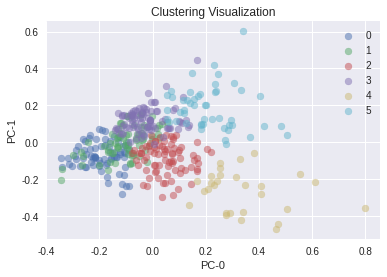

In [ ]:
from sklearn.decomposition import PCA
X = scaled_data
pca = PCA(n_components=2) #4개 변수를 2개 변수로 차원 축소
pca.fit(X) #주성분 찾기
x_pca = pca.transform(X) #찾은 주성분으로 데이터를 변환(차원축소)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = scaled_df['cluster'].to_list()

for i in pca_df['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0], tmp[1], alpha=0.5)

plt.legend([0,1,2,3,4,5])
plt.xlabel('PC-0')
plt.ylabel('PC-1')
plt.title('Clustering Visualization')

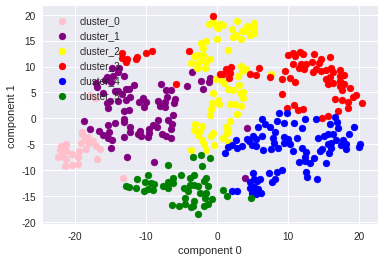

In [ ]:
from sklearn.manifold import TSNE

# class target 정보 제외
train_df = scaled_df[['매매(억)',	'세대수',	'age_avg']]

# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(train_df)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

tsne_df['cluster'] = scaled_df['cluster']

tsne_df_0 = tsne_df[tsne_df['cluster'] == 0]
tsne_df_1 = tsne_df[tsne_df['cluster'] == 1]
tsne_df_2 = tsne_df[tsne_df['cluster'] == 2]
tsne_df_3 = tsne_df[tsne_df['cluster'] == 3]
tsne_df_4 = tsne_df[tsne_df['cluster'] == 4]
tsne_df_5 = tsne_df[tsne_df['cluster'] == 5]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'cluster_0')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'cluster_1')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'cluster_2')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'red', label = 'cluster_3')
plt.scatter(tsne_df_4['component 0'], tsne_df_4['component 1'], color = 'blue', label = 'cluster_4')
plt.scatter(tsne_df_5['component 0'], tsne_df_5['component 1'], color = 'green', label = 'cluster_5')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

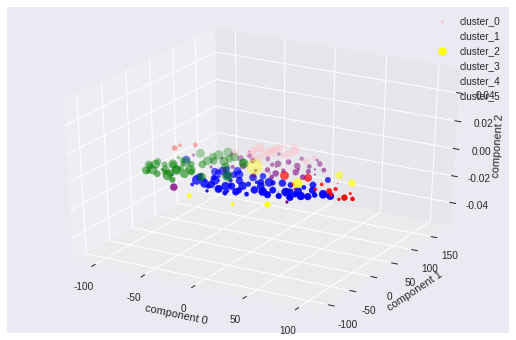

In [ ]:
from sklearn.manifold import TSNE

# 3차원 t-SNE 임베딩
train_df = scaled_df[['매매(억)',	'세대수',	'age_avg']]

tsne_np = TSNE(n_components = 3).fit_transform(train_df)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1', 'component 2'])

from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 세팅
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# class target 정보 불러오기 
tsne_df['cluster'] = scaled_df['cluster']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['cluster'] == 0]
tsne_df_1 = tsne_df[tsne_df['cluster'] == 1]
tsne_df_2 = tsne_df[tsne_df['cluster'] == 2]
tsne_df_3 = tsne_df[tsne_df['cluster'] == 3]
tsne_df_4 = tsne_df[tsne_df['cluster'] == 4]
tsne_df_5 = tsne_df[tsne_df['cluster'] == 5]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], tsne_df_0['component 2'], color = 'pink', label = 'cluster_0')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], tsne_df_1['component 2'], color = 'purple', label = 'cluster_1')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], tsne_df_2['component 2'], color = 'yellow', label = 'cluster_2')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], tsne_df_3['component 2'], color = 'red', label = 'cluster_3')
plt.scatter(tsne_df_4['component 0'], tsne_df_4['component 1'], tsne_df_4['component 2'], color = 'blue', label = 'cluster_4')
plt.scatter(tsne_df_5['component 0'], tsne_df_5['component 1'], tsne_df_5['component 2'], color = 'green', label = 'cluster_5')

ax.set_xlabel('component 0')
ax.set_ylabel('component 1')
ax.set_zlabel('component 2')
ax.legend()
plt.show()

### 거주지 최종수요 산출 데이터가공 


In [ ]:
# 아파트별 클러스터 합쳐주기 
클러스터 = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/아파트별군별및총합.csv')
클러스터

아파트  cluster     군집별총합
0            신원2차아파트        3  0.745736
1           인정멜로디아파트        3  0.745736
2          금전마을계룡리슈빌        2  1.095576
3       용인포곡삼성쉐르빌아파트        3  0.745736
4    배머루마을 인정베네치아빌리지        3  0.745736
..               ...      ...       ...
390      블루밍벽산3단지아파트        2  1.095576
391          수진마을2단지        5  1.387770
392       더샵 동천이스트포레        1  1.147635
393        광교쌍용포레듀엔B        4  0.928836
394     진산마을성원상떼빌아파트        0  1.542550

[395 rows x 3 columns]

In [ ]:
# 거주지 아파트별 카운트 순위 
거주지아파트 = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/최종거주지입지선정클러스터링진짜최종.csv')
거주지아파트['cluster'] = 클러스터['cluster']
거주지아파트['군집별총합'] = 클러스터['군집별총합']
거주지아파트 = 거주지아파트.sort_values('count_cust',ascending=False)
거주지아파트['아파트count순위'] = list(range(1,396))
거주지아파트

# 아파트 카운트 스케일링
scaled= minMaxScaler.fit_transform(거주지아파트[['count_cust']])
거주지아파트['count_cust_scaled'] = scaled
거주지아파트 = 거주지아파트.reset_index()
거주지아파트

level_0  index  Unnamed: 0  Column1  df_apt_idx         LA          LO  \
0        302    316         549      769         919  37.326311  127.078080   
1        189    196         330     1010        1175  37.312441  127.082979   
2        343    358         620      891        1049  37.338712  127.095963   
3        378    394         704      993        1157  37.318210  127.073024   
4        238    250         400     1196        1402  37.334392  127.122175   
..       ...    ...         ...      ...         ...        ...         ...   
390       36     37          93      256         336  37.231956  127.214213   
391      130    137         226      523         644  37.321606  127.101426   
392      291    305         532      181         239  37.227494  127.209762   
393      331    346         591      836         992  37.327550  127.113547   
394      279    291         498      226         301  37.264753  127.217128   

                 법정동      주번_부            아파트  ...  완속설치개수  부족개수  매매(억)  \
0    경기도 용인시 수지구 신봉동   8730000  신봉마을엘지자이1차아파트  ...      30  31.0   7.40   
1    경기도 용인시 수지구 성복동   7890000  성복역 롯데캐슬 골드타운  ...      50   5.0  12.50   
2    경기도 용인시 수지구 동천동   8620000    동천마을현대2차홈타운  ...       4  17.0   8.72   
3    경기도 용인시 수지구 성복동   7260000   성동마을 엘지빌리지3차  ...       0  59.0   9.70   
4    경기도 용인시 수지구 죽전동  11650000    새터마을죽전힐스테이트  ...       2  37.0   7.30   
..               ...       ...            ...  ...     ...   ...    ...   
390  경기도 용인시 처인구 마평동   6050001    라이프아파트 101동  ...       4   0.0   3.00   
391  경기도 용인시 기흥구 보정동  14010000     죽전역샬레파인비스타  ...       3   0.0   7.90   
392   경기도 용인시 처인구 남동   6850000  구미마을 삼라 마이다스빌  ...       0   2.0   3.20   
393  경기도 용인시 수지구 죽전동  10880002        죽전역 솔하임  ...       0   2.0   3.50   
394  경기도 용인시 처인구 고림동   8200118     인정프린스아파트2차  ...       0   3.0   2.35   

        세대수  총주차대수   행정동  cluster     군집별총합 아파트count순위  count_cust_scaled  
0    1990.0   3106   신봉동        0  1.542550          1           1.000000  
1    2356.0   2817   성복동        0  1.542550          2           0.980181  
2    1128.0   1126   동천동        0  1.542550          3           0.915395  
3    1234.0   3018   성복동        0  1.542550          4           0.858751  
4    1998.0   2032  죽전1동        0  1.542550          5           0.836092  
..      ...    ...   ...      ...       ...        ...                ...  
390   290.0    217   동부동        2  1.095576        391           0.001935  
391   155.0    187   보정동        2  1.095576        392           0.001011  
392   159.0    161   중앙동        2  1.095576        393           0.000999  
393   234.0    170  죽전1동        2  1.095576        394           0.000009  
394   330.0    241   유림동        3  0.745736        395           0.000000  

[395 rows x 23 columns]

In [ ]:
# 거주지 옆에 읍면동 수요지수 달아주기
최종수요지수scaled=[]
for i in range(len(거주지아파트)):
  for j in range(len(거주지읍면동)):
    if 거주지아파트['행정동'][i] == 거주지읍면동['행정동'][j]:
      최종수요지수scaled.append(거주지읍면동['최종수요지수합scaled'][j])

거주지아파트['읍면동scaled'] = 최종수요지수scaled
거주지아파트

level_0  index  Unnamed: 0  Column1  df_apt_idx         LA          LO  \
0        302    316         549      769         919  37.326311  127.078080   
1        189    196         330     1010        1175  37.312441  127.082979   
2        343    358         620      891        1049  37.338712  127.095963   
3        378    394         704      993        1157  37.318210  127.073024   
4        238    250         400     1196        1402  37.334392  127.122175   
..       ...    ...         ...      ...         ...        ...         ...   
390       36     37          93      256         336  37.231956  127.214213   
391      130    137         226      523         644  37.321606  127.101426   
392      291    305         532      181         239  37.227494  127.209762   
393      331    346         591      836         992  37.327550  127.113547   
394      279    291         498      226         301  37.264753  127.217128   

                 법정동      주번_부            아파트  ...  부족개수  매매(억)     세대수  \
0    경기도 용인시 수지구 신봉동   8730000  신봉마을엘지자이1차아파트  ...  31.0   7.40  1990.0   
1    경기도 용인시 수지구 성복동   7890000  성복역 롯데캐슬 골드타운  ...   5.0  12.50  2356.0   
2    경기도 용인시 수지구 동천동   8620000    동천마을현대2차홈타운  ...  17.0   8.72  1128.0   
3    경기도 용인시 수지구 성복동   7260000   성동마을 엘지빌리지3차  ...  59.0   9.70  1234.0   
4    경기도 용인시 수지구 죽전동  11650000    새터마을죽전힐스테이트  ...  37.0   7.30  1998.0   
..               ...       ...            ...  ...   ...    ...     ...   
390  경기도 용인시 처인구 마평동   6050001    라이프아파트 101동  ...   0.0   3.00   290.0   
391  경기도 용인시 기흥구 보정동  14010000     죽전역샬레파인비스타  ...   0.0   7.90   155.0   
392   경기도 용인시 처인구 남동   6850000  구미마을 삼라 마이다스빌  ...   2.0   3.20   159.0   
393  경기도 용인시 수지구 죽전동  10880002        죽전역 솔하임  ...   2.0   3.50   234.0   
394  경기도 용인시 처인구 고림동   8200118     인정프린스아파트2차  ...   3.0   2.35   330.0   

     총주차대수   행정동  cluster     군집별총합  아파트count순위 count_cust_scaled  읍면동scaled  
0     3106   신봉동        0  1.542550           1          1.000000   0.616302  
1     2817   성복동        0  1.542550           2          0.980181   1.000000  
2     1126   동천동        0  1.542550           3          0.915395   0.883181  
3     3018   성복동        0  1.542550           4          0.858751   1.000000  
4     2032  죽전1동        0  1.542550           5          0.836092   0.894092  
..     ...   ...      ...       ...         ...               ...        ...  
390    217   동부동        2  1.095576         391          0.001935   0.160869  
391    187   보정동        2  1.095576         392          0.001011   0.570164  
392    161   중앙동        2  1.095576         393          0.000999   0.246571  
393    170  죽전1동        2  1.095576         394          0.000009   0.894092  
394    241   유림동        3  0.745736         395          0.000000   0.579874  

[395 rows x 24 columns]

In [ ]:
# 거주지 옆에 읍면동 순위 달아주기
읍면동순위=[]
for i in range(len(거주지아파트)):
  for j in range(len(거주지읍면동)):
    if 거주지아파트['행정동'][i] == 거주지읍면동['행정동'][j]:
      읍면동순위.append(거주지읍면동['최종순위'][j])

거주지아파트['읍면동순위'] = 읍면동순위 
거주지아파트

level_0  index  Unnamed: 0  Column1  df_apt_idx         LA          LO  \
0        302    316         549      769         919  37.326311  127.078080   
1        189    196         330     1010        1175  37.312441  127.082979   
2        343    358         620      891        1049  37.338712  127.095963   
3        378    394         704      993        1157  37.318210  127.073024   
4        238    250         400     1196        1402  37.334392  127.122175   
..       ...    ...         ...      ...         ...        ...         ...   
390       36     37          93      256         336  37.231956  127.214213   
391      130    137         226      523         644  37.321606  127.101426   
392      291    305         532      181         239  37.227494  127.209762   
393      331    346         591      836         992  37.327550  127.113547   
394      279    291         498      226         301  37.264753  127.217128   

                 법정동      주번_부            아파트  ...  매매(억)     세대수  총주차대수  \
0    경기도 용인시 수지구 신봉동   8730000  신봉마을엘지자이1차아파트  ...   7.40  1990.0   3106   
1    경기도 용인시 수지구 성복동   7890000  성복역 롯데캐슬 골드타운  ...  12.50  2356.0   2817   
2    경기도 용인시 수지구 동천동   8620000    동천마을현대2차홈타운  ...   8.72  1128.0   1126   
3    경기도 용인시 수지구 성복동   7260000   성동마을 엘지빌리지3차  ...   9.70  1234.0   3018   
4    경기도 용인시 수지구 죽전동  11650000    새터마을죽전힐스테이트  ...   7.30  1998.0   2032   
..               ...       ...            ...  ...    ...     ...    ...   
390  경기도 용인시 처인구 마평동   6050001    라이프아파트 101동  ...   3.00   290.0    217   
391  경기도 용인시 기흥구 보정동  14010000     죽전역샬레파인비스타  ...   7.90   155.0    187   
392   경기도 용인시 처인구 남동   6850000  구미마을 삼라 마이다스빌  ...   3.20   159.0    161   
393  경기도 용인시 수지구 죽전동  10880002        죽전역 솔하임  ...   3.50   234.0    170   
394  경기도 용인시 처인구 고림동   8200118     인정프린스아파트2차  ...   2.35   330.0    241   

      행정동  cluster     군집별총합  아파트count순위  count_cust_scaled 읍면동scaled  읍면동순위  
0     신봉동        0  1.542550           1           1.000000  0.616302      9  
1     성복동        0  1.542550           2           0.980181  1.000000      1  
2     동천동        0  1.542550           3           0.915395  0.883181      2  
3     성복동        0  1.542550           4           0.858751  1.000000      1  
4    죽전1동        0  1.542550           5           0.836092  0.894092      2  
..    ...      ...       ...         ...                ...       ...    ...  
390   동부동        2  1.095576         391           0.001935  0.160869     32  
391   보정동        2  1.095576         392           0.001011  0.570164     14  
392   중앙동        2  1.095576         393           0.000999  0.246571     28  
393  죽전1동        2  1.095576         394           0.000009  0.894092      2  
394   유림동        3  0.745736         395           0.000000  0.579874     13  

[395 rows x 25 columns]

In [ ]:
거주지아파트.columns


Index(['level_0', 'index', 'Unnamed: 0', 'Column1', 'df_apt_idx', 'LA', 'LO',
       '법정동', '주번_부', '아파트', 'count_cust', 'age_avg', '완속최소설치개수', '완속설치개수',
       '부족개수', '매매(억)', '세대수', '총주차대수', '행정동', 'cluster', '군집별총합',
       '아파트count순위', 'count_cust_scaled', '읍면동scaled', '읍면동순위'],
      dtype='object')

In [ ]:
거주지아파트 = 거주지아파트[['행정동','아파트','count_cust','age_avg','매매(억)','세대수','완속최소설치개수','완속설치개수','부족개수','아파트count순위','읍면동순위','count_cust_scaled','읍면동scaled','cluster','군집별총합']]
거주지아파트

행정동            아파트  count_cust   age_avg  매매(억)     세대수  완속최소설치개수  \
0     신봉동  신봉마을엘지자이1차아파트   12230.156  8.962285   7.40  1990.0      61.0   
1     성복동  성복역 롯데캐슬 골드타운   11987.855  8.310081  12.50  2356.0      55.0   
2     동천동    동천마을현대2차홈타운   11195.784  8.846659   8.72  1128.0      21.0   
3     성복동   성동마을 엘지빌리지3차   10503.261  9.731963   9.70  1234.0      59.0   
4    죽전1동    새터마을죽전힐스테이트   10226.240  7.294378   7.30  1998.0      39.0   
..    ...            ...         ...       ...    ...     ...       ...   
390   동부동    라이프아파트 101동      27.952  5.401832   3.00   290.0       3.0   
391   보정동     죽전역샬레파인비스타      16.650  6.976817   7.90   155.0       2.0   
392   중앙동  구미마을 삼라 마이다스빌      16.510  5.455663   3.20   159.0       2.0   
393  죽전1동        죽전역 솔하임       4.409  6.000000   3.50   234.0       2.0   
394   유림동     인정프린스아파트2차       4.294  7.726693   2.35   330.0       3.0   

     완속설치개수  부족개수  아파트count순위  읍면동순위  count_cust_scaled  읍면동scaled  cluster  \
0        30  31.0           1      9           1.000000   0.616302        0   
1        50   5.0           2      1           0.980181   1.000000        0   
2         4  17.0           3      2           0.915395   0.883181        0   
3         0  59.0           4      1           0.858751   1.000000        0   
4         2  37.0           5      2           0.836092   0.894092        0   
..      ...   ...         ...    ...                ...        ...      ...   
390       4   0.0         391     32           0.001935   0.160869        2   
391       3   0.0         392     14           0.001011   0.570164        2   
392       0   2.0         393     28           0.000999   0.246571        2   
393       0   2.0         394      2           0.000009   0.894092        2   
394       0   3.0         395     13           0.000000   0.579874        3   

        군집별총합  
0    1.542550  
1    1.542550  
2    1.542550  
3    1.542550  
4    1.542550  
..        ...  
390  1.095576  
391  1.095576  
392  1.095576  
393  1.095576  
394  0.745736  

[395 rows x 15 columns]

In [ ]:
scaled = minMaxScaler.fit_transform(거주지아파트[['군집별총합']])
거주지아파트['군집별scaled'] = scaled



In [ ]:
scaled_score = 거주지아파트[['읍면동scaled','count_cust_scaled','군집별scaled']]
아파트최종수요지수 = scaled_score['읍면동scaled'] + scaled_score['count_cust_scaled'] + scaled_score['군집별scaled']
scaled_score['아파트최종수요지수'] = 아파트최종수요지수
scaled_score

#기존 거주지 아파트 데이터프레임에 합쳐주기
거주지아파트['아파트최종수요지수'] = scaled_score['아파트최종수요지수']
# 거주지아파트.to_csv('/content/gdrive/Shareddrives/전기차/data/결과물/아파트수요지수끝.csv')

In [ ]:
제출용 = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/아파트수요지수끝.csv')
제출용 = 제출용[['아파트','count_cust_scaled','행정동','읍면동scaled','cluster','군집별scaled','아파트최종수요지수']]
제출용

아파트  count_cust_scaled   행정동  읍면동scaled  cluster  군집별scaled  \
0    신봉마을엘지자이1차아파트           1.000000   신봉동   0.616302        0   1.000000   
1    성복역 롯데캐슬 골드타운           0.980181   성복동   1.000000        0   1.000000   
2      동천마을현대2차홈타운           0.915395   동천동   0.883181        0   1.000000   
3     성동마을 엘지빌리지3차           0.858751   성복동   1.000000        0   1.000000   
4      새터마을죽전힐스테이트           0.836092  죽전1동   0.894092        0   1.000000   
..             ...                ...   ...        ...      ...        ...   
390    라이프아파트 101동           0.001935   동부동   0.160869        2   0.439049   
391     죽전역샬레파인비스타           0.001011   보정동   0.570164        2   0.439049   
392  구미마을 삼라 마이다스빌           0.000999   중앙동   0.246571        2   0.439049   
393        죽전역 솔하임           0.000009  죽전1동   0.894092        2   0.439049   
394     인정프린스아파트2차           0.000000   유림동   0.579874        3   0.000000   

     아파트최종수요지수  
0     2.616302  
1     2.980181  
2     2.798576  
3     2.858751  
4     2.730185  
..         ...  
390   0.601853  
391   1.010223  
392   0.686619  
393   1.333150  
394   0.579874  

[395 rows x 7 columns]

### 활동지 최종수요 데이터 가공

- 활동지가 속한 행정동의 활동지 수요지수 + 활동지 종류별 수요점수


In [ ]:
활동지시설 = pd.read_csv('/content/drive/Shareddrives/전기차/data/통계자료/활동지_countcust_chrcount.csv')
활동지시설

지명                         도로명�                    지번주�  \
0          중앙도서관           경기도 용인시 처인구 명지로 27                     NaN   
1          포곡도서관   경기도 용인시 처인구 포곡읍 포곡로278번길 8                     NaN   
2          모현도서관    경기도 용인시 처인구 모현읍 백옥대로 2378                     NaN   
3          보라도서관        경기도 용인시 기흥구 한보라2로 116                     NaN   
4        양지해밀도서관    경기도 용인시 처인구 양지면 교동로18번길 8                     NaN   
..           ...                          ...                     ...   
527    메가박스 용인기흥   경기도 용인시 기흥구 신고매로 59 리빙파워센터   경기도 용인시 기흥구 고매동 267-1   
528  한국민속촌 자동차극장        경기도 용인시 기흥구 민속촌로 93-1   경기도 용인시 기흥구 보라동 308-1   
529     CGV 광교상현     경기도 용인시 수지구 광교중앙로295번길 9  경기도 용인시 수지구 상현동 1116-4   
530     롯데시네마 수지  경기도 용인시 수지구 성복2로 38 롯데몰 수지점    경기도 용인시 수지구 성복동 61-7   
531       CGV 죽전  경기도 용인시 수지구 포은대로 536 신세계백화점    경기도 용인시 수지구 죽전동 1285   

            위도          경도  활동지�   행정동 field_8  NUMPOINTS  chr_count  
0    37.233482  127.190402  공공기관   역삼동     NaN   2565.873          3  
1    37.278916  127.232564  공공기관   포곡읍     NaN    937.338          4  
2    37.335705  127.249643  공공기관   모현읍     NaN   4585.774          0  
3    37.248416  127.109024  공공기관   보라동     NaN   7103.242          0  
4    37.237583  127.285500  공공기관   양지면     NaN   3538.142          0  
..         ...         ...   ...   ...     ...        ...        ...  
527  37.223415  127.114248   영화관   기흥동     NaN   4690.933         12  
528  37.257409  127.114322   영화관   보라동     NaN   6056.118          5  
529  37.296895  127.068115   영화관  상현1동     NaN  11651.981          3  
530  37.312798  127.081667   영화관   성복동     NaN  17871.256          0  
531  37.325003  127.108106   영화관  죽전2동     NaN  16844.353          6  

[532 rows x 10 columns]

In [ ]:
# 기존 충전소 개수에 따라 수요가 나눠진다고 가정 (기존충전기가 반경내에 있으면 그만큼 수요가 감소 )
# 단순나눔에 따른 극단적인 값변화를 방지하기위해 루트값을 사용
import math

활동지시설['NUMPOINTS'] =  활동지시설['NUMPOINTS'] / (활동지시설['chr_count']+1)**0.5
활동지시설

지명                         도로명�                    지번주�  \
0          중앙도서관           경기도 용인시 처인구 명지로 27                     NaN   
1          포곡도서관   경기도 용인시 처인구 포곡읍 포곡로278번길 8                     NaN   
2          모현도서관    경기도 용인시 처인구 모현읍 백옥대로 2378                     NaN   
3          보라도서관        경기도 용인시 기흥구 한보라2로 116                     NaN   
4        양지해밀도서관    경기도 용인시 처인구 양지면 교동로18번길 8                     NaN   
..           ...                          ...                     ...   
527    메가박스 용인기흥   경기도 용인시 기흥구 신고매로 59 리빙파워센터   경기도 용인시 기흥구 고매동 267-1   
528  한국민속촌 자동차극장        경기도 용인시 기흥구 민속촌로 93-1   경기도 용인시 기흥구 보라동 308-1   
529     CGV 광교상현     경기도 용인시 수지구 광교중앙로295번길 9  경기도 용인시 수지구 상현동 1116-4   
530     롯데시네마 수지  경기도 용인시 수지구 성복2로 38 롯데몰 수지점    경기도 용인시 수지구 성복동 61-7   
531       CGV 죽전  경기도 용인시 수지구 포은대로 536 신세계백화점    경기도 용인시 수지구 죽전동 1285   

            위도          경도  활동지�   행정동 field_8     NUMPOINTS  chr_count  
0    37.233482  127.190402  공공기관   역삼동     NaN   1282.936500          3  
1    37.278916  127.232564  공공기관   포곡읍     NaN    419.190297          4  
2    37.335705  127.249643  공공기관   모현읍     NaN   4585.774000          0  
3    37.248416  127.109024  공공기관   보라동     NaN   7103.242000          0  
4    37.237583  127.285500  공공기관   양지면     NaN   3538.142000          0  
..         ...         ...   ...   ...     ...           ...        ...  
527  37.223415  127.114248   영화관   기흥동     NaN   1301.030728         12  
528  37.257409  127.114322   영화관   보라동     NaN   2472.399820          5  
529  37.296895  127.068115   영화관  상현1동     NaN   5825.990500          3  
530  37.312798  127.081667   영화관   성복동     NaN  17871.256000          0  
531  37.325003  127.108106   영화관  죽전2동     NaN   6366.567005          6  

[532 rows x 10 columns]

In [ ]:
# 활동지 count 이상치 판단 
df_t = 활동지시설[['NUMPOINTS']]

q3 = df_t.quantile(0.75)
q1 = df_t.quantile(0.25)
iqr = q3-q1


def is_outlier(df_t):
    score = df_t['NUMPOINTS']
    if score > q3['NUMPOINTS'] + 1.5 * iqr['NUMPOINTS'] or score < q1['NUMPOINTS'] - 1.5 * iqr['NUMPOINTS']:
        return True
    else:
        return False

df_t['이상치여부'] = df_t.apply(is_outlier, axis=1)
df_t[df_t['이상치여부']==True]


NUMPOINTS  이상치여부
55   15854.113   True
99   16964.458   True
116  20429.614   True
349  15858.586   True
433  15825.809   True
520  31375.288   True
530  17871.256   True

In [ ]:
# 충전소 개수로 나눴을 경우 

# 이상치에 해당하는 데이터만 제외후 스케일링(min_maxscale은 이상치에 민감하기 때문) -> 스케일링후 이상치는 최대값1로 기입 

df_t = df_t[['NUMPOINTS']].replace(15854.113,'Nan')
df_t = df_t[['NUMPOINTS']].replace(16964.458,'Nan')
df_t = df_t[['NUMPOINTS']].replace(20429.614,'Nan')
df_t = df_t[['NUMPOINTS']].replace(15858.586,'Nan')
df_t = df_t[['NUMPOINTS']].replace(15825.809,'Nan')
df_t = df_t[['NUMPOINTS']].replace(31375.288,'Nan')
df_t = df_t[['NUMPOINTS']].replace(17871.256,'Nan')



import sklearn
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
scaled = minMaxScaler.fit_transform(df_t[['NUMPOINTS']])
활동지시설['np_scaled'] = scaled


In [ ]:
# 이상치 1.0으로 채워주기 
np_scaled = 활동지시설['np_scaled'].fillna(1.0)
활동지시설['np_scaled'] = np_scaled
활동지시설

지명                         도로명�                    지번주�  \
0          중앙도서관           경기도 용인시 처인구 명지로 27                     NaN   
1          포곡도서관   경기도 용인시 처인구 포곡읍 포곡로278번길 8                     NaN   
2          모현도서관    경기도 용인시 처인구 모현읍 백옥대로 2378                     NaN   
3          보라도서관        경기도 용인시 기흥구 한보라2로 116                     NaN   
4        양지해밀도서관    경기도 용인시 처인구 양지면 교동로18번길 8                     NaN   
..           ...                          ...                     ...   
527    메가박스 용인기흥   경기도 용인시 기흥구 신고매로 59 리빙파워센터   경기도 용인시 기흥구 고매동 267-1   
528  한국민속촌 자동차극장        경기도 용인시 기흥구 민속촌로 93-1   경기도 용인시 기흥구 보라동 308-1   
529     CGV 광교상현     경기도 용인시 수지구 광교중앙로295번길 9  경기도 용인시 수지구 상현동 1116-4   
530     롯데시네마 수지  경기도 용인시 수지구 성복2로 38 롯데몰 수지점    경기도 용인시 수지구 성복동 61-7   
531       CGV 죽전  경기도 용인시 수지구 포은대로 536 신세계백화점    경기도 용인시 수지구 죽전동 1285   

            위도          경도  활동지�   행정동 field_8     NUMPOINTS  chr_count  \
0    37.233482  127.190402  공공기관   역삼동     NaN   1282.936500          3   
1    37.278916  127.232564  공공기관   포곡읍     NaN    419.190297          4   
2    37.335705  127.249643  공공기관   모현읍     NaN   4585.774000          0   
3    37.248416  127.109024  공공기관   보라동     NaN   7103.242000          0   
4    37.237583  127.285500  공공기관   양지면     NaN   3538.142000          0   
..         ...         ...   ...   ...     ...           ...        ...   
527  37.223415  127.114248   영화관   기흥동     NaN   1301.030728         12   
528  37.257409  127.114322   영화관   보라동     NaN   2472.399820          5   
529  37.296895  127.068115   영화관  상현1동     NaN   5825.990500          3   
530  37.312798  127.081667   영화관   성복동     NaN  17871.256000          0   
531  37.325003  127.108106   영화관  죽전2동     NaN   6366.567005          6   

     np_scaled  
0     0.083382  
1     0.027244  
2     0.298043  
3     0.461661  
4     0.229954  
..         ...  
527   0.084558  
528   0.160689  
529   0.378649  
530   1.000000  
531   0.413782  

[532 rows x 11 columns]

In [ ]:
# 활동지 종류별 우선순위 기입
# 급속보다 월평균 이용시간 많으면서 평균 이용시간이 높은 순 

# 공공기관 , 마트, 주차장, 직장, 관광지, 학교, 영화관 
# 1,2,3,4,5,6,7,8 


# 월 평균이용시간 비율을 구하기 

활동지종류 = ['공공기관','마트','주차장','직장','관광지','학교','영화관']

월평균이용시간 = [4112 , 2971, 2639, 2412, 1922, 1871, 1187]  


# 완속충전기 평균이용시간 대비 해당 활동지 종류의 이용시간비율을 계산한 값을 가중치로 이용 
# 합계 평균 = 2440
영화관w  = 1187/2440
학교w = 1871/2440
관광지w = 1922/2440
직장w = 2412/2440
주차장w = 2639/2440
마트w = 2971/2440
공공기관w = 4112/2440

In [ ]:
활동지시설['활동지�'].value_counts()

학교       201
주차장      130
직장        69
공공기관      55
관광지       44
대규모점포     22
영화관       11
Name: 활동지�, dtype: int64

In [ ]:
활동지시설.columns

Index(['지명', '도로명�', '지번주�', '위도', '경도', '활동지�', '행정동', 'field_8', 'NUMPOINTS',
       'chr_count', 'np_scaled'],
      dtype='object')

In [ ]:
활동지시설['np_scaled'][0], 활동지시설['활동지�'][0]

(0.08338187767994529, '공공기관')

In [ ]:
# scaled_count에 해당 종류별 가중치 곱해주기

countX활동지=[]
for i in range(len(활동지시설['활동지�'])):
  if 활동지시설['활동지�'][i] == '주차장':
    countX활동지.append(활동지시설['np_scaled'][i] * 주차장w)
  elif (활동지시설['활동지�'][i] == '학교'): 
    countX활동지.append(활동지시설['np_scaled'][i] * 학교w)
  elif 활동지시설['활동지�'][i] == '직장':
    countX활동지.append(활동지시설['np_scaled'][i] * 직장w)
  elif (활동지시설['활동지�'][i] == '공공기관'):
    countX활동지.append(활동지시설['np_scaled'][i] * 공공기관w)
  elif (활동지시설['활동지�'][i] == '관광지'): 
    countX활동지.append(활동지시설['np_scaled'][i] * 관광지w)
  elif 활동지시설['활동지�'][i] == '대규모점포':
    countX활동지.append(활동지시설['np_scaled'][i] * 마트w)
  else:
    countX활동지.append(활동지시설['np_scaled'][i] * 영화관w)

len(countX활동지)

532

In [ ]:
활동지시설['count * 활동지가중치'] = countX활동지
활동지시설

scaled = minMaxScaler.fit_transform(활동지시설[['count * 활동지가중치']])
활동지시설['scaled_cnt*가중치'] = scaled
활동지시설

지명                         도로명�                    지번주�  \
0          중앙도서관           경기도 용인시 처인구 명지로 27                     NaN   
1          포곡도서관   경기도 용인시 처인구 포곡읍 포곡로278번길 8                     NaN   
2          모현도서관    경기도 용인시 처인구 모현읍 백옥대로 2378                     NaN   
3          보라도서관        경기도 용인시 기흥구 한보라2로 116                     NaN   
4        양지해밀도서관    경기도 용인시 처인구 양지면 교동로18번길 8                     NaN   
..           ...                          ...                     ...   
527    메가박스 용인기흥   경기도 용인시 기흥구 신고매로 59 리빙파워센터   경기도 용인시 기흥구 고매동 267-1   
528  한국민속촌 자동차극장        경기도 용인시 기흥구 민속촌로 93-1   경기도 용인시 기흥구 보라동 308-1   
529     CGV 광교상현     경기도 용인시 수지구 광교중앙로295번길 9  경기도 용인시 수지구 상현동 1116-4   
530     롯데시네마 수지  경기도 용인시 수지구 성복2로 38 롯데몰 수지점    경기도 용인시 수지구 성복동 61-7   
531       CGV 죽전  경기도 용인시 수지구 포은대로 536 신세계백화점    경기도 용인시 수지구 죽전동 1285   

            위도          경도  활동지�   행정동 field_8     NUMPOINTS  chr_count  \
0    37.233482  127.190402  공공기관   역삼동     NaN   1282.936500          3   
1    37.278916  127.232564  공공기관   포곡읍     NaN    419.190297          4   
2    37.335705  127.249643  공공기관   모현읍     NaN   4585.774000          0   
3    37.248416  127.109024  공공기관   보라동     NaN   7103.242000          0   
4    37.237583  127.285500  공공기관   양지면     NaN   3538.142000          0   
..         ...         ...   ...   ...     ...           ...        ...   
527  37.223415  127.114248   영화관   기흥동     NaN   1301.030728         12   
528  37.257409  127.114322   영화관   보라동     NaN   2472.399820          5   
529  37.296895  127.068115   영화관  상현1동     NaN   5825.990500          3   
530  37.312798  127.081667   영화관   성복동     NaN  17871.256000          0   
531  37.325003  127.108106   영화관  죽전2동     NaN   6366.567005          6   

     np_scaled  count * 활동지가중치  scaled_cnt*가중치  
0     0.083382        0.140519        0.086688  
1     0.027244        0.045914        0.028325  
2     0.298043        0.502276        0.309862  
3     0.461661        0.778012        0.479967  
4     0.229954        0.387530        0.239073  
..         ...             ...             ...  
527   0.084558        0.041135        0.025377  
528   0.160689        0.078171        0.048225  
529   0.378649        0.184203        0.113638  
530   1.000000        0.486475        0.300114  
531   0.413782        0.201295        0.124182  

[532 rows x 13 columns]

In [ ]:
활동지시설['chr_count'].value_counts()

0     336
1      82
2      41
6      16
4      11
8      10
5      10
3       8
7       7
15      2
9       2
13      2
34      2
10      1
28      1
12      1
Name: chr_count, dtype: int64

In [ ]:
# 활동지종류 옆에 읍면동 수요지수 달아주기
최종수요지수scaled=[]
for i in range(len(활동지시설)):
  for j in range(len(활동지읍면동)):
    if 활동지시설['행정동'][i] == 활동지읍면동['행정동'][j]:
      최종수요지수scaled.append(활동지읍면동['최종수요지수합scaled'][j])

활동지시설['읍면동scaled'] = 최종수요지수scaled
활동지시설['활동지시설최종수요지수'] = 활동지시설['읍면동scaled'] + 활동지시설['scaled_cnt*가중치']
활동지시설 = 활동지시설.drop(['field_8'],axis=1)
활동지시설 = 활동지시설.drop(['지번주�'],axis=1)
활동지시설.sort_values('활동지시설최종수요지수',ascending=False)

지명                           도로명�         위도          경도  활동지�  \
99   구갈1리 소공원 주변             경기도 용인시 기흥구 신구로 39  37.275709  127.109340   주차장   
82     명지대사거리 주변             경기도 용인시 처인구 용문로 42  37.237360  127.190373   주차장   
109     한신아파트 주변            경기도 용인시 기흥구 신갈로 102  37.276052  127.106774   주차장   
37          상현1동       경기도 용인시 수지구 상현로 71 (상현동)  37.304626  127.081146  공공기관   
202        죽 전 로           기흥구 죽전로 (보정동 1353번지)  37.321238  127.113089   주차장   
..           ...                            ...        ...         ...   ...   
458       두창초등학교         경기도 용인시 처인구 원삼면 복분로 29  37.158346  127.342837    학교   
438        헌산중학교      경기도 용인시 처인구 원삼면 내동로 50-13  37.173846  127.295878    학교   
306        농도원목장  경기도 용인시 처인구 원삼면 원양로377번길 1-34  37.193296  127.296632   관광지   
299      용인 학일마을        경기도 용인시 처인구 원삼면 학일로 117  37.147377  127.285821   관광지   
280   용담저수지(사암지)                            NaN  37.191789  127.306405   관광지   

      행정동     NUMPOINTS  chr_count  np_scaled  count * 활동지가중치  scaled_cnt*가중치  \
99    신갈동  16964.458000          0   1.000000        1.081557        0.667229   
82    역삼동  14001.370000          0   0.909991        0.984207        0.607172   
109   신갈동  14651.272000          0   0.952230        1.029891        0.635356   
37   상현1동  12270.938748          1   0.797525        1.344026        0.829150   
202   보정동  12864.283361          1   0.836088        0.904277        0.557862   
..    ...           ...        ...        ...             ...             ...   
458   원삼면     12.990000          0   0.000844        0.000647        0.000399   
438   원삼면      3.800000          0   0.000247        0.000189        0.000117   
306   원삼면      0.000000          0   0.000000        0.000000        0.000000   
299   원삼면      0.000000          0   0.000000        0.000000        0.000000   
280   원삼면      0.000000          0   0.000000        0.000000        0.000000   

     읍면동scaled  활동지시설최종수요지수  
99    0.748460     1.415689  
82    0.780984     1.388157  
109   0.748460     1.383815  
37    0.554184     1.383333  
202   0.813168     1.371030  
..         ...          ...  
458   0.005982     0.006381  
438   0.005982     0.006099  
306   0.005982     0.005982  
299   0.005982     0.005982  
280   0.005982     0.005982  

[532 rows x 13 columns]

In [ ]:
활동지시설.rename(columns = {'scaled_cnt*가중치': '활동지종류별수요점수'})

지명                         도로명�         위도          경도  활동지�  \
0          중앙도서관           경기도 용인시 처인구 명지로 27  37.233482  127.190402  공공기관   
1          포곡도서관   경기도 용인시 처인구 포곡읍 포곡로278번길 8  37.278916  127.232564  공공기관   
2          모현도서관    경기도 용인시 처인구 모현읍 백옥대로 2378  37.335705  127.249643  공공기관   
3          보라도서관        경기도 용인시 기흥구 한보라2로 116  37.248416  127.109024  공공기관   
4        양지해밀도서관    경기도 용인시 처인구 양지면 교동로18번길 8  37.237583  127.285500  공공기관   
..           ...                          ...        ...         ...   ...   
527    메가박스 용인기흥   경기도 용인시 기흥구 신고매로 59 리빙파워센터  37.223415  127.114248   영화관   
528  한국민속촌 자동차극장        경기도 용인시 기흥구 민속촌로 93-1  37.257409  127.114322   영화관   
529     CGV 광교상현     경기도 용인시 수지구 광교중앙로295번길 9  37.296895  127.068115   영화관   
530     롯데시네마 수지  경기도 용인시 수지구 성복2로 38 롯데몰 수지점  37.312798  127.081667   영화관   
531       CGV 죽전  경기도 용인시 수지구 포은대로 536 신세계백화점  37.325003  127.108106   영화관   

      행정동     NUMPOINTS  chr_count  np_scaled  count * 활동지가중치  활동지종류별수요점수  \
0     역삼동   1282.936500          3   0.083382        0.140519    0.086688   
1     포곡읍    419.190297          4   0.027244        0.045914    0.028325   
2     모현읍   4585.774000          0   0.298043        0.502276    0.309862   
3     보라동   7103.242000          0   0.461661        0.778012    0.479967   
4     양지면   3538.142000          0   0.229954        0.387530    0.239073   
..    ...           ...        ...        ...             ...         ...   
527   기흥동   1301.030728         12   0.084558        0.041135    0.025377   
528   보라동   2472.399820          5   0.160689        0.078171    0.048225   
529  상현1동   5825.990500          3   0.378649        0.184203    0.113638   
530   성복동  17871.256000          0   1.000000        0.486475    0.300114   
531  죽전2동   6366.567005          6   0.413782        0.201295    0.124182   

     읍면동scaled  활동지시설최종수요지수  
0     0.780984     0.867672  
1     1.000000     1.028325  
2     0.897935     1.207796  
3     0.450481     0.930448  
4     0.711255     0.950328  
..         ...          ...  
527   0.602338     0.627715  
528   0.450481     0.498706  
529   0.554184     0.667821  
530   0.768451     1.068565  
531   0.310777     0.434959  

[532 rows x 13 columns]

In [ ]:
# 최종 = 활동지시설.sort_values('활동지시설최종수요지수',ascending=False)
# 최종.to_csv('/content/gdrive/MyDrive/전기차개인파일/루트버전.csv')

### 제출용 csv파일 모음 

In [ ]:
# f = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/거주지읍면동수요지수끝.csv')
# f = f[['행정동',	'유소년',	'연봉',	'차량수',	'잠재수요지수',	'현재수요지수'	,	'잠재수요지수scaled',	'최종수요지수합']]
# f.to_csv('/content/drive/Shareddrives/전기차/data/최종결과제출용/거주지읍면동수요지수.csv')

In [ ]:
# g = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/최종거주지입지선정클러스터링진짜최종.csv')
# g = g[['행정동','LA'	,'LO'	,	'아파트',	'count_cust',	'age_avg',	'완속최소설치개수'	,'완속설치개수'	,'부족개수'	,'매매(억)'	,'세대수'	,'총주차대수']]
# g.to_csv('/content/drive/Shareddrives/전기차/data/최종결과제출용/거주지입지선정_클러스터링사용데이터.csv')

In [ ]:
# h = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/아파트수요지수끝.csv')
# h = h[['행정동'	,'아파트'	,'count_cust',	'age_avg',	'매매(억)','세대수'	,'완속최소설치개수',	'완속설치개수',	'부족개수',	'아파트count순위',	'읍면동순위',	'count_cust_scaled'	,'읍면동scaled'	,'cluster'	,'군집별총합'	,'군집별scaled'	,'아파트최종수요지수']]
# h.to_csv('/content/drive/Shareddrives/전기차/data/최종결과제출용/거주지아파트별수요지수.csv')

In [ ]:
# z = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/아파트별군별및총합.csv')
# z.to_csv('/content/drive/Shareddrives/전기차/data/최종결과제출용/아파트클러스터링결과.csv')

In [ ]:
# x = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/활동지_행정동별수요지수.csv')
# x = x[['행정동','유동인구',	'기업체 수',	'잠재수요지수',	'현재수요지수',	'잠재수요지수scaled',	'최종수요지수합']]
# x.to_csv('/content/drive/Shareddrives/전기차/data/최종결과제출용/활동지읍면동수요지수.csv')

In [ ]:
# v = pd.read_csv('/content/drive/Shareddrives/전기차/data/결과물/활동지별수요지수끝.csv')
# v = v[[ '지명', '도로명�', '위도', '경도', '활동지�', '행정동', 'NUMPOINTS',
#        'chr_count', 'np_scaled', 'count * 활동지가중치', 'scaled_cnt*가중치',
#        '읍면동scaled', '활동지시설최종수요지수']]
# v.to_csv('/content/drive/Shareddrives/전기차/data/최종결과제출용/활동지종류별수요지수.csv')